# New peepholes!

## Prime prove

In [1]:
import os
import torch
import numpy as np
from tensordict import TensorDict
from tensordict import MemoryMappedTensor as MMT

In [2]:
import matplotlib.pyplot as plt

In [ ]:
import pickle
#import datetime
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [ ]:
from clustering.clustering import *

In [ ]:
# TODO: cambiare i path (anche nei moduli)
p_dir = os.path.join('../data/peepholes')
svd_dir = os.path.join('../data/svds')

## Load SVD 

In [5]:
file_path = os.path.join(svd_dir, 'svds')
svds = TensorDict.load_memmap(file_path)

### Singular Values visualization

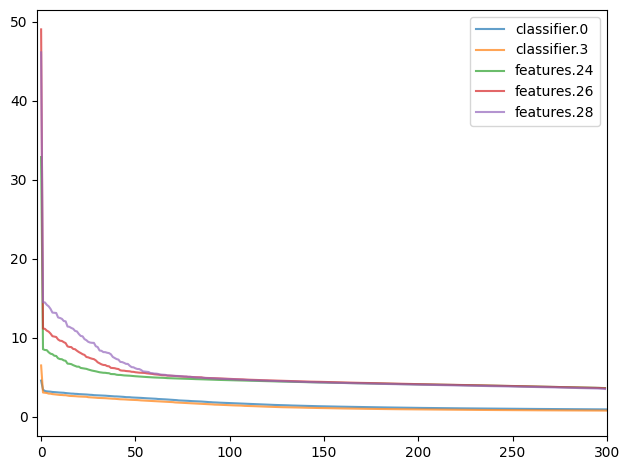

In [6]:
fig, axs = plt.subplots()
for i, layer in enumerate(svds.keys()):
    axs.plot(svds[layer]['s'], label=layer, alpha=0.7)
axs.set_xlim(-2, 300)
axs.legend()
plt.tight_layout()

## Load dataset

In [404]:
#--------------------------------
# Dataset 
#--------------------------------
# model parameters
dataset = 'CIFAR10' 
seed = 29
bs = 64

ds_path = f'/srv/newpenny/dataset/{dataset}'
ds = Cifar(data_path=ds_path,
           dataset=dataset)

ds.load_data(
        batch_size = bs,
        data_kwargs = {'num_workers': 4, 'pin_memory': True},
        seed = seed,
        )

dataset: CIFAR10
Files already downloaded and verified
Files already downloaded and verified


{'train': <torch.utils.data.dataloader.DataLoader at 0x7e9c3d3722d0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7e9c3eab8e90>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e9c3e7a0d70>}

## Load model

In [405]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 2
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

Using cuda:6 device


In [10]:
pretrained = True
model_dir = '/srv/newpenny/XAI/LM/models'
model_name = f'vgg16_pretrained={pretrained}_dataset={dataset}-'\
f'augmented_policy=CIFAR10_bs={bs}_seed={seed}.pth'


nn = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
in_features = 4096
num_classes = len(ds.get_classes()) 
nn.classifier[-1] = torch.nn.Linear(in_features, num_classes)
model = ModelWrap(device=device)
model.set_model(model=nn, path=model_dir, name=model_name, verbose=True)

/home/liviamanovi/gitty/XAI/src/models/model_wrap.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._checkpoint = torch.load(file, map_location=self.device)



-----------------
checkpoint
-----------------
state_dict keys: 
 odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias']) 

train_loss 1.4151224618911744
val_loss 0.8791644280883157
train_accuracy 62.295
val_accuracy 74.96000000000001
epoch 59
batch_size 64
lr 0.001
-----------------



## Load peepholes

In [7]:
abs_path = '/srv/newpenny/XAI/generated_data'

In [8]:
phs_name = 'peepholes'
phs_dir = os.path.join(abs_path, 'peepholes')
peepholes = Peepholes(
        path = phs_dir,
        name = phs_name,
        )
loaders = ds.get_dataset_loaders()


In [9]:
# copy dataset to peepholes dataset
peepholes.get_peep_dataset(
        loaders = loaders,
        verbose = True
        ) 


 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/peepholes/peepholes.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from val

File /srv/newpenny/XAI/generated_data/peepholes/peepholes.val exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/peepholes/peepholes.test exists. Loading from disk.
loaded n_samples:  10000


In [10]:
ph_dl = peepholes.get_dataloaders(batch_size=128, verbose=True)

creating dataloader for:  train
creating dataloader for:  val
creating dataloader for:  test


In [14]:
layers_dict = {'classifier': [0, 3],
               'features': [24, 26, 28]}
model.set_target_layers(target_layers=layers_dict, verbose=True)
print('target layers: ', model.get_target_layers().keys()) 

target layers:  dict_keys(['classifier.0', 'classifier.3', 'features.24', 'features.26', 'features.28'])


In [15]:
layers_list = list(model.get_target_layers().keys())

In [15]:
available_layers = list(next(iter(ph_dl['train']))['peepholes'].keys())
#list(next(iter(ph_dl['train']))['peepholes'].keys())

## Clustering class

* fit on training data
    * can obtain k from the data shape 
* the Class can provide up to the output_peephole per layer. then we will use dedicated functions to get:
    * quantities per single layer (max, entropy)
    * combined scores with multiple layers (simple weights and exponentials)

In [60]:
clust_kwargs = {}

layer = 'classifier-3'

clust_kwargs[layer]= {'algorithm': 'kmeans',
                      'k': 100,
                      'n': num_classes,
                       }


In [24]:
class Clustering: # quella buona
    def __init__(self, algorithm, k, n_clusters, seed=42, 
                 base_dir='clustering'):
        self.algorithm = algorithm  
        self.k = k  
        self.n_clusters = n_clusters
        self.seed = seed
        self.base_dir = f'/srv/newpenny/XAI/generated_data/{base_dir}'

        self._fitted_model = None
        self._cluster_assignments = None        # cluster assignments from the model
        self._cluster_centers = None            # cluster centers from the model
        self._cluster_covariances = None        # cluster covariances from the model
        self._empirical_posteriors = None       # empirical posteriors (P(g, c))

    def fit(self, core_vectors, labels=None):
        '''
        Perform clustering on the training core_vectors of a specific layer.
        
        Args:
        - core_vectors (Tensor): Ex-"peepholes" with reduced dimension (n_samples, k)
        - labels (Tensor): Labels for empirical posteriors computation (optional)
        '''
        #if self.algorithm == 'gmm':
        #    model = GaussianMixture(n_components=self.n_clusters, random_state=self.seed)
        #    model.fit(core_vectors)
        #    self._cluster_assignments = model.predict(core_vectors)
        #    self._cluster_centers = model.means_
        #    self._cluster_covariances = model.covariances_
        #    self._fitted_model = model
        #    
        #elif self.algorithm == 'kmeans':
        #    model = KMeans(n_clusters=self.n_clusters, random_state=self.seed)
        #    model.fit(core_vectors)
        #    self._cluster_assignments = model.predict(core_vectors)
        #    self._cluster_centers = model.cluster_centers_
        #    self._fitted_model = model
#
        ## compute empirical posteriors if labels are provided
        #if labels is not None:
        #    self.compute_empirical_posteriors(labels)
        if self.algorithm == 'gmm':
            model = GaussianMixture(n_components=self.n_clusters, random_state=self.seed)
            model.fit(core_vectors)
            self._cluster_assignments = model.predict(core_vectors)
            self._cluster_centers = model.means_
            self._cluster_covariances = model.covariances_
            self._fitted_model = model
    
        elif self.algorithm == 'kmeans':
            model = KMeans(n_clusters=self.n_clusters, random_state=self.seed)
            model.fit(core_vectors)
            self._cluster_assignments = model.predict(core_vectors)
            self._cluster_centers = model.cluster_centers_
            self._fitted_model = model
    
        # Check if clustering was successful
        if self._cluster_assignments is None:
            raise ValueError("Clustering failed. No assignments were generated.")
    
        # Compute empirical posteriors if labels are provided
        if labels is not None:
            self.compute_empirical_posteriors(labels)

    def compute_empirical_posteriors(self, labels):
        '''
        Compute the empirical posterior matrix P, where P(g, c) is the probability
        that a sample assigned to cluster g belongs to class c.

        Args:
        - labels (Tensor): True class labels for the samples (n_samples, )
        '''
        n_samples = len(labels)
        n_classes = len(torch.unique(labels))
        
        # initialize matrix to count occurrences of (cluster g, class c) pairs
        P_counts = torch.zeros(self.n_clusters, n_classes)

        # count occurrences of (cluster g, class c) pairs
        for i in range(n_samples):
            c = int(labels[i].item())  # true class label
            g = int(self._cluster_assignments[i])  # cluster assignment
            P_counts[g, c] += 1

        # normalize to get empirical posteriors
        P_empirical = P_counts / P_counts.sum(dim=1, keepdim=True)

        # nandle potential division by zero
        P_empirical = torch.nan_to_num(P_empirical)  # replace NaN with 0

        self._empirical_posteriors = P_empirical

    def cluster_probabilities(self, core_vectors):
        '''
        Get cluster probabilities for the provided core_vectors based on the fitted model.
        
        Args:
        - core_vectors (Tensor): Peepholes with reduced dimension (n_samples, k)
        
        Returns:
        - cluster_probs (Tensor): Probabilities for each cluster (n_samples, n_clusters)
        '''
        if self.algorithm == 'gmm':
            return self._fitted_model.predict_proba(core_vectors)  # (n_samples, n_clusters)
        elif self.algorithm == 'kmeans':
            # get distances to each cluster center
            distances = self._fitted_model.transform(core_vectors)
            distances = torch.tensor(distances)
            # convert distances to probabilities (soft assignment)
            cluster_probs = torch.exp(-distances ** 2 / (2 * (distances.std() ** 2)))  # Gaussian-like softmax
            cluster_probs = cluster_probs / cluster_probs.sum(dim=1, keepdim=True)  # normalize to probabilities
            return cluster_probs

    def map_clusters_to_classes(self, core_vectors):
        '''
        Map the cluster probabilities to class probabilities using empirical posteriors.
        
        Args:
        - cluster_probs (Tensor): Probabilities for each cluster (n_samples, n_clusters)
        
        Returns:
        - class_probs (Tensor): Probabilities for each class (n_samples, n_classes)
        '''
        if self._empirical_posteriors is None:
            raise RuntimeError('Please run compute_empirical_posteriors() first.')

        cluster_probs = self.cluster_probabilities(core_vectors)
        cluster_probs = torch.tensor(cluster_probs, dtype=torch.float32)
        
        class_probs = torch.matmul(cluster_probs, self._empirical_posteriors)  # shape: (n_samples, n_classes)
        class_probs = class_probs / class_probs.sum(dim=1, keepdim=True) # aka the new peepholes
        return class_probs

    # confidence scores ---------------------
    #def get_confidence_scores(self, class_probs, score_type="max"):
    #    '''
    #    Compute confidence scores (either max or entropy), save them, or load if they already exist.
    #    
    #    Args:
    #    - class_probs (Tensor): Probabilities for each class (n_samples, n_classes)
    #    - score_type (str): Either 'max' or 'entropy' to specify the type of confidence score.
    #    
    #    Returns:
    #    - confidence_scores (Tensor): The computed confidence scores (n_samples, )
    #    '''
    #    confidence_dir = os.path.join(self.base_dir, 'confidence_scores')
    #    filepath = self.construct_filepath(prefix=f"cs={score_type}", suffix="pkl", dir_path=confidence_dir)
    #    
    #    if os.path.exists(filepath):
    #        print(f"Confidence scores ({score_type}) already exist at {filepath}. Loading...")
    #        with open(filepath, 'rb') as f:
    #            confidence_scores = pickle.load(f)
    #        return confidence_scores
    #
    #    if score_type == "max":
    #        confidence_scores = torch.max(class_probs, dim=1).values
    #    elif score_type == "entropy":
    #        # entropy: -sum(p * log(p)) across classes (axis 1)
    #        entropy = -torch.sum(class_probs * torch.log(class_probs + 1e-12), dim=1)
    #        confidence_scores = entropy
    #    else:
    #        raise ValueError(f"Invalid score_type: {score_type}. Use 'max' or 'entropy'.")
    #
    #    os.makedirs(confidence_dir, exist_ok=True)
    #    with open(filepath, 'wb') as f:
    #        pickle.dump(confidence_scores, f)
    #    print(f'Confidence scores ({score_type}) saved to {filepath}')
    #
    #    return confidence_scores
    def get_confidence_scores(self, class_probs, split='train', score_type='max', save=False):
        #confidence_dir = os.path.join(self.base_dir, 'confidence_scores')
        #os.makedirs(confidence_dir, exist_ok=True)
#
        #filename = "_".join([f'cs={score_type}', self.construct_filename()])
        #filepath = os.path.join(confidence_dir, split, filename)
#
        #if os.path.exists(filepath):
        #    print(f"Confidence scores ({score_type}) already exist at {filepath}. Loading...")
        #    with open(filepath, 'rb') as f:
        #        confidence_scores = pickle.load(f)
        #    return confidence_scores

        if score_type == "max":
            confidence_scores = torch.max(class_probs, dim=1).values
        elif score_type == "entropy":
            entropy = -torch.sum(class_probs * torch.log(class_probs + 1e-12), dim=1)
            confidence_scores = entropy
        else:
            raise ValueError(f"Invalid score_type: {score_type}. Use 'max' or 'entropy'.")
        #if save:
        #    with open(filepath, 'wb') as f:
        #        pickle.dump(confidence_scores, f)
        #    print(f'Confidence scores ({score_type}) saved to {filepath}')

        return confidence_scores



    # save/load results ---------------------
    def save_cluster_results(self, filepath=None):
        """
        Save the clustering results (assignments, centers, covariances) to a file.
        """
        if filepath is None:
            filepath = self.construct_filepath(suffix='pkl') 

        data = {
            'assignments': self._cluster_assignments,
            'centers': self._cluster_centers,
            'k': self.k,
        }

        if self.algorithm == 'gmm':
            data['covariances'] = self._cluster_covariances

        os.makedirs(os.path.dirname(filepath), exist_ok=True)

        with open(filepath, 'wb') as f:
            pickle.dump(data, f)

        # print(f'Clustering results saved to {filepath}')

    def load_cluster_results(self, filepath=None):
        """
        Load clustering results from a file.
        """
        if filepath is None:
            filepath = self.construct_filepath(suffix='pkl') 

        try:
            with open(filepath, 'rb') as f:
                results = pickle.load(f)
            self._cluster_assignments = results['assignments']
            self._cluster_centers = results['centers']
            self.k = results.get('k', self.k)

            if self.algorithm == 'gmm' and 'covariances' in results:
                self._cluster_covariances = results['covariances']

            print(f'Clustering results loaded from {filepath}')
        except FileNotFoundError:
            print(f"File {filepath} not found")
        except Exception as e:
            print(f"An error occurred while loading clustering results: {e}")

    def construct_filepath(self, suffix='pkl', **extra_kwargs):
        '''
        Constructs a file path for saving or loading clustering results based on attributes.
        Combines the base directory, attributes, and extra arguments into the file name.
        '''
 
        dir_path = self.base_dir
        os.makedirs(dir_path, exist_ok=True)
        filename = self.construct_filename(suffix=suffix, **extra_kwargs)
        return os.path.join(dir_path, filename)

    def construct_filename(self, suffix='pkl', **extra_kwargs):
        '''
        Constructs a detailed filename for saving clustering results,
        using class attributes and any extra keyword arguments passed.
        '''

        filename_kwargs = self.generate_kwargs_from_attrs()
        filename_kwargs.update(extra_kwargs)

        filename_parts = [f"{k}={v}" for k, v in filename_kwargs.items()]
        filename = "_".join(filename_parts) + f".{suffix}"
        
        return filename

    def generate_kwargs_from_attrs(self):
        '''
        Generate a dictionary of current class attributes and their values.
        This can be used for constructing filenames or passing arguments.
        '''
        attrs = {
            'algorithm': self.algorithm,
            'k': self.k,
            'n_clusters': self.n_clusters,
            'seed': self.seed
        }
        
        return attrs


In [25]:
class Clustering:
    def __init__(self, algorithm, k, n_clusters, seed=42, base_dir='clustering'):
        self.algorithm = algorithm  
        self.k = k  
        self.n_clusters = n_clusters
        self.seed = seed
        self.base_dir = f'../data/{base_dir}'

        self._fitted_model = None
        self._cluster_assignments = None        # cluster assignments from the model
        self._cluster_centers = None            # cluster centers from the model
        self._cluster_covariances = None        # cluster covariances from the model
        self._empirical_posteriors = None       # empirical posteriors (P(g, c))

    def fit(self, core_vectors, labels=None):
        '''
        Perform clustering on the core_vectors of a specific layer.
        
        Args:
        - core_vectors (Tensor): Ex-"peepholes" with reduced dimension (n_samples, k)
        - labels (Tensor): Labels for empirical posteriors computation (optional)
        '''
        if self.algorithm == 'gmm':
            model = GaussianMixture(n_components=self.n_clusters, random_state=self.seed)
            model.fit(core_vectors)
            self._cluster_assignments = model.predict(core_vectors)
            self._cluster_centers = model.means_
            self._cluster_covariances = model.covariances_
            self._fitted_model = model
            
        elif self.algorithm == 'kmeans':
            model = KMeans(n_clusters=self.n_clusters, random_state=self.seed)
            model.fit(core_vectors)
            self._cluster_assignments = model.predict(core_vectors)
            self._cluster_centers = model.cluster_centers_
            self._fitted_model = model

        # compute empirical posteriors if labels are provided
        if labels is not None:
            self.compute_empirical_posteriors(labels)

    def compute_empirical_posteriors(self, labels):
        '''
        Compute the empirical posterior matrix P, where P(g, c) is the probability
        that a sample assigned to cluster g belongs to class c.

        Args:
        - labels (Tensor): True class labels for the samples (n_samples, )
        '''
        n_samples = len(labels)
        n_classes = len(torch.unique(labels))
        
        # initialize matrix to count occurrences of (cluster g, class c) pairs
        P_counts = torch.zeros(self.n_clusters, n_classes)

        # count occurrences of (cluster g, class c) pairs
        for i in range(n_samples):
            c = int(labels[i].item())  # true class label
            g = int(self._cluster_assignments[i])  # cluster assignment
            P_counts[g, c] += 1

        # normalize to get empirical posteriors
        P_empirical = P_counts / P_counts.sum(dim=1, keepdim=True)

        # nandle potential division by zero
        P_empirical = torch.nan_to_num(P_empirical)  # replace NaN with 0

        self._empirical_posteriors = P_empirical

    def cluster_probabilities(self, core_vectors):
        '''
        Get cluster probabilities for the provided core_vectors based on the fitted model.
        
        Args:
        - core_vectors (Tensor): Peepholes with reduced dimension (n_samples, k)
        
        Returns:
        - cluster_probs (Tensor): Probabilities for each cluster (n_samples, n_clusters)
        '''
        if self.algorithm == 'gmm':
            return self._fitted_model.predict_proba(core_vectors)  # (n_samples, n_clusters)
        elif self.algorithm == 'kmeans':
            # get distances to each cluster center
            distances = self._fitted_model.transform(core_vectors)
            distances = torch.tensor(distances)
            # convert distances to probabilities (soft assignment)
            cluster_probs = torch.exp(-distances ** 2 / (2 * (distances.std() ** 2)))  # Gaussian-like softmax
            cluster_probs = cluster_probs / cluster_probs.sum(dim=1, keepdim=True)  # normalize to probabilities
            return cluster_probs

    def map_clusters_to_classes(self, core_vectors):
        '''
        Map the cluster probabilities to class probabilities using empirical posteriors.
        
        Args:
        - cluster_probs (Tensor): Probabilities for each cluster (n_samples, n_clusters)
        
        Returns:
        - class_probs (Tensor): Probabilities for each class (n_samples, n_classes)
        '''
        if self._empirical_posteriors is None:
            raise RuntimeError('Please run compute_empirical_posteriors() first.')

        cluster_probs = self.cluster_probabilities(core_vectors)
        cluster_probs = torch.tensor(cluster_probs, dtype=torch.float32)
        
        class_probs = torch.matmul(cluster_probs, self._empirical_posteriors)  # shape: (n_samples, n_classes)
        class_probs = class_probs / class_probs.sum(dim=1, keepdim=True) # aka the new peepholes
        return class_probs

    # save/load results ---------------------


In [113]:
algorithm = 'gmm'
k = 20
n_clusters = int(num_classes/2)

clustering = Clustering(algorithm, k, n_clusters)

In [129]:
# prepare data
core_vectors = {}
v_labels = {}
decisions = {}

for split in ['train', 'val', 'test']:
    first_batch = next(iter(ph_dl['train']))
    p = first_batch['peepholes']
    layer_keys = p.keys()  
    
    core_vectors[split] = {key: [] for key in layer_keys}
    v_labels[split] = []
    decisions[split] = []

    for batch in ph_dl[split]:
        
        peepholes = batch['peepholes']
        labels = batch['label']
        decision_results = batch['result']

        for layer, peephole_tensor in peepholes.items():
            batch_size, d = peephole_tensor.shape
                            
            reduced_peephole = peephole_tensor[:, :k]

            core_vectors[split][layer].append(reduced_peephole)
        v_labels[split].append(labels)
        decisions[split].append(decision_results.bool())
        
    for layer in core_vectors[split]:
        core_vectors[split][layer] = torch.cat(core_vectors[split][layer], dim=0) 
    
    v_labels[split] = torch.cat(v_labels[split], dim=0)
    decisions[split] = torch.cat(decisions[split], dim=0)

In [34]:
vars(clustering)

{'algorithm': 'gmm',
 'k': 20,
 'n_clusters': 50,
 'seed': 42,
 'base_dir': '../data/clustering',
 '_fitted_model': None,
 '_cluster_assignments': None,
 '_cluster_centers': None,
 '_cluster_covariances': None,
 '_empirical_posteriors': None}

In [114]:
# fit clustering model
split = 'train'
layer = 'classifier.0'
labels = v_labels[split]

clustering.fit(core_vectors[split][layer], labels)

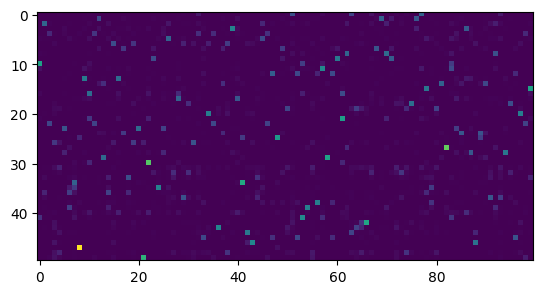

In [108]:
plt.imshow(clustering._empirical_posteriors)

In [125]:
max_scores = {}
entropy_scores = {}

for split in ['train', 'val']:
    class_probs = clustering.map_clusters_to_classes(core_vectors[split][layer])
    _max = clustering.get_confidence_scores(class_probs, split=split, score_type='max')
    _entropy = clustering.get_confidence_scores(class_probs, split=split, score_type='entropy')

    max_scores[split] = _max
    entropy_scores[split] = _entropy

Confidence scores (max) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/train/cs=max_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...
Confidence scores (entropy) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/train/cs=entropy_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...
Confidence scores (max) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/val/cs=max_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...
Confidence scores (entropy) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/val/cs=entropy_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...


### structure without tensordict

In [12]:
from tqdm import tqdm

In [143]:
k_list = [20]
n_clusters_list = [50]

# select algorithm
algorithm = 'gmm'

# loop over k and n_clusters
for k in k_list:
    # prepare data
    core_vectors = {}
    v_labels = {}
    decisions = {}
    print('Preparing data')
    for split in ['train', 'val']: #, 'test']:
        first_batch = next(iter(ph_dl['train']))
        p = first_batch['peepholes']
        layer_keys = p.keys() # so we can automatically loop over available layers 
        
        core_vectors[split] = {key: [] for key in layer_keys}
        v_labels[split] = []
        decisions[split] = []
    
        for batch in ph_dl[split]:
            
            peepholes = batch['peepholes']
            labels = batch['label']
            decision_results = batch['result']
    
            for layer, peephole_tensor in peepholes.items():
                batch_size, d = peephole_tensor.shape
                                
                reduced_peephole = peephole_tensor[:, :k]
    
                core_vectors[split][layer].append(reduced_peephole)
            v_labels[split].append(labels)
            decisions[split].append(decision_results.bool())
            
        for layer in core_vectors[split]:
            core_vectors[split][layer] = torch.cat(core_vectors[split][layer], dim=0) 
        
        v_labels[split] = torch.cat(v_labels[split], dim=0)
        decisions[split] = torch.cat(decisions[split], dim=0)
    print('Data is ready')
    # clustering init and fit for each layer
    for n_clusters in tqdm(n_clusters_list):
        split = 'train'
        
        clustering = {}
        for layer in layer_keys:
            
            clustering[layer] = Clustering(algorithm, k, n_clusters)
            labels = v_labels[split]
            clustering[layer].fit(core_vectors[split][layer], labels)
    
        # use train split (get scores)
        max_scores = {}
        entropy_scores = {}
        split = 'train'
        class_probs = clustering[layer].map_clusters_to_classes(core_vectors[split][layer])
        _max = clustering[layer].get_confidence_scores(class_probs, split=split, score_type='max')
        _entropy = clustering[layer].get_confidence_scores(class_probs, split=split, score_type='entropy')
    
        max_scores[split] = _max
        entropy_scores[split] = _entropy
    
        # use val split
        split = 'val'
        class_probs = clustering[layer].map_clusters_to_classes(core_vectors[split][layer])
        _max = clustering[layer].get_confidence_scores(class_probs, split=split, score_type='max')
        _entropy = clustering[layer].get_confidence_scores(class_probs, split=split, score_type='entropy')
    
        max_scores[split] = _max
        entropy_scores[split] = _entropy

Preparing data
Data is ready


100%|████████████████████████████████████████████| 1/1 [02:11<00:00, 131.39s/it]

Confidence scores (max) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/train/cs=max_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...
Confidence scores (entropy) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/train/cs=entropy_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...
Confidence scores (max) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/val/cs=max_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...
Confidence scores (entropy) already exist at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/val/cs=entropy_algorithm=gmm_k=20_n_clusters=50_seed=42.pkl. Loading...


### structure with tensordict

Hopefully will look something like:
```python
all_scores = {
    20: {  # k value
        50: {  # n_clusters value
            'train': {
                'layer1': {
                    'max': tensor([...]),
                    'entropy': tensor([...])
                },
                'layer2': {
                    'max': tensor([...]),
                    'entropy': tensor([...])
                }
            },
            'val': {
                'layer1': {
                    'max': tensor([...]),
                    'entropy': tensor([...])
                },
                'layer2': {
                    'max': tensor([...]),
                    'entropy': tensor([...])
                }
            }
        }
    }
}


In [152]:
k_list = [20]
n_clusters_list = [50]

# select algorithm
algorithm = 'gmm'

# init results container
#all_scores = TensorDict()
all_scores = TensorDict({}, batch_size=[])

# loop over k and n_clusters
for k in k_list:
    all_scores.set(str(k), TensorDict({}, batch_size=[]))  # set for k
    # prepare data
    print('Preparing data')
    core_vectors = {}
    v_labels = {}
    decisions = {}

    for split in ['train', 'val']: #, 'test']:
        first_batch = next(iter(ph_dl['train']))
        p = first_batch['peepholes']
        layer_keys = p.keys() # so we can automatically loop over available layers 
        
        core_vectors[split] = {key: [] for key in layer_keys}
        v_labels[split] = []
        decisions[split] = []
    
        for batch in ph_dl[split]:
            
            peepholes = batch['peepholes']
            labels = batch['label']
            decision_results = batch['result']
    
            for layer, peephole_tensor in peepholes.items():
                batch_size, d = peephole_tensor.shape
                                
                reduced_peephole = peephole_tensor[:, :k]
    
                core_vectors[split][layer].append(reduced_peephole)
            v_labels[split].append(labels)
            decisions[split].append(decision_results.bool())
            
        for layer in core_vectors[split]:
            core_vectors[split][layer] = torch.cat(core_vectors[split][layer], dim=0) 
        
        v_labels[split] = torch.cat(v_labels[split], dim=0)
        decisions[split] = torch.cat(decisions[split], dim=0)
    print('Data is ready')
    # clustering init and fit for each layer
    for n_clusters in tqdm(n_clusters_list):

        #all_scores[k] = {n_clusters: {}}
        all_scores[str(k)].set(str(n_clusters), TensorDict({
            'train': TensorDict({}, batch_size=[]),
            'val': TensorDict({}, batch_size=[])
        }, batch_size=[]))
        
        # fit clustering model for each layer on train split
        clustering = {}
        for layer in tqdm(layer_keys):
            clustering[layer] = Clustering(algorithm, k, n_clusters)
            labels = v_labels['train']  # Use the 'train' split labels
            clustering[layer].fit(core_vectors['train'][layer], labels)

        # compute max and entropy scores for both 'train' and 'val'
        for split in ['train', 'val']:
            all_scores[str(k)][str(n_clusters)][split] = {}
            for layer in layer_keys:
                class_probs = clustering[layer].map_clusters_to_classes(core_vectors[split][layer])

                _max = clustering[layer].get_confidence_scores(class_probs, split=split, score_type='max')
                _entropy = clustering[layer].get_confidence_scores(class_probs, split=split, score_type='entropy')

                all_scores[str(k)][str(n_clusters)][split][layer] = {
                    'max': _max,
                    'entropy': _entropy
                }
        

Preparing data
Data is ready


100%|████████████████████████████████████████████| 1/1 [02:08<00:00, 128.68s/it]


In [165]:
all_scores[str(k)][str(n_clusters)]['val']['classifier.0']['entropy']

tensor([3.5583, 3.0782, 1.9018,  ..., 1.8225, 2.4651, 2.7739])

In [ ]:
# get right filepname and save td + metadata

In [166]:
abs_path = '/srv/newpenny/XAI/generated_data/clustering'
res_dir = 'confidence_scores'
res_path = os.path.join(abs_path, res_dir)

In [185]:
dnn_model = 'vgg16'
res_suffix = '.pth'
res_filename = f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}'
torch.save(all_scores, os.path.join(res_path, res_filename + res_suffix))

In [175]:
metadata = {
    'k_values': k_list,
    'n_clusters': n_clusters_list,
    'layers': list(layer_keys)
}

In [178]:
metadata

{'k_values': [20],
 'n_clusters': [50],
 'layers': ['classifier.0',
  'classifier.3',
  'features.24',
  'features.26',
  'features.28']}

In [25]:
import json

In [26]:
from clustering.clustering import prepare_data, compute_scores

In [58]:
layer = 'classifier.0'
k = 20
data = prepare_data(ph_dl, [layer], k)

Preparing data
Preparing data
Data is ready


In [59]:
len(data['core_vectors']['train'][layer])

40000

In [60]:
len(data['true_labels']['train'])

40000

In [36]:
kk = Clustering('gmm', 20, 50)

In [43]:
kk.fit(data['core_vectors']['train'][layer], data['true_labels']['train'])

In [46]:
kk.compute_empirical_posteriors(data['true_labels']['train'])

In [312]:
core_vectors = data['core_vectors']
v_labels = data['true_labels']
decisions = data['decisions']

In [28]:
available_layers = list(next(iter(ph_dl['train']))['peepholes'].keys())

In [314]:
layers_list = available_layers
compute_scores(k, n_clusters, layers_list, data, all_scores, metadata)

100%|█████████████████████████████████████████████| 1/1 [00:30<00:00, 30.81s/it]


no need 2 add keys


In [47]:
data['core_vectors'].keys()

dict_keys(['train', 'val'])

In [56]:
#for split in data['core_vectors'].keys():
for layer in [layer]:
    compute_scores(20, 50, 'gmm', [layer], data, all_scores=None, metadata=None)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

40000


100%|█████████████████████████████████████████████| 1/1 [00:32<00:00, 32.64s/it]


In [316]:
layer_keys = layers_list

In [319]:
# init params
k_list = [20]
n_clusters_list = [50, 100]
algorithm = 'gmm'

# check for existing results or init results container
res_suffix = '.pth'
res_filename = f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}'
tensor_dict_path = os.path.join(res_path, res_filename + res_suffix)

meta_filename = '_'.join(['metadata', res_filename]) + '.json'
meta_path = os.path.join(res_path, meta_filename)

# check if results and metadata exist
results_exist = os.path.exists(tensor_dict_path)
metadata_exist = os.path.exists(meta_path)

if results_exist:
    print('Results already present')
    all_scores = torch.load(tensor_dict_path)
else:
    all_scores = TensorDict({}, batch_size=[])

if metadata_exist:
    print('Loading related metadata')
    with open(meta_path, 'r') as json_file:
        metadata = json.load(json_file)
else:
    metadata = {'k_values': [], 'n_clusters': [], 'layers': []}

# loop over k and n_clusters
for k in k_list:
    str_k = str(k) if not isinstance(k, str) else k

    if str_k not in all_scores.keys():
        all_scores.set(str_k, TensorDict({}, batch_size=[]))

    for n_clusters in n_clusters_list:
        str_n_clusters = str(n_clusters) if not isinstance(n_clusters, str) else n_clusters

        # check if the combination of k and n_clusters already exists in the scores
        if str_n_clusters in all_scores[str_k].keys():
            existing_layers = all_scores[str_k][str_n_clusters]['train'].keys()

            # check if only specific layers need to be computed
            if existing_layers and any(layer not in existing_layers for layer in layer_keys):
                # compute only the missing layers
                for layer in layer_keys:
                    if layer not in existing_layers:
                        data = prepare_data(ph_dl, [layer], k)
                        compute_scores(k, n_clusters, [layer], data, all_scores, metadata)

            else:
                print(f"Skipping k={k}, n_clusters={n_clusters} for all layers as it's already computed.")
                continue  # skip to the next n_clusters if all layers have data

        else:
            # if not existing, create the subdict for n_clusters and compute all layers
            all_scores[str_k].set(str_n_clusters, TensorDict({
                'train': TensorDict({}, batch_size=[]),
                'val': TensorDict({}, batch_size=[])
            }, batch_size=[]))
            existing_layers = []  # no existing layers yet

            # prepare data for all splits
            data = prepare_data(ph_dl, layer_keys, k)

            # compute scores for all layers and splits
            for split in data['core_vectors'].keys():
                for layer in layer_keys:
                    compute_scores(k, n_clusters, layer, all_scores, metadata)

# Save all scores and metadata after processing
torch.save(all_scores, tensor_dict_path)
with open(meta_path, 'w') as json_file:
    json.dump(metadata, json_file, indent=4)

print("Results and metadata saved.")

Results already present
Loading related metadata
Skipping k=20, n_clusters=50 for all layers as it's already computed.
Skipping k=20, n_clusters=100 for all layers as it's already computed.
Results and metadata saved.


/tmp/ipykernel_2996647/2060854898.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_scores = torch.load(tensor_dict_path)


## TODO

* split val data into correct/wrong
* make confusion matrix for each threshold on the training scores
* do it for single layers and combined

In [16]:
# prepare data
# if you need only labels and decision outcomes, k and layers_list are irrelevant
data = prepare_data(ph_dl, available_layers[:1], k=10)

Preparing data
Preparing data
Data is ready


In [108]:
# get correct/wrong decision indices
decisions = data['decisions']
decisions

{'train': tensor([True, True, True,  ..., True, True, True]),
 'val': tensor([ True,  True,  True,  ..., False,  True,  True])}

In [109]:
# load collected scores
dataset = 'CIFAR100'
dnn_model = 'vgg16'
algorithm = 'gmm'

In [107]:
# load existing results
# check for existing results or init results container
res_dir = 'clustering/confidence_scores'
res_path = os.path.join(abs_path, res_dir)
tensor_dict_path = os.path.join(res_path, f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}.memmap')

if os.path.exists(tensor_dict_path):
    print('Results already present')
    all_scores = TensorDict.load_memmap(tensor_dict_path)
else:
    all_scores = TensorDict({}, batch_size=[])

# init the peephole container if not existing
new_peep_dir = 'clustering/peepholes' 
new_peep_path = os.path.join(abs_path, new_peep_dir) 
new_peep_tensor_dict_path = os.path.join(new_peep_path, f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}.memmap')

if os.path.exists(new_peep_tensor_dict_path):
    print('New peepholes results already present')
    peephole_scores = TensorDict.load_memmap(new_peep_tensor_dict_path)
else:
    # print('Initializing peephole container')
    peephole_scores = TensorDict({}, batch_size=[])

Results already present
New peepholes results already present


In [111]:
k_values_list, n_clusters_list, splits_list, layers_list = get_unique_values(all_scores)

In [112]:
k_values_list

['20', '50', '70']

In [113]:
n_clusters_list

['100', '150', '200', '50']

In [114]:
splits_list

['train', 'val']

In [115]:
layers_list

['classifier.0', 'classifier.3', 'features.24', 'features.26', 'features.28']

In [122]:
for k in k_values_list:
    for n in n_clusters_list:
        for layer in layers_list:
            for measure in ['max', 'entropy']:
                list_correct = [] 
                list_wrong = []  
 
                conf_t = all_scores[k][n]['train'][layer][measure] 
                conf_v = all_scores[k][n]['val'][layer][measure]    
            
                for i in quantiles:
                    # compute threshold
                    q = torch.quantile(conf_t, i)

                    if measure=='max':
                        # get indices where validation scores exceed the threshold
                        idx = torch.where(conf_v > q)[0]  
                    elif measure=='entropy':
                        torch.where(conf_v < q)[0]
            


KeyboardInterrupt: 


KeyboardInterrupt



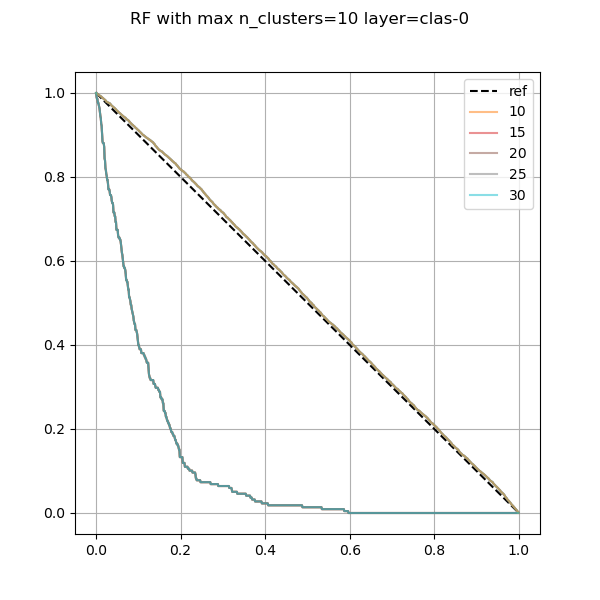

Error in callback <function flush_figures at 0x7f8dfb508a60> (for post_execute):



KeyboardInterrupt



In [ ]:
for j, (layer, weight) in enumerate(w_dict.items()):

    for n in num_clusters:    
        
        fig, axs = plt.subplots(1, figsize=(6, 6))
        axs.grid()
        axs.plot([0, 1],[1,0],label='ref', c='k', ls='--')
        
        for dim in dims_list: 
            
            prob_train = out_p_prob_train[layer][(dim, n)]
            prob_val = out_p_prob_val[layer][(dim, n)]
            
            if measure=='max':
                conf_t = np.max(prob_train,axis=1)
                conf_v = np.max(prob_val,axis=1)
            elif measure=='entropy':
                conf_t = H(prob_train,axis=1)
                conf_v = H(prob_val,axis=1)
            
            threshold = []
            list_true_max_ = []
            list_false_max_ = []
            
            for i in array:
            
                perc = np.quantile(conf_t, i)
                
                threshold.append(perc)
                idx = np.argwhere(conf_v>perc)[:,0]
                counter = collections.Counter(results_v[idx])
                list_true_max_.append(counter[True]/tot_true_v)
                list_false_max_.append(counter[False]/tot_false_v)  

            axs.plot(array, list_true_max_, alpha=0.5)
            axs.plot(array, list_false_max_, label=f'{dim}', alpha=0.5)
            
            axs.legend()
            fig.suptitle(f'RF with {measure} n_clusters={n} layer={layer}\n', fontsize=12)
            # axs[j].set_title(f'weights={formatted_weight}')
            #axs[j,k].title(f'dim={dim} num_clusters={n}', fontsize=16)
            
            
fig.tight_layout()
fig.subplots_adjust(top=0.9)

In [458]:
val, idx = torch.topk(cs, 5, axis=1)

In [459]:
idx[:, 1]

tensor([85, 29, 92,  ..., 76, 91, 86])

In [460]:
(v_labels['train']).to(int)

tensor([85,  9, 14,  ..., 56, 55, 39])

In [461]:
torch.sum((v_labels['train']).to(int)==torch.argmax(cs, axis=1))

tensor(1694)

In [462]:
torch.sum((v_labels['train']).to(int)==idx[:, 1])

tensor(1117)

## Testing with memmap


In [1]:
import os
import json
import torch
from tensordict import TensorDict
from tensordict import MemoryMappedTensor as MMT
from datasets.cifar import Cifar
from models.model_wrap import ModelWrap 
from peepholes.peepholes import Peepholes
from clustering.clustering import Clustering
from clustering.clustering import prepare_data, compute_scores

In [82]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 2
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

#--------------------------------
# Parameters
#--------------------------------
dnn_model = 'vgg16'
abs_path = '/srv/newpenny/XAI/generated_data'
dataset = 'CIFAR100' 
seed = 29
bs = 64
ds = Cifar(dataset=dataset)

ds.load_data(batch_size=bs, data_kwargs={'num_workers': 4, 'pin_memory': True}, seed=seed) 
print('Loading the ex-peepholes')

phs_name = 'peepholes'
phs_dir = os.path.join(abs_path, 'peepholes')
peepholes = Peepholes(path=phs_dir, name=phs_name)
loaders = ds.get_dataset_loaders()

# Copy dataset to peepholes dataset
peepholes.get_peep_dataset(loaders=loaders, verbose=True) 
ph_dl = peepholes.get_dataloaders(batch_size=128, verbose=True)

available_layers = list(next(iter(ph_dl['train']))['peepholes'].keys())

Using cuda:6 device
dataset: CIFAR100
Files already downloaded and verified
Files already downloaded and verified
Loading the ex-peepholes

 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/peepholes/peepholes.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from val

File /srv/newpenny/XAI/generated_data/peepholes/peepholes.val exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/peepholes/peepholes.test exists. Loading from disk.
loaded n_samples:  10000
creating dataloader for:  train
creating dataloader for:  val
creating dataloader for:  test


In [91]:
print('Computing confidence scores')

k_list = [20, 50, 70]
n_clusters_list = [50, 100, 150, 200]
layers_list = available_layers
algorithm = 'gmm'

# check for existing results or init results container
res_dir = 'clustering/confidence_scores'
res_path = os.path.join(abs_path, res_dir)
tensor_dict_path = os.path.join(res_path, f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}.memmap')

if os.path.exists(tensor_dict_path):
    print('Results already present')
    all_scores = TensorDict.load_memmap(tensor_dict_path)
else:
    all_scores = TensorDict({}, batch_size=[])

Computing confidence scores
Results already present


In [4]:
# converting my old data to memmap

# Ensure the results directory exists
res_dir = 'clustering/confidence_scores'
res_path = os.path.join('/srv/newpenny/XAI/generated_data', res_dir)

if not os.path.exists(res_path):
    os.makedirs(res_path)

# Loading existing scores from .pth file if needed
old_tensor_dict_path = os.path.join(res_path, 'algorithm=gmm_dataset=CIFAR100_dnn=vgg16.pth')

# Check if the file exists
if os.path.exists(old_tensor_dict_path):
    # Load existing all_scores
    all_scores = torch.load(old_tensor_dict_path)

    # Create a new MemoryMappedTensor with the same structure
    new_all_scores = TensorDict({}, batch_size=[])

    for k in all_scores.keys():
        new_all_scores.set(str(k), TensorDict({}, batch_size=[]))
        for n_clusters in all_scores[str(k)].keys():
            new_all_scores[str(k)].set(str(n_clusters), TensorDict({}, batch_size=[]))
            for split in all_scores[str(k)][str(n_clusters)].keys():
                new_all_scores[str(k)][str(n_clusters)].set(split, TensorDict({}, batch_size=[]))
                for layer in all_scores[str(k)][str(n_clusters)][split].keys():
                    # Create MemoryMappedTensor for max and entropy
                    _max = all_scores[str(k)][str(n_clusters)][split][layer]['max']
                    _entropy = all_scores[str(k)][str(n_clusters)][split][layer]['entropy']

                    new_all_scores[str(k)][str(n_clusters)][split][layer] = {
                        'max': MMT(_max.shape),
                        'entropy': MMT(_entropy.shape)
                    }
                    # Populate the MMT with existing data
                    new_all_scores[str(k)][str(n_clusters)][split][layer]['max'].copy_(_max)
                    new_all_scores[str(k)][str(n_clusters)][split][layer]['entropy'].copy_(_entropy)

    # Save the new MemoryMappedTensor
    new_tensor_dict_path = os.path.join(res_path, 'algorithm=gmm_dataset=CIFAR100_dnn=vgg16.memmap')
    new_all_scores.memmap(new_tensor_dict_path, num_threads=4)

    print(f"Converted and saved new all_scores with memory mapping at {new_tensor_dict_path}.")
else:
    print(f"No existing scores found at {old_tensor_dict_path}. Please check the path.")


/tmp/ipykernel_1356887/2924401518.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_scores = torch.load(old_tensor_dict_path)


Converted and saved new all_scores with memory mapping at /srv/newpenny/XAI/generated_data/clustering/confidence_scores/algorithm=gmm_dataset=CIFAR100_dnn=vgg16.memmap.


In [92]:
# init the peephole container if not existing
new_peep_dir = 'clustering/peepholes' 
new_peep_path = os.path.join(abs_path, new_peep_dir) 
new_peep_tensor_dict_path = os.path.join(new_peep_path, f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}.memmap')

if os.path.exists(new_peep_tensor_dict_path):
    print('New peepholes results already present')
    peephole_scores = TensorDict.load_memmap(new_peep_tensor_dict_path)
else:
    print('Initializing peephole container')
    peephole_scores = TensorDict({}, batch_size=[])

New peepholes results already present


In [85]:
peephole_scores

TensorDict(
    fields={
        20: TensorDict(
            fields={
                100: TensorDict(
                    fields={
                        train: TensorDict(
                            fields={
                                classifier.0: MemoryMappedTensor(shape=torch.Size([40000, 100]), device=cpu, dtype=torch.float32, is_shared=True),
                                classifier.3: MemoryMappedTensor(shape=torch.Size([40000, 100]), device=cpu, dtype=torch.float32, is_shared=True),
                                features.24: MemoryMappedTensor(shape=torch.Size([40000, 100]), device=cpu, dtype=torch.float32, is_shared=True),
                                features.26: MemoryMappedTensor(shape=torch.Size([40000, 100]), device=cpu, dtype=torch.float32, is_shared=True),
                                features.28: MemoryMappedTensor(shape=torch.Size([40000, 100]), device=cpu, dtype=torch.float32, is_shared=True)},
                            batch_size=torch.Size([]),


In [ ]:
# Loop over k and n_clusters
for k in k_list:
    str_k = str(k)
    if str_k not in all_scores.keys():
        all_scores.set(str_k, TensorDict({}, batch_size=[]))
    
    for n_clusters in n_clusters_list:
        str_n_clusters = str(n_clusters)

        # Check if the combination of k and n_clusters already exists in the scores
        if str_n_clusters in all_scores[str_k].keys():
            existing_layers = all_scores[str_k][str_n_clusters]['train'].keys()
            
            # Compute only the missing layers
            for layer in layers_list:
                if layer not in existing_layers:
                    data = prepare_data(ph_dl, [layer], k)
                    print(f'Clustering for layer={layer}')
                    compute_scores(k, n_clusters, algorithm, [layer], data, all_scores, metadata)
        else:
            print(f'Clustering with algorithm={algorithm}, k={k}, n_clusters={n_clusters}')
            # If not existing, create the subdict for n_clusters
            all_scores[str_k].set(str_n_clusters, TensorDict({
                'train': TensorDict({}, batch_size=[]),
                'val': TensorDict({}, batch_size=[])
            }, batch_size=[]))
            
            # Prepare data for all splits
            data = prepare_data(ph_dl, layers_list, k)
            compute_scores(k, n_clusters, algorithm, layers_list, data, all_scores, metadata)

# Pre-allocate memory-mapped tensors for scores
for layer in layers_list:
    n_samples = len(loaders['train'].dataset)  # Get the number of samples from the training loader
    all_scores[str_k][str_n_clusters]['train'][layer] = MMT.empty(shape=torch.Size((n_samples,)))  # Initialize with MMT

# Save all scores and metadata after processing
all_scores.memmap(tensor_dict_path, num_threads=4)  # Specify the number of threads for saving
with open(meta_path, 'w') as json_file:
    json.dump(metadata, json_file, indent=4)

print('Results and metadata saved.')

In [86]:
peephole_scores[str(k)][str(n_clusters)][split]['features.24']

MemoryMappedTensor([[1.4297e-02, 6.2320e-03, 8.3093e-03,  ..., 2.0773e-03,
                     4.1895e-03, 4.0850e-03],
                    [9.1433e-03, 1.1254e-02, 1.6600e-02,  ..., 5.3462e-03,
                     2.2934e-02, 5.3461e-03],
                    [1.4275e-02, 6.1651e-03, 8.2201e-03,  ..., 2.0550e-03,
                     4.1258e-03, 4.0786e-03],
                    ...,
                    [1.1765e-02, 1.1765e-02, 5.8824e-03,  ..., 5.8824e-03,
                     2.1116e-15, 1.4074e-15],
                    [1.1765e-02, 1.1765e-02, 5.8824e-03,  ..., 5.8824e-03,
                     1.0332e-35, 6.9172e-36],
                    [1.1765e-02, 1.1765e-02, 5.8824e-03,  ..., 5.8824e-03,
                     3.3153e-22, 1.2134e-22]])

In [87]:
torch.max(peephole_scores[str(k)][str(n_clusters)][split]['classifier.3'], axis=1)

torch.return_types.max(
values=tensor([0.0470, 0.0470, 0.0321,  ..., 0.1230, 0.0325, 0.0252]),
indices=tensor([95, 95, 73,  ..., 21,  4, 88]))

In [88]:
data['true_labels']['val']

tensor([44., 18., 83.,  ..., 44., 42., 45.])

In [89]:
c = data['true_labels']['val']
_, g = torch.max(peephole_scores[str(50)][str(150)][split]['classifier.0'], axis=1)

In [90]:
torch.sum(c == g)

tensor(4975)

In [40]:
for k in k_list:  # loop over core-vector dimension
    str_k = str(k)

    # initialize peephole_scores for k
    if str_k not in peephole_scores.keys():
        peephole_scores.set(str_k, TensorDict({}, batch_size=[]))

    for n_clusters in n_clusters_list:  # loop over n_clusters
        str_n_clusters = str(n_clusters)

        # initialize peephole_scores for n_clusters
        if str_n_clusters not in peephole_scores[str_k].keys():
            peephole_scores[str_k].set(str_n_clusters, TensorDict({
                'train': TensorDict({}, batch_size=[]),
                'val': TensorDict({}, batch_size=[]),
            }, batch_size=[]))

        # for both train and val splits, ensure layers exist
        for split in ['train', 'val']:
            if split not in peephole_scores[str_k][str_n_clusters].keys():
                peephole_scores[str_k][str_n_clusters].set(split, TensorDict({}, batch_size=[]))

            existing_layers = peephole_scores[str_k][str_n_clusters][split].keys()
            
            # check if all layers are present in the current split
            if existing_layers and any(layer not in existing_layers for layer in layers_list):
                for layer in layers_list:
                    if layer not in existing_layers:
                        data = prepare_data(ph_dl, [layer], k)
                        print(f'Clustering for layer={layer} with n_clusters={n_clusters}')
                        compute_scores(k, 
                                       n_clusters, 
                                       algorithm, 
                                       [layer], 
                                       data, 
                                       peephole_scores, 
                                       all_scores, 
                                       compute_scores=True, 
                                       seed=42)

            else:
                print(f'Skipping {algorithm} k={k}, n_clusters={n_clusters} for {split} layers')
                continue  # skip to the next n_clusters if all layers have data

        # if not all layers have data, we still need to compute scores
        if str_n_clusters not in peephole_scores[str_k].keys() or not existing_layers:
            print('Clustering')
            print(f'algorithm={algorithm}, k={k}, n_clusters={n_clusters}')

            data = prepare_data(ph_dl, layers_list, k)

            n_samples_train = len(data['core_vectors']['train'][layers_list[0]])
            n_samples_val = len(data['core_vectors']['val'][layers_list[0]])

            # initialize all_scores for n_clusters
            all_scores[str_k].set(str_n_clusters, TensorDict({
                'train': TensorDict({
                    layer: MMT.empty(shape=(n_samples_train,)) for layer in layers_list}, batch_size=[]),
                'val': TensorDict({
                    layer: MMT.empty(shape=(n_samples_val,)) for layer in layers_list}, batch_size=[])
            }, batch_size=[]))

            compute_scores(k, 
                           n_clusters, 
                           algorithm, 
                           layers_list, 
                           data, 
                           peephole_scores, 
                           all_scores, 
                           compute_scores=True, 
                           seed=42)

# save results
peephole_scores.memmap(new_peep_tensor_dict_path, num_threads=4)
all_scores.memmap(tensor_dict_path, num_threads=4)
print('Results saved to memory-mapped tensor.')


Skipping gmm k=20, n_clusters=100 for train layers
Skipping gmm k=20, n_clusters=100 for val layers
Clustering
algorithm=gmm, k=20, n_clusters=100
Preparing data
Preparing data
Data is ready
40000
40000
40000
40000
40000
Computed scores for k=20, n_clusters=100 with RNG seed=42
Skipping gmm k=20, n_clusters=150 for train layers
Skipping gmm k=20, n_clusters=150 for val layers
Clustering
algorithm=gmm, k=20, n_clusters=150
Preparing data
Preparing data
Data is ready
40000
40000
40000
40000
40000
Computed scores for k=20, n_clusters=150 with RNG seed=42
Skipping gmm k=50, n_clusters=100 for train layers
Skipping gmm k=50, n_clusters=100 for val layers
Clustering
algorithm=gmm, k=50, n_clusters=100
Preparing data
Preparing data
Data is ready
40000
40000
40000
40000
40000
Computed scores for k=50, n_clusters=100 with RNG seed=42
Skipping gmm k=50, n_clusters=150 for train layers
Skipping gmm k=50, n_clusters=150 for val layers
Clustering
algorithm=gmm, k=50, n_clusters=150
Preparing data
P

In [19]:
layer_dict = TensorDict({layer: MMT.empty(shape=(n_samples, n_classes)) for layer in layers_list}, batch_size=[])

peephole_scores[str(k)].set(str(n_clusters), TensorDict({
    split: layer_dict  # Pre-allocate memory-mapped tensor for each layer
}, batch_size=[]))

TensorDict(
    fields={
        20: TensorDict(
            fields={
            },
            batch_size=torch.Size([]),
            device=None,
            is_shared=False),
        50: TensorDict(
            fields={
            },
            batch_size=torch.Size([]),
            device=None,
            is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)

## stuff with coreVectors

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6, 7"
os.environ['SCIPY_USE_PROPACK'] = "True"
 
threads = "64"
os.environ["OMP_NUM_THREADS"] = threads
os.environ["OPENBLAS_NUM_THREADS"] = threads
os.environ["MKL_NUM_THREADS"] = threads
os.environ["VECLIB_MAXIMUM_THREADS"] = threads
os.environ["NUMEXPR_NUM_THREADS"] = threads

In [2]:
# python stuff
from pathlib import Path as Path
from numpy.random import randint

# Our stuff
from datasets.cifar import Cifar
from models.model_wrap import ModelWrap 
from coreVectors.coreVectors import CoreVectors 
from coreVectors.svd_coreVectors import reduct_matrices_from_svds as parser_fn

In [3]:
# torch stuff
import torch
from torchvision.models import vgg16, VGG16_Weights

In [5]:
from classifier.classifier_base import trim_corevectors
from classifier.kmeans import KMeans 
from classifier.gmm import GMM 

In [6]:
import matplotlib.pyplot as plt

In [7]:
from peepholes.peepholes import Peepholes

In [8]:
import pandas as pd
import numpy as np

def evaluate_kmeans(layer_list, n_clusters_list, peep_size_list, n_classes, ph_dl, true_labels, return_preds=False):
    results = [] 
    predictions = []
    
    for peep_size in peep_size_list:
        for n_clusters in n_clusters_list:
            print(f'KMeans')
        
            for layer in layer_list:
                random_seed = np.random.randint(0, 2**32-1)
                print(f'Layer: {layer}, Peep size: {peep_size}, seed={random_seed}')
                
                parser_kwargs = {'layer': layer, 'peep_size': peep_size}
                cls_kwargs = {'random_state': random_seed, 'n_init': n_classes, 'max_iter': 500}
                
           
                cls = KMeans(
                    nl_classifier=n_clusters,
                    nl_model=n_classes,
                    parser=parser_cv,
                    parser_kwargs=parser_kwargs,
                    cls_kwargs=cls_kwargs
                )
                
                cls.fit(dataloader=ph_dl['train'], verbose=False)
                cls.compute_empirical_posteriors(verbose=False)
                
                #plt.imshow(cls._empp)
                
                peepholes = Peepholes(classifier=cls)
                peepholes.get_peepholes(dataloader=ph_dl['val'], verbose=False)
                preds = peepholes._phs
                
                acc = torch.sum(torch.argmax(preds, axis=1) == true_labels['val']).item() / len(true_labels['val'])
                print(f'Layer: {layer}, Peep size: {peep_size}, Clusters: {n_clusters} Accuracy: {acc}')
                
                results.append({'layer': layer, 'n_clusters': n_clusters, 'peep_size': peep_size, 'accuracy': acc})
                predictions.append({'layer': layer, 'n_clusters': n_clusters, 'peep_size': peep_size, 
                                    'labels_pred': torch.argmax(preds, axis=1)})
    
    df = pd.DataFrame(results)
    df.set_index(['layer', 'n_clusters', 'peep_size'], inplace=True)

    df_pred = pd.DataFrame(predictions)
    df_pred.set_index(['layer', 'n_clusters', 'peep_size'], inplace=True)

    if return_preds:
        return df, df_pred
    else:
        return df

In [9]:
def evaluate_gmm(layer_list, n_clusters_list, peep_size_list, n_classes, ph_dl, true_labels, return_preds=False):
    results = [] 
    predictions = []
    
    for peep_size in peep_size_list:
        for n_clusters in n_clusters_list:
            print(f'GMM')
        
            for layer in layer_list:
                random_seed = np.random.randint(0, 2**32-1)
                print(f'Layer: {layer}, Peep size: {peep_size}, seed={random_seed}')
                
                parser_kwargs = {'layer': layer, 'peep_size': peep_size}
                cls_kwargs = {'random_state': random_seed, 'n_init': n_classes, 'max_iter': 500}
               
           
                cls = GMM(
                    nl_classifier=n_clusters,
                    nl_model=n_classes,
                    parser=parser_cv,
                    parser_kwargs=parser_kwargs,
                    cls_kwargs=cls_kwargs
                )
                
                cls.fit(dataloader=ph_dl['train'], verbose=False)
                cls.compute_empirical_posteriors(verbose=False)
                
                #plt.imshow(cls._empp)
                
                peepholes = Peepholes(classifier=cls)
                peepholes.get_peepholes(dataloader=ph_dl['val'], verbose=False)
                preds = peepholes._phs
                
                acc = torch.sum(torch.argmax(preds, axis=1) == true_labels['val']).item() / len(true_labels['val'])
                print(f'Layer: {layer}, Peep size: {peep_size}, Clusters: {n_clusters} Accuracy: {acc}')
                
                results.append({'layer': layer, 'n_clusters': n_clusters, 'peep_size': peep_size, 'accuracy': acc})
                predictions.append({'layer': layer, 'n_clusters': n_clusters, 'peep_size': peep_size, 
                                    'labels_pred': torch.argmax(preds, axis=1)})
    
    df = pd.DataFrame(results)
    df.set_index(['layer', 'n_clusters', 'peep_size'], inplace=True)

    df_pred = pd.DataFrame(predictions)
    df_pred.set_index(['layer', 'n_clusters', 'peep_size'], inplace=True)

    if return_preds:
        return df, df_pred
    else:
        return df

In [10]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 2
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [15]:
#--------------------------------
# Dataset 
#--------------------------------
# model parameters
dataset = 'CIFAR100' 
seed = 29
bs = 64

ds_path = f'/srv/newpenny/dataset/{dataset}'
ds = Cifar(data_path=ds_path,
           dataset=dataset)
ds.load_data(
        batch_size = bs,
        data_kwargs = {'num_workers': 4, 'pin_memory': True},
        seed = seed,
        )

#--------------------------------
# Model 
#--------------------------------
pretrained = True
model_dir = '/srv/newpenny/XAI/models'
if dataset=='CIFAR100':
    # CIFAR100
    model_name = f'vgg16_pretrained={pretrained}_dataset={dataset}-'\
                 f'augmented_policy=CIFAR10_bs={bs}_seed={seed}.pth'
elif dataset=='CIFAR10':
    # CIFAR10
    model_name = f'_vgg16_pretrained={pretrained}_dataset={dataset}-'\
                 f'augmented_policy=CIFAR10_seed={seed}.pth'

nn = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
in_features = 4096
num_classes = len(ds.get_classes())
nn.classifier[-1] = torch.nn.Linear(in_features, num_classes)
model = ModelWrap(device=device)
model.set_model(model=nn, path=model_dir, name=model_name, verbose=True)

# layers_dict = {'classifier': [0, 3],
#                'features': [24, 28]}
layers_dict = {'classifier': [0, 3],
               'features': [14, 24, 28]}

model.set_target_layers(target_layers=layers_dict, verbose=True)
print('target layers: ', model.get_target_layers()) 


#--------------------------------
# CoreVectors 
#--------------------------------
phs_name = 'corevectors'
phs_dir = f'/srv/newpenny/XAI/generated_data/corevectors/{dataset}'
# phs_dir = Path.cwd()/'../data/corevectors'
cv = CoreVectors(
        path = phs_dir,
        name = phs_name,
        )

loaders = ds.get_dataset_loaders()

dataset: CIFAR100
Files already downloaded and verified
Files already downloaded and verified

-----------------
checkpoint
-----------------
state_dict keys: 
 odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias']) 

train_loss 1.4151224618911744
val_loss 0.8791644280883157
train_accuracy 62.295
val_accuracy 74.96000000000001
epoch 59
batch_size 64
lr 0.001
-----------

In [16]:
# copy dataset to coreVect dataset
cv.get_coreVec_dataset(
        loaders = loaders,
        verbose = True
        ) 

# cv.get_activations(
#         model=model,
#         loaders=loaders,
#         verbose=True
#         )

# cv.get_coreVectors(
#         model = model,
#         reduct_matrices = model._svds,
#         parser = parser_fn,
#         verbose = True
#         )

ph_dl = cv.get_dataloaders(batch_size=3, verbose=True)


 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/corevectors.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from val

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/corevectors.val exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/corevectors.test exists. Loading from disk.
loaded n_samples:  10000
creating dataloader for:  train
creating dataloader for:  val
creating dataloader for:  test


## Classifier

### KMeans

In [17]:
n_classes = 10 if dataset=='CIFAR10' else 100
n_classes

100

In [19]:
layer = 'classifier.0'
n_clusters = 150
peep_size = 10

In [20]:
parser_cv = trim_corevectors
parser_kwargs = {'layer': layer, 'peep_size':peep_size}
cls_kwargs = {'random_state': 42, 'n_init':n_classes, 'max_iter':500} 

cls = KMeans(
        nl_classifier = n_clusters,
        nl_model = n_classes,
        parser = parser_cv,
        parser_kwargs = parser_kwargs,
        cls_kwargs = cls_kwargs
        )

In [24]:
cls.fit(dataloader = ph_dl['val'], verbose=True)
cls.compute_empirical_posteriors(verbose=True)


 ---- GMM classifier

Parsing data
Fitting GMM



KeyboardInterrupt



In [23]:
pl = cls.classifier_probabilities(dataloader=ph_dl['val'])

KeyError: 'batch'

In [219]:
cls._classifier_probs[0]

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan])

In [220]:
_dl = ph_dl['val']
n_samples = len(_dl.dataset)
bs = _dl.batch_size

# Allocate predict probs
_classifier_probs = torch.zeros(n_samples, 100)

for bn, batch in enumerate(tqdm(_dl)):
    data = cls.parser(data = batch, **cls.parser_kwargs)
    n_in = len(data)
    
    distances = torch.tensor(cls._classifier.transform(data))

    # convert distances to probabilities (soft assignment) Gaussian-like softmax
    # TODO: Check the var in the exponent. Should it be over the training set? Should it be there?
    #probs = torch.exp(-distances ** 2 / (2 * (distances.std() ** 2)))
    probs = torch.exp(-distances ** 2 / 2 )

    # normalize to probabilities
    probs /= probs.sum(dim=1, keepdim=True)
    
    _classifier_probs[bn*bs:bn*bs+n_in] = probs

100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 40.78it/s]


In [222]:
distances

tensor([[70.6653, 65.7817, 67.2740,  ..., 63.0803, 69.5642, 61.1709],
        [74.6877, 65.6899, 63.2811,  ..., 61.9199, 85.8627, 65.5070],
        [50.7521, 48.3743, 46.3406,  ..., 38.8251, 66.1917, 43.6390],
        ...,
        [79.2720, 65.4527, 68.8421,  ..., 73.9096, 76.2880, 75.0784],
        [60.3246, 50.6065, 42.8389,  ..., 52.7062, 72.5847, 40.3390],
        [44.8484, 46.3292, 42.1595,  ..., 35.1637, 56.1342, 29.1605]],
       dtype=torch.float64)

In [221]:
_classifier_probs[0]

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan])

In [198]:
coeff = 1 / ((2 * np.pi) ** (20 / 2))
coeff * torch.exp(-0.5 * distances[0]**2)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=torch.float64)

In [204]:
cls._empp.double() @ torch.exp(-0.5 * distances[0]**2)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=torch.float64)

In [208]:
torch.sort(torch.argmax(cls._empp, axis=1))

torch.return_types.sort(
values=tensor([ 1,  2,  3,  3,  3,  4,  5,  5,  5,  8,  8,  9,  9, 10, 11, 11, 14, 14,
        15, 17, 17, 18, 20, 21, 21, 22, 23, 23, 24, 24, 24, 26, 28, 29, 29, 29,
        30, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 42, 42, 46, 46, 47, 48, 48,
        50, 52, 56, 56, 58, 61, 61, 63, 65, 66, 66, 66, 68, 68, 69, 71, 73, 74,
        75, 77, 77, 77, 78, 79, 81, 81, 81, 82, 82, 83, 84, 85, 86, 87, 87, 87,
        88, 88, 89, 89, 89, 91, 92, 93, 94, 95]),
indices=tensor([36,  3, 35, 76, 39, 46, 32,  9, 47, 19, 12, 78, 20, 27, 63, 23, 83, 44,
         2, 66, 82, 10, 81, 40,  5, 29,  6, 64, 57, 90,  4, 98, 95, 45, 56, 34,
        68, 49,  1, 31, 61, 92, 94, 84, 22,  8, 33, 24, 37, 67, 51, 70, 41, 62,
        11, 50, 59, 48,  7, 28, 53, 16, 88, 58, 86, 96, 75, 52, 42, 87, 54, 14,
        99, 74, 72, 25, 73, 89, 13, 80, 85, 43, 18, 26, 21, 55, 97, 79, 15, 77,
        30, 91, 17, 93, 71, 60, 38,  0, 69, 65]))

In [199]:
cls._classifier.predict(data)

array([67, 85, 85, 47, 66, 50, 55, 71, 51, 71, 96, 42, 85, 67, 75, 71],
      dtype=int32)

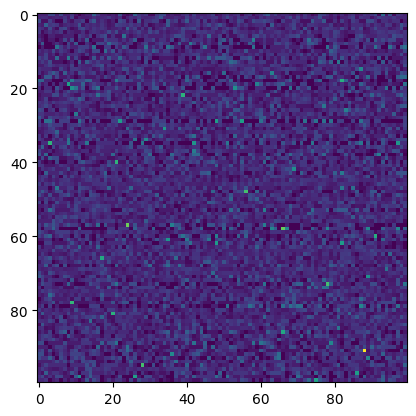

In [47]:
plt.imshow(cls._empp)

In [48]:
peepholes = Peepholes(classifier=cls)

In [49]:
peepholes.get_peepholes(dataloader=ph_dl['val'], verbose=True)


 ---- getting predict probabilities



100%|█████████████████████████████████████████| 157/157 [00:10<00:00, 14.31it/s]


 ---- computing labels probabilities



In [50]:
preds = peepholes._phs

In [51]:
torch.argmax(preds, axis=1)

tensor([0, 0, 0,  ..., 0, 0, 0])

In [52]:
torch.sum(torch.argmax(preds, axis=1)==true_labels['val'])

tensor(158)

In [136]:
k_list = [5, ]
n_list = [10, 20, 30, 50]

df = evaluate_gmm(layer_list, n_list, k_list, n_classes, ph_dl, true_labels)

GMM
Layer: features.24, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 122.47it/s]


Layer: features.24, Peep size: 5, Clusters: 10 Accuracy: 0.0937
Layer: features.28, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 83.76it/s]


Layer: features.28, Peep size: 5, Clusters: 10 Accuracy: 0.0967
Layer: classifier.0, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 308.59it/s]


Layer: classifier.0, Peep size: 5, Clusters: 10 Accuracy: 0.0973
Layer: classifier.3, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 194.84it/s]


Layer: classifier.3, Peep size: 5, Clusters: 10 Accuracy: 0.1654
GMM
Layer: features.24, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 129.25it/s]


Layer: features.24, Peep size: 5, Clusters: 20 Accuracy: 0.097
Layer: features.28, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 132.75it/s]


Layer: features.28, Peep size: 5, Clusters: 20 Accuracy: 0.0974
Layer: classifier.0, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 105.56it/s]


Layer: classifier.0, Peep size: 5, Clusters: 20 Accuracy: 0.1066
Layer: classifier.3, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.92it/s]


Layer: classifier.3, Peep size: 5, Clusters: 20 Accuracy: 0.1689
GMM
Layer: features.24, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 140.42it/s]


Layer: features.24, Peep size: 5, Clusters: 30 Accuracy: 0.1014
Layer: features.28, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 82.13it/s]


Layer: features.28, Peep size: 5, Clusters: 30 Accuracy: 0.1003
Layer: classifier.0, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 97.00it/s]


Layer: classifier.0, Peep size: 5, Clusters: 30 Accuracy: 0.1046
Layer: classifier.3, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.08it/s]


Layer: classifier.3, Peep size: 5, Clusters: 30 Accuracy: 0.1699
GMM
Layer: features.24, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 79.57it/s]


Layer: features.24, Peep size: 5, Clusters: 50 Accuracy: 0.0985
Layer: features.28, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 75.99it/s]


Layer: features.28, Peep size: 5, Clusters: 50 Accuracy: 0.0986
Layer: classifier.0, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 81.56it/s]


Layer: classifier.0, Peep size: 5, Clusters: 50 Accuracy: 0.1004
Layer: classifier.3, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 81.46it/s]

Layer: classifier.3, Peep size: 5, Clusters: 50 Accuracy: 0.1702


In [55]:
layer_list = ['features.14', 'features.24', 'features.28', 'classifier.0', 'classifier.3']

In [56]:
k_list = [5, 9, 50]
n_list = [50, 100, 150] #[10, 20, 30, 50, 70]

df_k, preds_k = evaluate_kmeans(layer_list, n_list, k_list, n_classes, ph_dl, true_labels, return_preds=True)

KMeans
Layer: features.14, Peep size: 5, seed=1819567223


100%|█████████████████████████████████████████| 157/157 [02:22<00:00,  1.10it/s]


Layer: features.14, Peep size: 5, Clusters: 50 Accuracy: 0.0098
Layer: features.24, Peep size: 5, seed=3289370105


100%|█████████████████████████████████████████| 157/157 [00:05<00:00, 29.21it/s]


Layer: features.24, Peep size: 5, Clusters: 50 Accuracy: 0.0101
Layer: features.28, Peep size: 5, seed=1605115326


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 69.41it/s]


Layer: features.28, Peep size: 5, Clusters: 50 Accuracy: 0.0088
Layer: classifier.0, Peep size: 5, seed=881019073


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 67.60it/s]


Layer: classifier.0, Peep size: 5, Clusters: 50 Accuracy: 0.0117
Layer: classifier.3, Peep size: 5, seed=2960059495


100%|█████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


Layer: classifier.3, Peep size: 5, Clusters: 50 Accuracy: 0.1592
KMeans
Layer: features.14, Peep size: 5, seed=1123585609


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 75.24it/s]


Layer: features.14, Peep size: 5, Clusters: 100 Accuracy: 0.0117
Layer: features.24, Peep size: 5, seed=1741284085


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 60.30it/s]


Layer: features.24, Peep size: 5, Clusters: 100 Accuracy: 0.0105
Layer: features.28, Peep size: 5, seed=3686823003


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 116.68it/s]


Layer: features.28, Peep size: 5, Clusters: 100 Accuracy: 0.0075
Layer: classifier.0, Peep size: 5, seed=805244813


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 119.26it/s]


Layer: classifier.0, Peep size: 5, Clusters: 100 Accuracy: 0.01
Layer: classifier.3, Peep size: 5, seed=1406592735


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 78.67it/s]


Layer: classifier.3, Peep size: 5, Clusters: 100 Accuracy: 0.173
KMeans
Layer: features.14, Peep size: 5, seed=2445162370


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 48.86it/s]


Layer: features.14, Peep size: 5, Clusters: 150 Accuracy: 0.0111
Layer: features.24, Peep size: 5, seed=2007679364


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 109.53it/s]


Layer: features.24, Peep size: 5, Clusters: 150 Accuracy: 0.0087
Layer: features.28, Peep size: 5, seed=697905566


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 84.27it/s]


Layer: features.28, Peep size: 5, Clusters: 150 Accuracy: 0.0091
Layer: classifier.0, Peep size: 5, seed=625369271


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 45.98it/s]


Layer: classifier.0, Peep size: 5, Clusters: 150 Accuracy: 0.0118
Layer: classifier.3, Peep size: 5, seed=1140123313


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 105.10it/s]


Layer: classifier.3, Peep size: 5, Clusters: 150 Accuracy: 0.1875
KMeans
Layer: features.14, Peep size: 9, seed=4235135446


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 120.88it/s]


Layer: features.14, Peep size: 9, Clusters: 50 Accuracy: 0.0078
Layer: features.24, Peep size: 9, seed=3991989571


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 39.98it/s]


Layer: features.24, Peep size: 9, Clusters: 50 Accuracy: 0.0095
Layer: features.28, Peep size: 9, seed=1467216988


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 107.56it/s]


Layer: features.28, Peep size: 9, Clusters: 50 Accuracy: 0.0103
Layer: classifier.0, Peep size: 9, seed=2213914063


100%|█████████████████████████████████████████| 157/157 [00:08<00:00, 18.36it/s]


Layer: classifier.0, Peep size: 9, Clusters: 50 Accuracy: 0.0111
Layer: classifier.3, Peep size: 9, seed=4012797727


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 110.30it/s]


Layer: classifier.3, Peep size: 9, Clusters: 50 Accuracy: 0.2144
KMeans
Layer: features.14, Peep size: 9, seed=743683296


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.58it/s]


Layer: features.14, Peep size: 9, Clusters: 100 Accuracy: 0.0104
Layer: features.24, Peep size: 9, seed=602339535


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 46.96it/s]


Layer: features.24, Peep size: 9, Clusters: 100 Accuracy: 0.0104
Layer: features.28, Peep size: 9, seed=3550232767


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 115.31it/s]


Layer: features.28, Peep size: 9, Clusters: 100 Accuracy: 0.0105
Layer: classifier.0, Peep size: 9, seed=3213223042


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 117.60it/s]


Layer: classifier.0, Peep size: 9, Clusters: 100 Accuracy: 0.0126
Layer: classifier.3, Peep size: 9, seed=434697088


100%|█████████████████████████████████████████| 157/157 [00:04<00:00, 37.30it/s]


Layer: classifier.3, Peep size: 9, Clusters: 100 Accuracy: 0.2907
KMeans
Layer: features.14, Peep size: 9, seed=3485692476


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 111.85it/s]


Layer: features.14, Peep size: 9, Clusters: 150 Accuracy: 0.0108
Layer: features.24, Peep size: 9, seed=3460561792


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 77.28it/s]


Layer: features.24, Peep size: 9, Clusters: 150 Accuracy: 0.0104
Layer: features.28, Peep size: 9, seed=143028324


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 44.02it/s]


Layer: features.28, Peep size: 9, Clusters: 150 Accuracy: 0.0109
Layer: classifier.0, Peep size: 9, seed=956114834


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 103.57it/s]


Layer: classifier.0, Peep size: 9, Clusters: 150 Accuracy: 0.0111
Layer: classifier.3, Peep size: 9, seed=2955832244


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 70.20it/s]


Layer: classifier.3, Peep size: 9, Clusters: 150 Accuracy: 0.3151
KMeans
Layer: features.14, Peep size: 50, seed=2192484288


100%|█████████████████████████████████████████| 157/157 [00:07<00:00, 21.72it/s]


Layer: features.14, Peep size: 50, Clusters: 50 Accuracy: 0.01
Layer: features.24, Peep size: 50, seed=1785518532


100%|█████████████████████████████████████████| 157/157 [00:33<00:00,  4.73it/s]


Layer: features.24, Peep size: 50, Clusters: 50 Accuracy: 0.0101
Layer: features.28, Peep size: 50, seed=4111519356


100%|█████████████████████████████████████████| 157/157 [00:04<00:00, 37.73it/s]


Layer: features.28, Peep size: 50, Clusters: 50 Accuracy: 0.01
Layer: classifier.0, Peep size: 50, seed=3595100344


100%|█████████████████████████████████████████| 157/157 [00:04<00:00, 36.63it/s]


Layer: classifier.0, Peep size: 50, Clusters: 50 Accuracy: 0.0126
Layer: classifier.3, Peep size: 50, seed=3971545733


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 96.52it/s]


Layer: classifier.3, Peep size: 50, Clusters: 50 Accuracy: 0.2921
KMeans
Layer: features.14, Peep size: 50, seed=3334872604


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 80.57it/s]


Layer: features.14, Peep size: 50, Clusters: 100 Accuracy: 0.01
Layer: features.24, Peep size: 50, seed=1298637632


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 41.09it/s]


Layer: features.24, Peep size: 50, Clusters: 100 Accuracy: 0.0098
Layer: features.28, Peep size: 50, seed=3507004790


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 101.96it/s]


Layer: features.28, Peep size: 50, Clusters: 100 Accuracy: 0.0125
Layer: classifier.0, Peep size: 50, seed=2048237051


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 78.79it/s]


Layer: classifier.0, Peep size: 50, Clusters: 100 Accuracy: 0.0166
Layer: classifier.3, Peep size: 50, seed=4241023864


100%|█████████████████████████████████████████| 157/157 [00:04<00:00, 36.32it/s]


Layer: classifier.3, Peep size: 50, Clusters: 100 Accuracy: 0.4467
KMeans
Layer: features.14, Peep size: 50, seed=4047369429


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 100.57it/s]


Layer: features.14, Peep size: 50, Clusters: 150 Accuracy: 0.0101
Layer: features.24, Peep size: 50, seed=3124060260


100%|█████████████████████████████████████████| 157/157 [00:04<00:00, 34.78it/s]


Layer: features.24, Peep size: 50, Clusters: 150 Accuracy: 0.0101
Layer: features.28, Peep size: 50, seed=3734035647


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 46.76it/s]


Layer: features.28, Peep size: 50, Clusters: 150 Accuracy: 0.0112
Layer: classifier.0, Peep size: 50, seed=3094025571


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 51.39it/s]


Layer: classifier.0, Peep size: 50, Clusters: 150 Accuracy: 0.0168
Layer: classifier.3, Peep size: 50, seed=3075660189


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 58.42it/s]

Layer: classifier.3, Peep size: 50, Clusters: 150 Accuracy: 0.5069


### GMM

In [209]:
n_classes = 10 if dataset=='CIFAR10' else 100
n_classes

100

In [41]:
layer = 'classifier.0'
n_clusters = 100
peep_size = 10

In [223]:
parser_cv = trim_corevectors
parser_kwargs = {'layer': layer, 'peep_size':peep_size}
cls_kwargs = {'random_state': 42, 'n_init':n_classes, 'max_iter':500} 

cls = GMM(
        nl_classifier = n_clusters,
        nl_model = n_classes,
        parser = parser_cv,
        parser_kwargs = parser_kwargs,
        cls_kwargs = cls_kwargs
        )

In [212]:
cls.fit(dataloader = ph_dl['train'], verbose=True)
cls.compute_empirical_posteriors(verbose=True)


 ---- GMM classifier

Parsing data
Fitting GMM


KeyboardInterrupt: 

In [ ]:
cls.classifier_probabilities(dataloader=ph_dl['val'])

In [ ]:
cls._classifier_probs[0]

In [187]:
_dl = ph_dl['val']
n_samples = len(_dl.dataset)
bs = _dl.batch_size

# Allocate predict probs
_classifier_probs = torch.zeros(n_samples, 100)

for bn, batch in enumerate(tqdm(_dl)):
    data = cls.parser(data = batch, **cls.parser_kwargs)
    n_in = len(data)

    probs = torch.tensor(cls._classifier.predict_proba(data))
    _classifier_probs[bn*bs:bn*bs+n_in] = probs

100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 99.48it/s]


In [207]:
_classifier_probs[0]

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan])

In [198]:
coeff = 1 / ((2 * np.pi) ** (20 / 2))
coeff * torch.exp(-0.5 * distances[0]**2)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=torch.float64)

In [204]:
cls._empp.double() @ torch.exp(-0.5 * distances[0]**2)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], dtype=torch.float64)

In [208]:
torch.sort(torch.argmax(cls._empp, axis=1))

torch.return_types.sort(
values=tensor([ 1,  2,  3,  3,  3,  4,  5,  5,  5,  8,  8,  9,  9, 10, 11, 11, 14, 14,
        15, 17, 17, 18, 20, 21, 21, 22, 23, 23, 24, 24, 24, 26, 28, 29, 29, 29,
        30, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 42, 42, 46, 46, 47, 48, 48,
        50, 52, 56, 56, 58, 61, 61, 63, 65, 66, 66, 66, 68, 68, 69, 71, 73, 74,
        75, 77, 77, 77, 78, 79, 81, 81, 81, 82, 82, 83, 84, 85, 86, 87, 87, 87,
        88, 88, 89, 89, 89, 91, 92, 93, 94, 95]),
indices=tensor([36,  3, 35, 76, 39, 46, 32,  9, 47, 19, 12, 78, 20, 27, 63, 23, 83, 44,
         2, 66, 82, 10, 81, 40,  5, 29,  6, 64, 57, 90,  4, 98, 95, 45, 56, 34,
        68, 49,  1, 31, 61, 92, 94, 84, 22,  8, 33, 24, 37, 67, 51, 70, 41, 62,
        11, 50, 59, 48,  7, 28, 53, 16, 88, 58, 86, 96, 75, 52, 42, 87, 54, 14,
        99, 74, 72, 25, 73, 89, 13, 80, 85, 43, 18, 26, 21, 55, 97, 79, 15, 77,
        30, 91, 17, 93, 71, 60, 38,  0, 69, 65]))

In [199]:
cls._classifier.predict(data)

array([67, 85, 85, 47, 66, 50, 55, 71, 51, 71, 96, 42, 85, 67, 75, 71],
      dtype=int32)

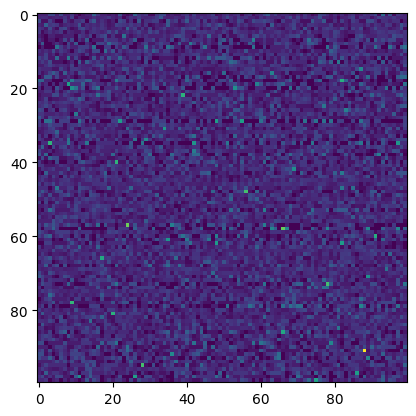

In [47]:
plt.imshow(cls._empp)

In [48]:
peepholes = Peepholes(classifier=cls)

In [49]:
peepholes.get_peepholes(dataloader=ph_dl['val'], verbose=True)


 ---- getting predict probabilities



100%|█████████████████████████████████████████| 157/157 [00:10<00:00, 14.31it/s]


 ---- computing labels probabilities



In [50]:
preds = peepholes._phs

In [51]:
torch.argmax(preds, axis=1)

tensor([0, 0, 0,  ..., 0, 0, 0])

In [52]:
torch.sum(torch.argmax(preds, axis=1)==true_labels['val'])

tensor(158)

In [136]:
k_list = [5, ]
n_list = [10, 20, 30, 50]

df = evaluate_gmm(layer_list, n_list, k_list, n_classes, ph_dl, true_labels)

GMM
Layer: features.24, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 122.47it/s]


Layer: features.24, Peep size: 5, Clusters: 10 Accuracy: 0.0937
Layer: features.28, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 83.76it/s]


Layer: features.28, Peep size: 5, Clusters: 10 Accuracy: 0.0967
Layer: classifier.0, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 308.59it/s]


Layer: classifier.0, Peep size: 5, Clusters: 10 Accuracy: 0.0973
Layer: classifier.3, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:00<00:00, 194.84it/s]


Layer: classifier.3, Peep size: 5, Clusters: 10 Accuracy: 0.1654
GMM
Layer: features.24, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 129.25it/s]


Layer: features.24, Peep size: 5, Clusters: 20 Accuracy: 0.097
Layer: features.28, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 132.75it/s]


Layer: features.28, Peep size: 5, Clusters: 20 Accuracy: 0.0974
Layer: classifier.0, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 105.56it/s]


Layer: classifier.0, Peep size: 5, Clusters: 20 Accuracy: 0.1066
Layer: classifier.3, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 89.92it/s]


Layer: classifier.3, Peep size: 5, Clusters: 20 Accuracy: 0.1689
GMM
Layer: features.24, Peep size: 5


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 140.42it/s]


Layer: features.24, Peep size: 5, Clusters: 30 Accuracy: 0.1014
Layer: features.28, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 82.13it/s]


Layer: features.28, Peep size: 5, Clusters: 30 Accuracy: 0.1003
Layer: classifier.0, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 97.00it/s]


Layer: classifier.0, Peep size: 5, Clusters: 30 Accuracy: 0.1046
Layer: classifier.3, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.08it/s]


Layer: classifier.3, Peep size: 5, Clusters: 30 Accuracy: 0.1699
GMM
Layer: features.24, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 79.57it/s]


Layer: features.24, Peep size: 5, Clusters: 50 Accuracy: 0.0985
Layer: features.28, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 75.99it/s]


Layer: features.28, Peep size: 5, Clusters: 50 Accuracy: 0.0986
Layer: classifier.0, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 81.56it/s]


Layer: classifier.0, Peep size: 5, Clusters: 50 Accuracy: 0.1004
Layer: classifier.3, Peep size: 5


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 81.46it/s]

Layer: classifier.3, Peep size: 5, Clusters: 50 Accuracy: 0.1702


In [55]:
layer_list = ['features.14', 'features.24', 'features.28', 'classifier.0', 'classifier.3'] # CIFAR100

In [56]:
k_list = [5, 9, 50, 100]
n_list = [100, 150, 200] #[10, 20, 30, 50, 70]

df_g, preds_g = evaluate_gmm(layer_list, n_list, k_list, n_classes, ph_dl, true_labels, return_preds=True)

KMeans
Layer: features.14, Peep size: 5, seed=1819567223


100%|█████████████████████████████████████████| 157/157 [02:22<00:00,  1.10it/s]


Layer: features.14, Peep size: 5, Clusters: 50 Accuracy: 0.0098
Layer: features.24, Peep size: 5, seed=3289370105


100%|█████████████████████████████████████████| 157/157 [00:05<00:00, 29.21it/s]


Layer: features.24, Peep size: 5, Clusters: 50 Accuracy: 0.0101
Layer: features.28, Peep size: 5, seed=1605115326


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 69.41it/s]


Layer: features.28, Peep size: 5, Clusters: 50 Accuracy: 0.0088
Layer: classifier.0, Peep size: 5, seed=881019073


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 67.60it/s]


Layer: classifier.0, Peep size: 5, Clusters: 50 Accuracy: 0.0117
Layer: classifier.3, Peep size: 5, seed=2960059495


100%|█████████████████████████████████████████| 157/157 [00:26<00:00,  5.99it/s]


Layer: classifier.3, Peep size: 5, Clusters: 50 Accuracy: 0.1592
KMeans
Layer: features.14, Peep size: 5, seed=1123585609


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 75.24it/s]


Layer: features.14, Peep size: 5, Clusters: 100 Accuracy: 0.0117
Layer: features.24, Peep size: 5, seed=1741284085


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 60.30it/s]


Layer: features.24, Peep size: 5, Clusters: 100 Accuracy: 0.0105
Layer: features.28, Peep size: 5, seed=3686823003


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 116.68it/s]


Layer: features.28, Peep size: 5, Clusters: 100 Accuracy: 0.0075
Layer: classifier.0, Peep size: 5, seed=805244813


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 119.26it/s]


Layer: classifier.0, Peep size: 5, Clusters: 100 Accuracy: 0.01
Layer: classifier.3, Peep size: 5, seed=1406592735


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 78.67it/s]


Layer: classifier.3, Peep size: 5, Clusters: 100 Accuracy: 0.173
KMeans
Layer: features.14, Peep size: 5, seed=2445162370


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 48.86it/s]


Layer: features.14, Peep size: 5, Clusters: 150 Accuracy: 0.0111
Layer: features.24, Peep size: 5, seed=2007679364


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 109.53it/s]


Layer: features.24, Peep size: 5, Clusters: 150 Accuracy: 0.0087
Layer: features.28, Peep size: 5, seed=697905566


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 84.27it/s]


Layer: features.28, Peep size: 5, Clusters: 150 Accuracy: 0.0091
Layer: classifier.0, Peep size: 5, seed=625369271


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 45.98it/s]


Layer: classifier.0, Peep size: 5, Clusters: 150 Accuracy: 0.0118
Layer: classifier.3, Peep size: 5, seed=1140123313


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 105.10it/s]


Layer: classifier.3, Peep size: 5, Clusters: 150 Accuracy: 0.1875
KMeans
Layer: features.14, Peep size: 9, seed=4235135446


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 120.88it/s]


Layer: features.14, Peep size: 9, Clusters: 50 Accuracy: 0.0078
Layer: features.24, Peep size: 9, seed=3991989571


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 39.98it/s]


Layer: features.24, Peep size: 9, Clusters: 50 Accuracy: 0.0095
Layer: features.28, Peep size: 9, seed=1467216988


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 107.56it/s]


Layer: features.28, Peep size: 9, Clusters: 50 Accuracy: 0.0103
Layer: classifier.0, Peep size: 9, seed=2213914063


100%|█████████████████████████████████████████| 157/157 [00:08<00:00, 18.36it/s]


Layer: classifier.0, Peep size: 9, Clusters: 50 Accuracy: 0.0111
Layer: classifier.3, Peep size: 9, seed=4012797727


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 110.30it/s]


Layer: classifier.3, Peep size: 9, Clusters: 50 Accuracy: 0.2144
KMeans
Layer: features.14, Peep size: 9, seed=743683296


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 86.58it/s]


Layer: features.14, Peep size: 9, Clusters: 100 Accuracy: 0.0104
Layer: features.24, Peep size: 9, seed=602339535


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 46.96it/s]


Layer: features.24, Peep size: 9, Clusters: 100 Accuracy: 0.0104
Layer: features.28, Peep size: 9, seed=3550232767


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 115.31it/s]


Layer: features.28, Peep size: 9, Clusters: 100 Accuracy: 0.0105
Layer: classifier.0, Peep size: 9, seed=3213223042


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 117.60it/s]


Layer: classifier.0, Peep size: 9, Clusters: 100 Accuracy: 0.0126
Layer: classifier.3, Peep size: 9, seed=434697088


100%|█████████████████████████████████████████| 157/157 [00:04<00:00, 37.30it/s]


Layer: classifier.3, Peep size: 9, Clusters: 100 Accuracy: 0.2907
KMeans
Layer: features.14, Peep size: 9, seed=3485692476


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 111.85it/s]


Layer: features.14, Peep size: 9, Clusters: 150 Accuracy: 0.0108
Layer: features.24, Peep size: 9, seed=3460561792


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 77.28it/s]


Layer: features.24, Peep size: 9, Clusters: 150 Accuracy: 0.0104
Layer: features.28, Peep size: 9, seed=143028324


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 44.02it/s]


Layer: features.28, Peep size: 9, Clusters: 150 Accuracy: 0.0109
Layer: classifier.0, Peep size: 9, seed=956114834


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 103.57it/s]


Layer: classifier.0, Peep size: 9, Clusters: 150 Accuracy: 0.0111
Layer: classifier.3, Peep size: 9, seed=2955832244


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 70.20it/s]


Layer: classifier.3, Peep size: 9, Clusters: 150 Accuracy: 0.3151
KMeans
Layer: features.14, Peep size: 50, seed=2192484288


100%|█████████████████████████████████████████| 157/157 [00:07<00:00, 21.72it/s]


Layer: features.14, Peep size: 50, Clusters: 50 Accuracy: 0.01
Layer: features.24, Peep size: 50, seed=1785518532


100%|█████████████████████████████████████████| 157/157 [00:33<00:00,  4.73it/s]


Layer: features.24, Peep size: 50, Clusters: 50 Accuracy: 0.0101
Layer: features.28, Peep size: 50, seed=4111519356


100%|█████████████████████████████████████████| 157/157 [00:04<00:00, 37.73it/s]


Layer: features.28, Peep size: 50, Clusters: 50 Accuracy: 0.01
Layer: classifier.0, Peep size: 50, seed=3595100344


100%|█████████████████████████████████████████| 157/157 [00:04<00:00, 36.63it/s]


Layer: classifier.0, Peep size: 50, Clusters: 50 Accuracy: 0.0126
Layer: classifier.3, Peep size: 50, seed=3971545733


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 96.52it/s]


Layer: classifier.3, Peep size: 50, Clusters: 50 Accuracy: 0.2921
KMeans
Layer: features.14, Peep size: 50, seed=3334872604


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 80.57it/s]


Layer: features.14, Peep size: 50, Clusters: 100 Accuracy: 0.01
Layer: features.24, Peep size: 50, seed=1298637632


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 41.09it/s]


Layer: features.24, Peep size: 50, Clusters: 100 Accuracy: 0.0098
Layer: features.28, Peep size: 50, seed=3507004790


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 101.96it/s]


Layer: features.28, Peep size: 50, Clusters: 100 Accuracy: 0.0125
Layer: classifier.0, Peep size: 50, seed=2048237051


100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 78.79it/s]


Layer: classifier.0, Peep size: 50, Clusters: 100 Accuracy: 0.0166
Layer: classifier.3, Peep size: 50, seed=4241023864


100%|█████████████████████████████████████████| 157/157 [00:04<00:00, 36.32it/s]


Layer: classifier.3, Peep size: 50, Clusters: 100 Accuracy: 0.4467
KMeans
Layer: features.14, Peep size: 50, seed=4047369429


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 100.57it/s]


Layer: features.14, Peep size: 50, Clusters: 150 Accuracy: 0.0101
Layer: features.24, Peep size: 50, seed=3124060260


100%|█████████████████████████████████████████| 157/157 [00:04<00:00, 34.78it/s]


Layer: features.24, Peep size: 50, Clusters: 150 Accuracy: 0.0101
Layer: features.28, Peep size: 50, seed=3734035647


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 46.76it/s]


Layer: features.28, Peep size: 50, Clusters: 150 Accuracy: 0.0112
Layer: classifier.0, Peep size: 50, seed=3094025571


100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 51.39it/s]


Layer: classifier.0, Peep size: 50, Clusters: 150 Accuracy: 0.0168
Layer: classifier.3, Peep size: 50, seed=3075660189


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 58.42it/s]

Layer: classifier.3, Peep size: 50, Clusters: 150 Accuracy: 0.5069


### results with CIFAR100

In [60]:
df_k.unstack(level='layer').unstack(level='peep_size')

accuracy                                               \
layer      classifier.0                 classifier.3                   
peep_size            5       9       50           5       9       50   
n_clusters                                                             
50               0.0117  0.0111  0.0126       0.1592  0.2144  0.2921   
100              0.0100  0.0126  0.0166       0.1730  0.2907  0.4467   
150              0.0118  0.0111  0.0168       0.1875  0.3151  0.5069   

                                                                    \
layer      features.14                 features.24                   
peep_size           5       9       50          5       9       50   
n_clusters                                                           
50              0.0098  0.0078  0.0100      0.0101  0.0095  0.0101   
100             0.0117  0.0104  0.0100      0.0105  0.0104  0.0098   
150             0.0111  0.0108  0.0101      0.0087  0.0104  0.0101   

                                        
layer      features.28                  
peep_size           5       9       50  
n_clusters                              
50              0.0088  0.0103  0.0100  
100             0.0075  0.0105  0.0125  
150             0.0091  0.0109  0.0112

In [63]:
preds_k.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 45 entries, ('features.14', np.int64(50), np.int64(5)) to ('classifier.3', np.int64(150), np.int64(50))
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   labels_pred  45 non-null     object
dtypes: object(1)
memory usage: 2.1+ KB


In [68]:
preds_k.xs(('classifier.3', 150, 50)).values

array([tensor([91, 18, 57,  ..., 21, 97, 45])], dtype=object)

In [71]:
from collections import Counter

In [130]:
np.sum(x==tl)/len(tl)

np.float64(0.6283351120597652)

In [132]:
tl = np.array(true_labels['val'])[decisions['val']]
true_count = Counter(tl)
true_unique_labels = list(true_count.keys())
true_frequencies = list(true_count.values())

In [129]:
len(x)

7496

In [148]:
x = np.array(preds_k.xs(('features.14', 100, 5)).values[0])[decisions['val']]

label_counts = Counter(x)

unique_labels = list(label_counts.keys())
frequencies = list(label_counts.values())

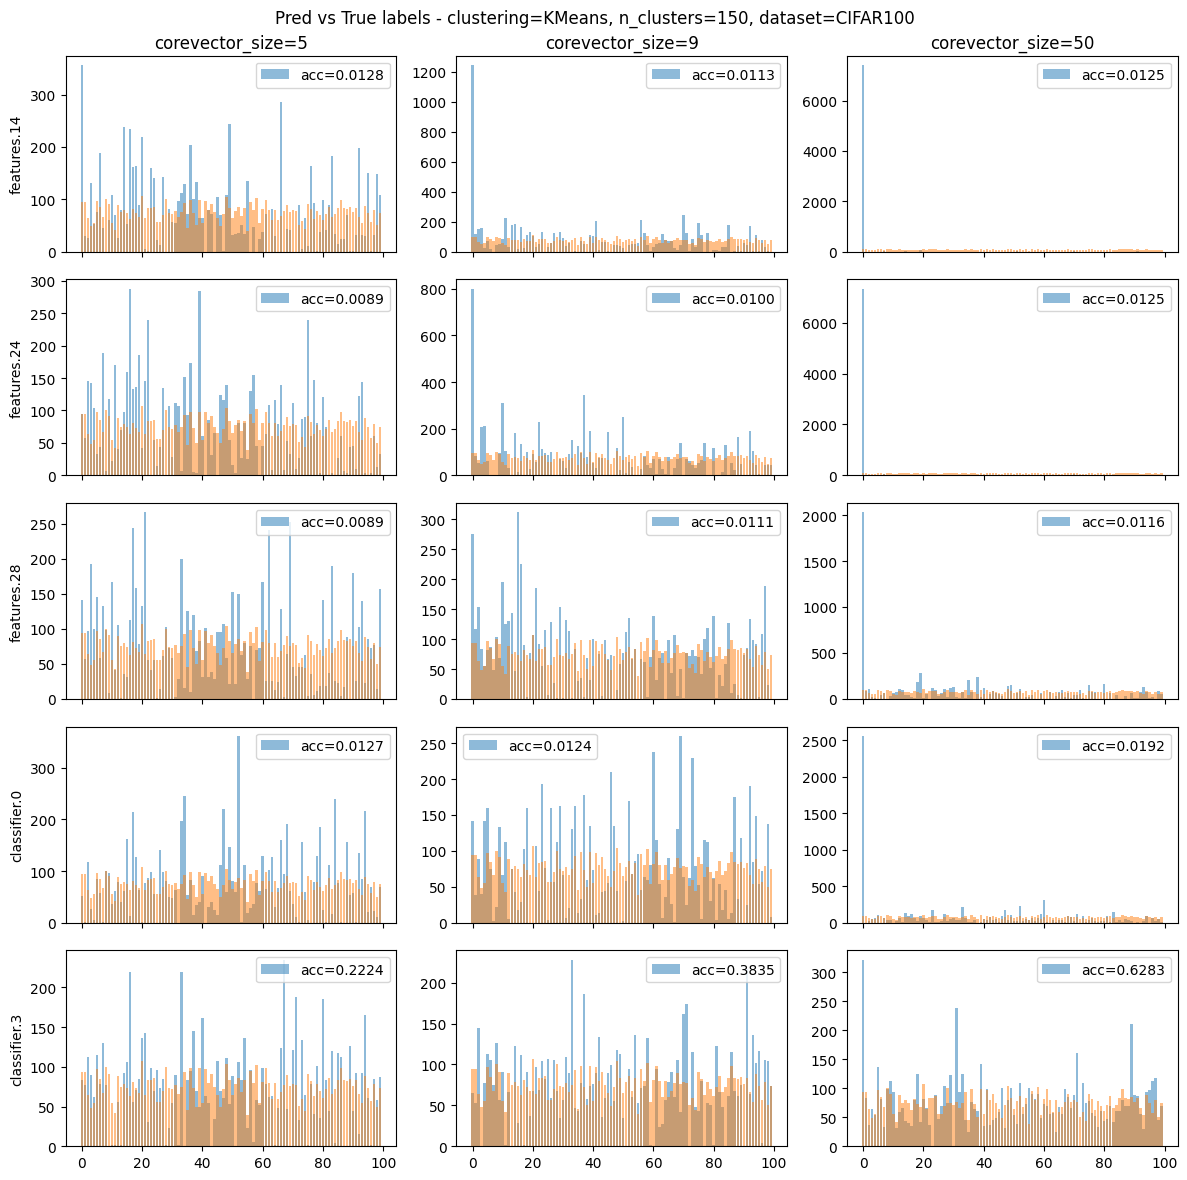

In [166]:
n = 150 # fix n_clusters
algo = 'KMeans'

fig, axs = plt.subplots(len(layer_list), len(k_list), sharex=True, figsize=(12, 12))

title_ = f'Pred vs True labels - clustering={algo}, n_clusters={n}, dataset={dataset}'
fig.suptitle(title_)

for i, layer in enumerate(layer_list):
    axs[i, 0].set_ylabel(layer)
    for j, k in enumerate(k_list):

        axs[0, j].set_title(f'corevector_size={k}')

        x = np.array(preds_k.xs((layer, n, k)).values[0])[decisions['val']]

        label_counts = Counter(x)
        
        unique_labels = list(label_counts.keys())
        frequencies = list(label_counts.values())

        acc_correct = np.sum(x==tl)/len(tl)

        axs[i, j].bar(unique_labels, frequencies, alpha=0.5, label=f'acc={acc_correct:.4f}')
        axs[i, j].bar(true_unique_labels, true_frequencies, alpha=0.5)

        axs[i, j].legend()

plt.tight_layout()
plt.savefig(title_+'.png')

### results with CIFAR10

In [141]:
df.unstack(level='layer')

accuracy                                     
layer                classifier.0 classifier.3 features.24 features.28
n_clusters peep_size                                                  
10         5               0.0973       0.1654      0.0937      0.0967
20         5               0.1066       0.1689      0.0970      0.0974
30         5               0.1046       0.1699      0.1014      0.1003
50         5               0.1004       0.1702      0.0985      0.0986

In [144]:
print('seed=42')
df_k.unstack(level='layer').unstack(level='peep_size')

seed=42


accuracy                                               \
layer      classifier.0                 classifier.3                   
peep_size            5       9       50           5       9       50   
n_clusters                                                             
10               0.0982  0.1042  0.1014       0.1603  0.1704  0.1726   
20               0.1058  0.1018  0.1035       0.1672  0.1730  0.1767   
30               0.1016  0.1012  0.1005       0.1666  0.1744  0.1747   
50               0.1012  0.1011  0.0994       0.1678  0.1753  0.1751   
70               0.1013  0.1073  0.0976       0.1687  0.1754  0.1744   

                                                                    
layer      features.24                 features.28                  
peep_size           5       9       50          5       9       50  
n_clusters                                                          
10              0.0994  0.1021  0.0965      0.1054  0.1007  0.1061  
20              0.0997  0.1041  0.0996      0.1029  0.1012  0.0939  
30              0.0997  0.0989  0.1003      0.1005  0.1024  0.0986  
50              0.1002  0.0958  0.0986      0.1027  0.0970  0.0960  
70              0.1000  0.0982  0.0963      0.0997  0.1002  0.0998

In [151]:
print('Random seeds')
df_k2.unstack(level='layer').unstack(level='peep_size')

Random seeds


accuracy                                               \
layer      classifier.0                 classifier.3                   
peep_size            5       9       50           5       9       50   
n_clusters                                                             
10               0.1007  0.1047  0.1014       0.1601  0.1705  0.1726   
20               0.1033  0.1004  0.0981       0.1648  0.1734  0.1767   
30               0.1015  0.0981  0.0987       0.1670  0.1742  0.1742   
50               0.1026  0.0977  0.1021       0.1686  0.1757  0.1748   
70               0.1054  0.0976  0.1018       0.1685  0.1726  0.1731   

                                                                    
layer      features.24                 features.28                  
peep_size           5       9       50          5       9       50  
n_clusters                                                          
10              0.1000  0.0991  0.0965      0.1044  0.0966  0.1025  
20              0.1010  0.1006  0.0994      0.0965  0.1044  0.0974  
30              0.1016  0.1001  0.1026      0.0950  0.1033  0.0981  
50              0.1037  0.1007  0.1008      0.1004  0.1013  0.1025  
70              0.1035  0.0998  0.1007      0.1018  0.0956  0.1008

## Caccia le immaginine

In [18]:
from clustering.utils import get_unique_values

In [14]:
abs_path = '/srv/newpenny/XAI/generated_data'

In [15]:
algorithm = 'gmm'
dataset = 'CIFAR100'
dnn_model = 'vgg16'

### Load peephole scores

In [109]:
algorithm = 'gmm'
# init the peephole container if not existing
new_peep_dir = 'clustering/peepholes' 
new_peep_path = os.path.join(abs_path, new_peep_dir) 
new_peep_tensor_dict_path = os.path.join(new_peep_path, f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}.memmap')

if os.path.exists(new_peep_tensor_dict_path):
    print('New peepholes results already present')
    peephole_scores = TensorDict.load_memmap(new_peep_tensor_dict_path)
else:
    print('Initializing peephole container')
    peephole_scores = TensorDict({}, batch_size=[])

ps_gmm = peephole_scores

New peepholes results already present


In [110]:
algorithm = 'kmeans'
# init the peephole container if not existing
new_peep_dir = 'clustering/peepholes' 
new_peep_path = os.path.join(abs_path, new_peep_dir) 
new_peep_tensor_dict_path = os.path.join(new_peep_path, f'algorithm={algorithm}_dataset={dataset}_dnn={dnn_model}.memmap')

if os.path.exists(new_peep_tensor_dict_path):
    print('New peepholes results already present')
    peephole_scores = TensorDict.load_memmap(new_peep_tensor_dict_path)
else:
    print('Initializing peephole container')
    peephole_scores = TensorDict({}, batch_size=[])

ps_kmeans = peephole_scores

New peepholes results already present


In [24]:
scores = {'results_tensordict' : peephole_scores}
hps = get_unique_values(**scores)

In [44]:
k_list, n_list, splits, layers = hps

### Get true labels

In [16]:
splits = ['val']

In [17]:
from tqdm import tqdm

In [122]:
true_labels = {}
decisions = {}

for split in splits:
    true_labels[split] = []
    decisions[split] = []

    for batch in tqdm(ph_dl[split]):
        peepholes = batch['coreVectors']
        labels = batch['label']
        decision_results = batch['result']

        true_labels[split].append(labels)
        decisions[split].append(decision_results.bool())

    true_labels[split] = torch.cat(true_labels[split], dim=0)
    decisions[split] = torch.cat(decisions[split], dim=0)

100%|█████████████████████████████████████████| 157/157 [00:07<00:00, 20.06it/s]


### Check accuracy

In [55]:
import pandas as pd

In [81]:
tl==lp

tensor([False, False, False,  ..., False, False, False])

In [112]:
acc = {}
idxs = {}

for k in tqdm(k_list):
    for n in n_list:
        for split in splits:
            tl = true_labels[split]
            
            for l in layers:
                lp = torch.argmax(peephole_scores[k][n][split][l], axis=1)
                res = np.float64(torch.sum(tl==lp) / len(tl))

                acc[(k, n, split, l)] = res

                eq_idx = torch.nonzero(tl==lp, as_tuple=False).squeeze()
                idxs[(k, n, split, l)] = eq_idx

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 30.50it/s]


In [399]:
# solo val 
split = 'val'
tl = true_labels[split]
peephole_scores = ps_gmm
acc_gmm = {}
top_acc_gmm = {}

idxs_gmm = {}
top_idxs_gmm = {}

for k in tqdm(k_list):
    for n in n_list:            
            for l in layers:
                scores = ps_gmm[k][n][split][l]
                
                lp = torch.argmax(scores, axis=1)
                # std acc
                res = np.float64(torch.sum(tl==lp) / len(tl))
                acc_gmm[(k, n, l)] = res
                eq_idx = torch.nonzero(tl==lp, as_tuple=False).squeeze()
                idxs_gmm[(k, n, l)] = eq_idx
                # top acc
                _, top_idxs = torch.topk(scores, 10, dim=1)
                top_correct = (tl.unsqueeze(1)==top_idxs).any(dim=1)
                top_acc = top_correct.float().mean().item()
                top_idxs_gmm[(k, n, l)] = top_acc

                

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.08it/s]


In [400]:
top_idxs_gmm

{('100', '100', 'features.7'): 0.09920000284910202,
 ('100', '100', 'features.14'): 0.10279999673366547,
 ('100', '100', 'features.24'): 0.09480000287294388,
 ('100', '100', 'features.26'): 0.09679999947547913,
 ('100', '100', 'features.28'): 0.09610000252723694,
 ('100', '100', 'classifier.0'): 0.8463000059127808,
 ('100', '100', 'classifier.3'): 0.14239999651908875,
 ('100', '150', 'features.7'): 0.09489999711513519,
 ('100', '150', 'features.14'): 0.09830000251531601,
 ('100', '150', 'features.24'): 0.09870000183582306,
 ('100', '150', 'features.26'): 0.10130000114440918,
 ('100', '150', 'features.28'): 0.10649999976158142,
 ('100', '150', 'classifier.0'): 0.8310999870300293,
 ('100', '150', 'classifier.3'): 0.14669999480247498,
 ('100', '200', 'features.7'): 0.10000000149011612,
 ('100', '200', 'features.14'): 0.09740000218153,
 ('100', '200', 'features.24'): 0.09929999709129333,
 ('100', '200', 'features.26'): 0.10270000249147415,
 ('100', '200', 'features.28'): 0.1030000001192092

In [114]:
# solo val 
split = 'val'
tl = true_labels[split]
peephole_scores = ps_kmeans
acc_kmeans = {}
idxs_kmeans = {}

for k in tqdm(k_list):
    for n in n_list:            
            for l in layers:
                scores = ps_kmeans[k][n][split][l]
                lp = torch.argmax(scores, axis=1)
                res = np.float64(torch.sum(tl==lp) / len(tl))

                acc_kmeans[(k, n, l)] = res

                eq_idx = torch.nonzero(tl==lp, as_tuple=False).squeeze()
                idxs_kmeans[(k, n, l)] = eq_idx

100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/it]


In [387]:
true_labels['val']

tensor([44., 18., 83.,  ..., 44., 42., 45.])

In [373]:
n_list

['100', '150', '200', '50']

In [303]:
layers = [
    'features.7',
    'features.14',
     'features.24',
     'features.26',
     'features.28',
     'classifier.0',
     'classifier.3', ]

In [406]:
# idx_prova = 9478
idx_prova = 151
k_ = k_list[-1]
n_ = n_list[2]
split = 'val'

t1 = []
t2 = []
t3 = []

for l in layers:
    # tensor = ps_kmeans[k_][n_][split][l][idx_prova]
    # if idx_prova in idxs_kmeans[(k_, n_, l)]:
    tensor = ps_gmm[k_][n_][split][l][idx_prova]
    if idx_prova in idxs_gmm[(k_, n_, l)]:
        print(f'{idx_prova} present for {l}')
    t1.append(tensor)
    t2.append(tensor**0.5)
    t3.append(tensor**2)

pc1 = torch.stack(t1)
pc2 = torch.stack(t2)
pc3 = torch.stack(t3)

# pc.shape

151 present for features.7
151 present for features.14
151 present for classifier.0


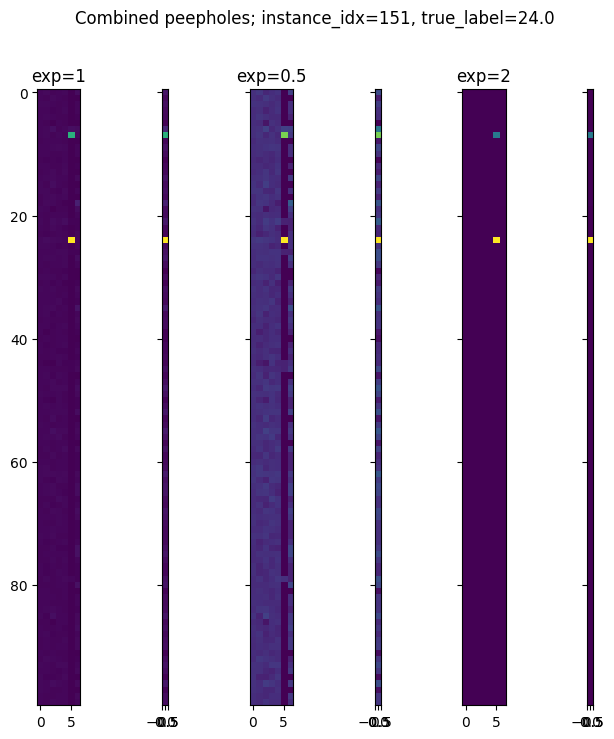

In [381]:
fig, axs = plt.subplots(1, 6, sharey=True, figsize=(8, 8))

fig.suptitle(f"Combined peepholes; instance_idx={idx_prova}, true_label={true_labels['val'][idx_prova]}")

axs[0].imshow(pc1.T)
axs[0].set_title('exp=1')
axs[1].imshow(torch.sum(pc1, axis=0).reshape(-1, 1))

axs[2].imshow(pc2.T)
axs[2].set_title('exp=0.5')
axs[3].imshow(torch.sum(pc2, axis=0).reshape(-1, 1))

axs[4].imshow(pc3.T)
axs[4].set_title('exp=2')
axs[5].imshow(torch.sum(pc3, axis=0).reshape(-1, 1))

plt.show()

In [309]:
true_labels['val'][idx_prova]

tensor(20.)

In [171]:
idxs_kmeans[(k, n, layers[2])]

tensor([  76,  463,  547,  604,  647,  844,  877,  926,  997, 1026, 1029, 1077,
        1271, 1281, 1334, 1574, 1687, 1717, 1877, 2335, 2645, 2759, 2852, 2902,
        3066, 3124, 3259, 3318, 3407, 3445, 3496, 3518, 3607, 3688, 3696, 3768,
        3820, 3906, 3941, 3998, 4091, 4099, 4233, 4365, 4462, 4503, 4619, 4838,
        4875, 5425, 5610, 5791, 5961, 6202, 6396, 6617, 6621, 6660, 6667, 6701,
        6778, 6852, 6913, 7086, 7289, 7329, 7514, 7583, 7716, 7787, 7813, 7860,
        8005, 8152, 8197, 8234, 8380, 8660, 8734, 8737, 8747, 8821, 8840, 8844,
        8987, 9098, 9104, 9162, 9253, 9450, 9816, 9954])

In [201]:
k, n, layers

('70',
 '50',
 ['classifier.0',
  'classifier.3',
  'features.14',
  'features.24',
  'features.26',
  'features.28',
  'features.7'])

In [205]:
from collections import Counter

In [227]:
k_ = k_list[0]
n_ = n_list[0]
l_ = 'classifier.0'

idx_counter = Counter()

for key, indices in idxs_kmeans.items():
    k, n, l = key
    # if k==k_ and n==n_:
    if l==l_:
        idx_counter.update(list(indices))

num_configs = sum(1 for key in idxs_kmeans.keys() if key[2]==l_)#if key[0]==k_ and key[1]==n_)

common_idx = [index for index, count in idx_counter.items() if count==num_configs]

In [225]:
len(idxs_kmeans[(k_, n_, l_)])

4204

In [226]:
len(idxs_gmm[(k_, n_, l_)])

3946

In [232]:
a = idxs_kmeans[(k_, n_, layers[0])]
b = idxs_kmeans[(k_, n_, layers[1])]

cmn = []

for lb in a:
    if lb in b:
        cmn.append(lb)

In [233]:
len(cmn)

235

In [244]:
a = idxs_kmeans[(k_, n_, layers[2])]
b = idxs_kmeans[(k_, n_, layers[3])]

cmn = []

for lb in a:
    if lb in b:
        cmn.append(lb)

In [245]:
cmn

[tensor(419),
 tensor(1574),
 tensor(3212),
 tensor(4806),
 tensor(4921),
 tensor(7822),
 tensor(8259)]

In [246]:
a = idxs_kmeans[(k_, n_, layers[3])]
b = idxs_kmeans[(k_, n_, layers[4])]

cmn = []

for lb in a:
    if lb in b:
        cmn.append(lb)

In [247]:
cmn

[tensor(1331),
 tensor(1390),
 tensor(1434),
 tensor(1574),
 tensor(7097),
 tensor(7166),
 tensor(7822),
 tensor(8588),
 tensor(8788)]

In [248]:
a = idxs_kmeans[(k_, n_, layers[4])]
b = idxs_kmeans[(k_, n_, layers[5])]

cmn = []

for lb in a:
    if lb in b:
        cmn.append(lb)

In [249]:
cmn

[tensor(1331),
 tensor(2335),
 tensor(2481),
 tensor(2747),
 tensor(4743),
 tensor(5700),
 tensor(5961),
 tensor(7097),
 tensor(7822),
 tensor(7931),
 tensor(8298),
 tensor(8788)]

In [250]:
a = idxs_kmeans[(k_, n_, layers[4])]
b = idxs_kmeans[(k_, n_, layers[6])]

cmn = []

for lb in a:
    if lb in b:
        cmn.append(lb)

In [253]:
a

tensor([ 134,  267,  466,  572,  609,  664,  665,  672,  747,  987,  997, 1109,
        1187, 1247, 1281, 1331, 1345, 1390, 1434, 1497, 1574, 1687, 1751, 1797,
        1830, 1873, 2292, 2329, 2335, 2481, 2747, 2808, 2832, 2960, 3020, 3459,
        3474, 3565, 3613, 3675, 3792, 3851, 3875, 3998, 4056, 4465, 4649, 4743,
        4871, 4939, 5139, 5150, 5481, 5700, 5961, 6213, 6443, 6839, 6907, 6958,
        6970, 7041, 7097, 7166, 7479, 7514, 7515, 7551, 7822, 7931, 8158, 8197,
        8298, 8352, 8519, 8546, 8588, 8734, 8737, 8788, 8812, 8837, 9289, 9313,
        9320, 9915])

In [124]:
acc_series = pd.Series(acc_kmeans)
acc_df_kmeans = acc_series.to_frame(name='accuracy')
# acc_df.index.names = ['k', 'n', 'split', 'l']
acc_df_kmeans.index.names = ['k', 'n', 'l']
acc_df_kmeans = acc_df_kmeans.unstack(level='l')

In [138]:
idxmax_kmeans = pd.Series(acc_df_kmeans.idxmax())
idxmax_kmeans['accuracy', 'classifier.0']

('70', '200')

In [158]:
acc_df_kmeans.style.background_gradient(cmap='YlOrRd', axis=1)

In [125]:
acc_series = pd.Series(acc_gmm)
acc_df_gmm = acc_series.to_frame(name='accuracy')
# acc_df.index.names = ['k', 'n', 'split', 'l']
acc_df_gmm.index.names = ['k', 'n', 'l']
acc_df_gmm = acc_df_gmm.unstack(level='l')

In [139]:
idxmax_gmm = pd.Series(acc_df_gmm.idxmax())
idxmax_gmm['accuracy', 'classifier.0']

('50', '200')

In [153]:
acc_df_gmm.style.background_gradient(cmap='YlOrRd', axis=1)

In [80]:
acc_df_unstacked.loc[('100', '100')]

          l             split
accuracy  classifier.0  train    0.444150
                        val      0.394600
          classifier.3  train    0.055775
                        val      0.038900
          features.14   train    0.024125
                        val      0.010200
          features.24   train    0.023900
                        val      0.010800
          features.26   train    0.023650
                        val      0.011500
          features.28   train    0.023650
                        val      0.010000
          features.7    train    0.022450
                        val      0.009100
Name: (100, 100), dtype: float64

In [83]:
peephole_scores[k][n]['val'][l]

MemoryMappedTensor([[0.0174, 0.0050, 0.0074,  ..., 0.0074, 0.0124, 0.0199],
                    [0.0098, 0.0073, 0.0073,  ..., 0.0098, 0.0098, 0.0073],
                    [0.0098, 0.0073, 0.0073,  ..., 0.0098, 0.0098, 0.0073],
                    ...,
                    [0.0087, 0.0089, 0.0106,  ..., 0.0109, 0.0106, 0.0075],
                    [0.0068, 0.0134, 0.0096,  ..., 0.0088, 0.0105, 0.0081],
                    [0.0041, 0.0174, 0.0041,  ..., 0.0088, 0.0077, 0.0090]])

#

# Current stuff

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ['SCIPY_USE_PROPACK'] = "True"
 
threads = "64"
os.environ["OMP_NUM_THREADS"] = threads
os.environ["OPENBLAS_NUM_THREADS"] = threads
os.environ["MKL_NUM_THREADS"] = threads
os.environ["VECLIB_MAXIMUM_THREADS"] = threads
os.environ["NUMEXPR_NUM_THREADS"] = threads

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
 # torchvision.models.vision_transformer.VisionTransformer

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# not mandatory
import io
from PIL import Image
from tqdm import tqdm

## Utils

Define transforms and load datasets

In [6]:
data_dir = '/srv/newpenny/dataset'

In [7]:
def get_dataset_config(dataset):
    dataset_config = {
        'CIFAR10': {'num_classes': 10, 
                    'input_ch': 3, 
                    'means': (0.424, 0.415, 0.384), 
                    'stds': (0.283, 0.278, 0.284)},
        
        'CIFAR100': {'num_classes': 100, 
                     'input_ch': 3, 
                     'means': (0.438, 0.418, 0.377), 
                     'stds': (0.300, 0.287, 0.294)},
        
        'ImageNet': {'num_classes': 1000, 
                     'input_ch': 3,
                     'means': [0.485, 0.456, 0.406],
                     'stds': [0.229, 0.224, 0.225]}
    }
    return dataset_config

In [8]:
# def load_data(**kwargs):
def load_data(dataset, split, augment=False, shuffle_train=False, batch_size=64, num_workers=8, seed=42, data_dir='/srv/newpenny/dataset'):
    '''
    dataset (str): choices=['CIFAR10', CIFAR100', 'ImageNet']
    '''
    dc = get_dataset_config(dataset)

    means_ = dc[dataset]['means']
    stds_ = dc[dataset]['stds']
   
    if augment and split=='train': # acts only on the training set
        transform = transforms.Compose([
            #transforms.Grayscale(num_output_channels=3),
            transforms.Resize((256, 256)),
            transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
            transforms.CenterCrop((224, 224)),
            #transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(means_, stds_)
        ])
    else:
        transform = transforms.Compose([
            #transforms.Grayscale(num_output_channels=3),
            transforms.Resize((256, 256)),
            transforms.CenterCrop((224, 224)),
            #transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(means_, stds_)
        ])
          
    if dataset=='ImageNet':
        # NB. the loader doesn't work for the 'test' split
        data_path = os.path.join(data_dir, 'imagenet-1k/data')
        data = torchvision.datasets.__dict__[dataset](root=data_path, 
                                                      split=split, 
                                                      transform=transform)
    elif dataset.startswith('CIFAR'):
        data_path = os.path.join(data_dir, dataset)
        if split!='test': # data for train and val
            data = torchvision.datasets.__dict__[dataset](root=data_path, 
                                                        train=True, 
                                                        transform=transform, 
                                                        download=True)
        else:
            data = torchvision.datasets.__dict__[dataset](root=data_path, 
                                                        train=False, 
                                                        transform=transform, 
                                                        download=True)

    if split=='test':
        loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    else:
        # split the dataset into train and validation sets
        train_size = int(0.8 * len(data))
        val_size = len(data) - train_size
        generator = torch.Generator().manual_seed(42)
        train_data, val_data = random_split(data, [train_size, val_size], generator=generator)
        if split=='train':
            loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_train, num_workers=num_workers)
        else:
            loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return loader

Superclasses

## Load data

In [11]:
dataset = 'CIFAR100'

In [11]:
train_loader = load_data(dataset, "train", augment=False)
val_loader = load_data(dataset, "val")

Files already downloaded and verified
Files already downloaded and verified


In [12]:
num_classes = len(train_loader.dataset.dataset.classes)
num_classes

100

## Load Model

Load the pretrained model

In [8]:
model_name = 'vgg16' #'resnet50', 'vit_b_16'

In [14]:
if model_name == 'resnet50':
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1
elif model_name == 'vgg16':
    weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1
elif model_name == 'vit_b_16':
    weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1

model = torchvision.models.__dict__[model_name](weights=weights)

Check the architecture of the model

In [15]:
# model

Model parameters are saved in a `state_dict`

In [ ]:
# model.state_dict()

You can access the keys of the `state_dict` to get the names of layers with parameters (this can be useful to identify layer names and allow for customization)

In [ ]:
model.state_dict().keys()

Change shape of last layer if needed

In [16]:
n_classes = len(train_loader.dataset.dataset.classes)

if model_name == 'resnet50':
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, n_classes)
elif model_name == 'vgg16':
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = torch.nn.Linear(in_features, n_classes)
elif model_name == 'vit_b_16':
    in_features = model.heads.head.in_features
    model.heads.head = torch.nn.Linear(in_features, n_classes)

## Training with early stopping and learning rate scheduling
The choice of the parameters reported below strongly affects the quality of the training process. Decomment to try different settings. You will need to find a proper combination to obtain a model performing with desirable properties &#128522;

### Parameter settings

Number of epochs choice

In [14]:
num_epochs = 100

Loss function and optimizer initialization

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
initial_lr = 0.001
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=1e-4) # more computationally intensive

Early stopping parameters

In [17]:
early_stopping_patience = 10

Learning rate scheduling\
Notes on usage:
* Schedulers like `StepLR`: Decay the learning rate at regular intervals, regardless of validation performance. They are simpler and can be effective for general tasks.
* `ReduceLROnPlateau`: Adapts the learning rate based on validation loss, which can be especially useful in fine-tuning tasks.

In [18]:
#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

lr_patience = 5
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=lr_patience)

You can choose the performance metric you want to optimize during training (typically, accuracy)

In [19]:
def accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)  # get the class index with the highest probability
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    return correct / total

GPU selection

In [20]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 1
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [21]:
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

### Training loop

In [ ]:
patience_counter = 0
best_val_loss = float('inf')

tl = []
vl = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for data in tqdm(train_loader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()        
        
        correct_predictions += accuracy(outputs, targets) * targets.size(0)
        total_predictions += targets.size(0)

    # compute validation loss
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():
        for data in val_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            val_correct_predictions += accuracy(outputs, targets) * targets.size(0)
            val_total_predictions += targets.size(0)
            
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    tl.append(train_loss)
    vl.append(val_loss)
    
    train_accuracy = (correct_predictions / total_predictions) * 100
    val_accuracy = (val_correct_predictions / val_total_predictions) * 100
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')
    
    # early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping: Validation loss hasn't improved for", early_stopping_patience, "epochs.")
            break

    # step the scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(val_loss)
    else:
        scheduler.step()

    current_lr = scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else optimizer.param_groups[0]['lr']
    print(f'Current lr: {current_lr:.6f}')

 98%|████████████████████████████████████████ | 611/625 [05:14<00:07,  1.97it/s]

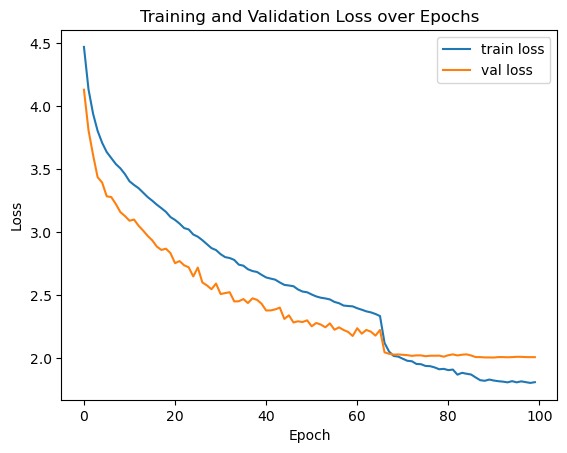

In [23]:
plt.figure()
plt.plot(tl, label='train loss')
plt.plot(vl, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

## Model checkpoint

Define paths

In [9]:
models_dir = '/srv/newpenny/XAI/models'

Add your initials to model name, e.g.:
```python
my_initials = 'LM'
model_path = f'{my_initials}_etc.pth'

In [12]:
my_initials = 'LM' # use yours!
model_name =  model_name # should be already defined
dataset_name = dataset # should be already defined
other_params = 'augment=True_optim=SGD_scheduler=LROnPlateau' # 'make_string_of_other_relevant_params' # can be optimizer, epochs, final lr...

path = f'{my_initials}_model={model_name}_dataset={dataset_name}_{other_params}.pth'
model_path = os.path.join(models_dir, path)

### Saving

#### Basic version: `model.state_dict()` only

Remember that `model.state_dict()` will contain all parameters learned after training

In [ ]:
# decomment to save
# torch.save(model.state_dict(), model_path)

You can then load the learned parameters

In [ ]:
# model = Net() # instantiate the kind of model
# model.load_state_dict(torch.load(model_path, weights_only=True)) # load saved parameters (weights and biases)

#### Checkpoint with info

In [ ]:
checkpoint = {
    'state_dict' : model.state_dict(),
    'epoch': epoch,
    'initial_lr' : initial_lr,
    'final_lr': current_lr,
    'train_accuracy': train_accuracy,
    'val_accuracy': val_accuracy
}

Eventually add a loss plot for quick visualization of the training process

In [ ]:
plt.figure()
plt.plot(tl, label='train loss')
plt.plot(vl, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

buf = io.BytesIO()
plt.savefig(buf, format='PNG')
buf.seek(0)
checkpoint['loss_plot'] = buf.getvalue() 
plt.close()

In [ ]:
# decomment to save
#torch.save(checkpoint, model_path)

### Loading

You can then load the learned parameters

In [19]:
# model = Net() # decomment and instantiate the kind of model you want
checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint['state_dict']) # load saved parameters (weights and biases)

/tmp/ipykernel_75454/2966784621.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')


<All keys matched successfully>

If you saved a loss plot as suggested above:

In [19]:
# access the image bytes and display it
image_bytes = checkpoint['loss_plot']
image = Image.open(io.BytesIO(image_bytes))
image.show()  # this will open the image in the default image viewer

In [ ]:
# alternatively, display the image inline (if in a notebook or interactive environment)
plt.imshow(image)
plt.axis('off')
plt.show()

## Test model

In [20]:
def accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)  # get the class index with the highest probability
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    return correct / total

GPU selection

In [11]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 1
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [22]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
test_loader = load_data(dataset, split='test')

Files already downloaded and verified


In [25]:
data_loader = val_loader

In [26]:
model.eval()

correct_predictions = 0
total_predictions = 0
true_labels = []
pred_labels = []

with torch.no_grad():
    for data in tqdm(data_loader):
        inputs, targets = data
        true_labels.append(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        pred_labels.append(predicted.cpu())
        
        correct_predictions += accuracy(outputs, targets) * targets.size(0)
        total_predictions += targets.size(0)

acc = (correct_predictions / total_predictions) * 100
print(f'accuracy: {acc}')

100%|█████████████████████████████████████████| 157/157 [00:08<00:00, 18.12it/s]

accuracy: 95.53


In [27]:
true_labels = torch.cat(true_labels, axis=0)
pred_labels = torch.cat(pred_labels, axis=0)

In [28]:
true_labels

tensor([95, 96, 78,  ..., 11, 36, 78])

In [6]:
superclass_mapping = {
    "aquatic mammals": [4, 30, 55, 72, 95],
    "fish": [1, 32, 67, 73, 91],
    "flowers": [54, 62, 70, 82, 92],
    "food containers": [9, 10, 16, 28, 61],
    "fruit and vegetables": [0, 51, 53, 57, 83],
    "household electrical devices": [22, 39, 40, 86, 87],
    "household furniture": [5, 20, 25, 84, 94],
    "insects": [6, 7, 14, 18, 24],
    "large carnivores": [3, 42, 43, 88, 97],
    "large man-made outdoor things": [12, 17, 37, 68, 76],
    "large natural outdoor scenes": [23, 33, 49, 60, 71],
    "large omnivores and herbivores": [15, 19, 21, 31, 38],
    "medium-sized mammals": [34, 63, 64, 66, 75],
    "non-insect invertebrates": [26, 45, 77, 79, 99],
    "people": [2, 11, 35, 46, 98],
    "reptiles": [27, 29, 44, 78, 93],
    "small mammals": [36, 50, 65, 74, 80],
    "trees": [47, 52, 56, 59, 96],
    "vehicles 1": [8, 13, 48, 58, 90],
    "vehicles 2": [41, 69, 81, 85, 89],
}

In [30]:
def map_labels(labels, mapping_dict):
    mapped_labels = []
    for label in labels:
        for new, old in mapping_dict.items():
            if label in old:
                mapped_labels.append(new)
    return mapped_labels


In [7]:
mapping_dict = {i: v for i, (k, v) in enumerate(superclass_mapping.items())}

In [32]:
true_labels_ = torch.tensor(map_labels(true_labels, mapping_dict))

In [33]:
pred_labels_ = torch.tensor(map_labels(pred_labels, mapping_dict))

In [34]:
torch.sum(pred_labels_==true_labels_)

tensor(9739)

## Xp stuff

In [13]:
# python stuff
from pathlib import Path as Path
from numpy.random import randint
import matplotlib.pyplot as plt

# Our stuff
from datasets.cifar import Cifar
from models.model_wrap import ModelWrap 
from coreVectors.coreVectors import CoreVectors 
from coreVectors.svd_coreVectors import reduct_matrices_from_svds as parser_fn
from classifier.classifier_base import trim_corevectors
from classifier.kmeans import KMeans 
from classifier.gmm import GMM 
from peepholes.peepholes import Peepholes

In [14]:
from torchvision.models import vgg16, VGG16_Weights

In [20]:
#--------------------------------
# Directories definitions
#--------------------------------
dataset = 'CIFAR100' 
ds_path = f'/srv/newpenny/dataset/{dataset}'

# model parameters
pretrained = True
# dataset = 'CIFAR10' 
seed = 29
bs = 64
model_dir = '/srv/newpenny/XAI/models'
if dataset=='CIFAR100':
    # CIFAR100
    model_name = f'vgg16_pretrained={pretrained}_dataset={dataset}-'\
                 f'augmented_policy=CIFAR10_bs={bs}_seed={seed}.pth'
elif dataset=='CIFAR10':
    # CIFAR10
    model_name = f'_vgg16_pretrained={pretrained}_dataset={dataset}-'\
                 f'augmented_policy=CIFAR10_seed={seed}.pth'

svds_name = 'svds' 
#svds_path = Path.cwd()/'../data'
svds_path = '/srv/newpenny/XAI/generated_data/svds'

cvs_name = 'corevectors'
#cvs_path = Path.cwd()/'../data/corevectors'
cvs_path = f'/srv/newpenny/XAI/generated_data/corevectors/{dataset}'
# cvs_path = Path.cwd()/'../data/corevectors'

phs_name = 'peepholes'
#phs_path = Path.cwd()/'../data/peepholes'
phs_path = f'/srv/newpenny/XAI/generated_data/peepholes/{dataset}'

In [21]:
#--------------------------------
# Dataset 
#--------------------------------
num_workers = 12

ds = Cifar(
        data_path = ds_path,
        dataset=dataset
        )
ds.load_data(
        batch_size = bs,
        data_kwargs = {'num_workers': num_workers, 'pin_memory': True},
        seed = seed,
        )

dataset: CIFAR10
Files already downloaded and verified
Files already downloaded and verified


{'train': <torch.utils.data.dataloader.DataLoader at 0x7f7dcb4c8110>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f7dcb4e98e0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f7dcb4eae70>}

In [22]:
#--------------------------------
# Model 
#--------------------------------
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 1
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

nn = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
in_features = 4096
n_classes = len(ds.get_classes()) 
nn.classifier[-1] = torch.nn.Linear(in_features, n_classes)
model = ModelWrap(device=device)
model.set_model(model=nn, 
                path=model_dir, 
                name=model_name, #name=path, 
                verbose=False)

layers_dict = {'classifier': [3],
               # 'features': [7] # 7, 14, 24, 26, 28
              } 

model.set_target_layers(target_layers=layers_dict, verbose=True)

# direction = {'save_input':True, 'save_output':False}
# model.add_hooks(**direction, verbose=False) 

# dry_img, _ = ds._train_ds.dataset[0]
# dry_img = dry_img.reshape((1,)+dry_img.shape)
# model.dry_run(x=dry_img)

Using cuda:0 device


In [23]:
print('target layers: ', model.get_target_layers()) 

target layers:  {'classifier.3': Linear(in_features=4096, out_features=4096, bias=True)}


In [12]:
#--------------------------------
# SVDs 
#--------------------------------
print('target layers: ', model.get_target_layers()) 

model.get_svds(path=svds_path, name=svds_name, verbose=True)
for k in model._svds.keys():
    for kk in model._svds[k].keys():
        print('svd shapes: ', k, kk, model._svds[k][kk].shape)

target layers:  {'classifier.3': Linear(in_features=4096, out_features=4096, bias=True), 'features.7': Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))}
File /srv/newpenny/XAI/generated_data/svds/svds exists. Loading from disk.
Layers to compute SVDs:  []
saving /srv/newpenny/XAI/generated_data/svds/svds
svd shapes:  classifier.0 U torch.Size([4096, 4096])
svd shapes:  classifier.0 s torch.Size([4096])
svd shapes:  classifier.0 Vh torch.Size([4096, 25089])
svd shapes:  classifier.3 U torch.Size([4096, 4096])
svd shapes:  classifier.3 s torch.Size([4096])
svd shapes:  classifier.3 Vh torch.Size([4096, 4097])
svd shapes:  features.24 U torch.Size([100352, 300])
svd shapes:  features.24 s torch.Size([300])
svd shapes:  features.24 Vh torch.Size([300, 131073])
svd shapes:  features.26 U torch.Size([100352, 300])
svd shapes:  features.26 s torch.Size([300])
svd shapes:  features.26 Vh torch.Size([300, 131073])
svd shapes:  features.28 U torch.Size([100352, 300])
svd shape

In [24]:
#--------------------------------
# CoreVectors 
#--------------------------------
cv = CoreVectors(
        path = cvs_path,
        name = cvs_name,
        model = model
        )

loaders = ds.get_dataset_loaders()

# copy dataset to coreVect dataset
cv.get_coreVec_dataset(
        loaders = loaders,
        verbose = True
        ) 


 ---- Getting data from train

File /home/liviamanovi/gitty/XAI/src/../data/corevectors/corevectors.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from val

File /home/liviamanovi/gitty/XAI/src/../data/corevectors/corevectors.val exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from test

File /home/liviamanovi/gitty/XAI/src/../data/corevectors/corevectors.test exists. Loading from disk.
loaded n_samples:  10000


In [ ]:
# needs add_hooks first
cv.get_activations(
        model=model,
        loaders=loaders,
        verbose=True
        )

In [28]:
# needs svds
cv.get_coreVectors(
        model = model,
        reduct_matrices = model._svds,
        parser = parser_fn,
        verbose = True
        )


 ---- Getting core vectors for train

core vectors TensorDict exists.


TypeError: 'NoneType' object is not subscriptable

In [25]:
cv_dl = cv.get_dataloaders(verbose=True)
cv.normalize_corevectors(wrt='train', verbose=True)

creating dataloader for:  train
creating dataloader for:  val
creating dataloader for:  test
Layers to norm:  {'train': ['classifier.3'], 'val': ['classifier.3'], 'test': ['classifier.3']}
New unormalized layers: {'train': ['classifier.3'], 'val': ['classifier.3'], 'test': ['classifier.3']}. Running normalization.

 ---- Normalizing core vectors for train



  7%|███                                       | 46/625 [00:02<00:28, 20.01it/s]

KeyboardInterrupt



In [26]:
batch_ =  next(iter(cv_dl['train']))

In [27]:
batch_

TensorDict(
    fields={
        coreVectors: TensorDict(
            fields={
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([64]),
            device=cpu,
            is_shared=False),
        image: Tensor(shape=torch.Size([64, 3, 224, 224]), device=cpu, dtype=torch.float32, is_shared=False),
        in_activations: TensorDict(
            fields={
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([64]),
            device=cpu,
            is_shared=False),
        label: Tensor(shape=torch.Size([64]), device=cpu, dtype=torch.int16, is_shared=False),
        pred: Tensor(shape=torch.Size([64]), device=cpu, dtype=torch.int16, is_shared=False),
        result: Tensor(shape=torch.Size([64]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([64]),
    devi

In [50]:
print(type(cv_dl[split].dataset))

<class 'tensordict._td.TensorDict'>


In [19]:
from tensordict import TensorDict
from tqdm import tqdm

In [27]:
for split in ['train', 'val']: # 'train', 'val', 
    # cv_dl[split].unlock_()
    td = cv_dl[split].dataset  
    if isinstance(td, TensorDict): 
        td.unlock_()

    # for batch_ in tqdm(cv_dl[split]):
    #     for key in ['label', 'pred']:
    #         if key in batch_.keys():
    #             if batch_[key].dtype is not torch.int16:
    #                 batch_[key] = batch_[key].to(dtype=torch.int16)
        
    #     batch_['result'] = batch_['result'].to(dtype=torch.bool)
    for key in ['label', 'pred']:
        if key in td.keys():
            td[key] = td[key].to(dtype=torch.int16)
    td['result'] = td['result'].to(dtype=torch.bool)
    td.lock_()

In [23]:
for batch_ in cv_dl[split]:
    print(batch_['label'].dtype)  # Should print torch.int16
    print(batch_['result'].dtype)  # Should print torch.bool
    break 

torch.float32
torch.float32


In [28]:
next(iter(cv_dl['train']))

TensorDict(
    fields={
        coreVectors: TensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cpu, dtype=torch.float32, is_shared=False),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cpu, dtype=torch.float32, is_shared=False),
                features.14: Tensor(shape=torch.Size([64, 300]), device=cpu, dtype=torch.float32, is_shared=False),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cpu, dtype=torch.float32, is_shared=False),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cpu, dtype=torch.float32, is_shared=False),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cpu, dtype=torch.float32, is_shared=False),
                features.7: Tensor(shape=torch.Size([64, 300]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([64]),
            device=cpu,
            is_shared=False),
        im

In [36]:
eps = {}

for layer_ in list(model.get_target_layers().keys())[:1]:
        
    #--------------------------------
    # Peepholes
    #--------------------------------
    parser_cv = trim_corevectors
    n_classes = 100
    peep_size = 16
    n_init = 100
    max_iter = 500
    n_cls = 100
    score_type = 'score_max'
    
    target_layer = layer_
    parser_kwargs = {'layer': target_layer, 'peep_size':peep_size}
    cls_kwargs = {'n_init':n_init, 'max_iter':max_iter} 
    
    cls = KMeans(
            nl_classifier = n_cls,
            nl_model = n_classes,
            parser = parser_cv,
            parser_kwargs = parser_kwargs,
            cls_kwargs = cls_kwargs
            )
                                                                     
    cls.fit(dataloader = cv_dl['train'], verbose=True)
    cls.compute_empirical_posteriors(verbose=True)

    eps[(peep_size, n_cls, layer_)] = cls._empp
    plt.figure()
    plt.title(layer_)
    plt.imshow(cls._empp)

    #plt.savefig(f'empp_{layer_}.png')
    #plt.close()


 ---- KMeans classifier

Parsing data


KeyboardInterrupt: 

Computing empirical posterios


100%|█████████████████████████████████████████| 625/625 [06:09<00:00,  1.69it/s]


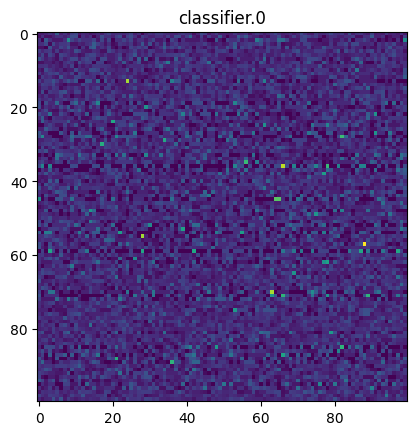

In [30]:
cls.compute_empirical_posteriors(verbose=True)

eps[(peep_size, n_cls, layer_)] = cls._empp
plt.figure()
plt.title(layer_)
plt.imshow(cls._empp)

In [58]:
torch.cuda.empty_cache()

In [ ]:
# parsi

# Criterio tuning

In [1]:
# python stuff
from pathlib import Path as Path
from numpy.random import randint

# Our stuff
from datasets.cifar import Cifar
from models.model_wrap import ModelWrap 
from coreVectors.coreVectors import CoreVectors 
from coreVectors.svd_coreVectors import reduct_matrices_from_svds as parser_fn
from classifier.classifier_base import trim_corevectors
from classifier.kmeans import KMeans 
from classifier.gmm import GMM 
from classifier.tkmeans import KMeans as tKMeans 
from classifier.tgmm import GMM as tGMM 
from peepholes.peepholes import Peepholes

# torch stuff
import torch
from torchvision.models import vgg16, VGG16_Weights

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [47]:
x = np.arange(0, 1, 0.001)

y1 = np.exp(-4.2 * x)  
y2 = 1 - np.exp(-2 * (1 - x))  

In [48]:
y1 = (y1 - y1.min()) / (y1.max() - y1.min())
y2 = (y2 - y2.min()) / (y2.max() - y2.min())

In [59]:
d = 1 - x

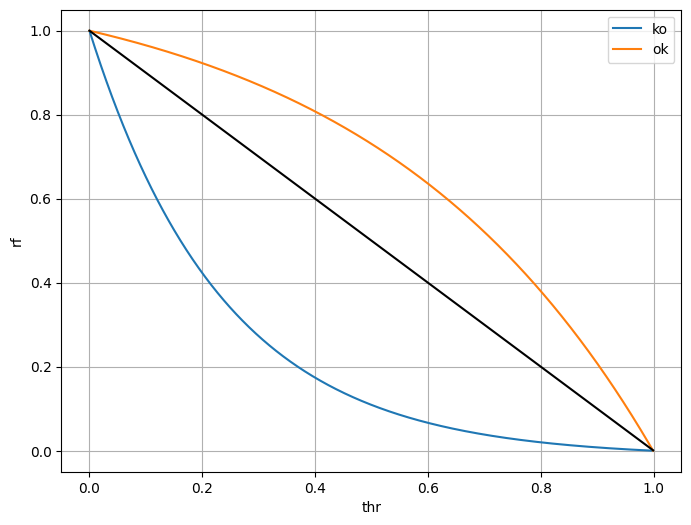

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(x, y1, label="ko")
plt.plot(x, y2, label="ok")
plt.plot(x, d, c='k')
plt.xlabel("thr")
plt.ylabel("rf")
plt.legend()
plt.grid()
plt.show()

In [51]:
i0 = 20
i1 = 50
i2 = 100

In [52]:
cmp = [20, 50, 100]

In [53]:
diff = []
for i in cmp:
    diff.append(y2[i] - y1[i])
    print(x[i], y2[i] - y1[i])


0.02 0.07539815277852624
0.05 0.17581248734256272
0.1 0.31346286676228574


In [54]:
np.mean(diff)

0.18822450229445822

In [65]:
diff1 = []
diff2 = []
for i in cmp:
    d1 = np.abs(y1[i] - d[i])
    d2 = np.abs(y2[i] - d[i])
    diff1.append(d1)
    diff2.append(d2)
    print(x[i], d1, d2)


0.02 0.0618005531327287 0.013597599645797542
0.05 0.1423117166873692 0.033500770655193524
0.1 0.24819656454963268 0.06526630221265306


In [64]:
np.mean(diff1), np.mean(diff2)

(0.15076961145657686, 0.03745489083788137)

# Tuning results

In [ ]:
import os
import pandas as pd
from pathlib import Path
import torch
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np
from peepholes.peepholes import Peepholes
from coreVectors.coreVectors import CoreVectors 

In [9]:
base_path = '/home/liviamanovi/gitty/XAI/data/peepholes/CIFAR100/tGMM'
results = []

for name in os.listdir(base_path):
    if name.startswith('peepholes'):
        results.append(name)

In [10]:
path = '/home/liviamanovi/gitty/XAI/data/tuning/classifier.3/peephole_wrap_2024-11-22_19-19-52/searcher-state-2024-11-22_19-20-07.pkl'
df = pd.read_pickle(path)

In [173]:
def plot_quantile_metrics(ph, cv_dl, layer, score_type, name, save_path=None, verbose=False):
    """
    Generate plots for retention fraction and accuracy over quantiles.
    
    Args:
        ph: Peepholes object containing score data.
        cv_dl: Core vectors DataLoader with dataset information.
        layer: Layer name in the Peepholes object.
        score_type: Type of score (e.g., 'max', 'entropy').
        save_path: Optional path to save the plot (default: None).
        verbose: Whether to print additional information during execution.
        
    Returns:
        None (saves the plot to the specified path if provided).
    """
    # xp_name = None
    # for name in names:
    #     if name.endswith(score_type):
    #         xp_name = name
    #         break
    xp_name = name
    if xp_name is None:
        raise ValueError(f"Score type '{score_type}' not found in the Peepholes data.")

    quantiles = torch.arange(0, 1, 0.001)
    conf_t = ph._phs['train'][layer]['score_' + score_type]
    conf_v = ph._phs['val'][layer]['score_' + score_type]
    th = []
    lt = []
    lf = []
    a = []

    c = cv_dl['val'].dataset['result'].detach().numpy()
    pred = cv_dl['val'].dataset['pred'].detach().numpy()
    true = cv_dl['val'].dataset['label'].detach().numpy()

    cntt = Counter(c)

    for q in tqdm(quantiles, desc="Processing Quantiles"):
        perc = torch.quantile(conf_t, q)
        th.append(perc)
        idx = torch.argwhere(conf_v > perc)[:, 0]
        
        # Compute retention fractions
        cnt = Counter(c[idx])
        lt.append(cnt[True] / cntt[True])
        lf.append(cnt[False] / cntt[False])

        # Compute accuracy
        p = pred[idx]
        t = true[idx] 
        cp = (p == t).sum().item()
        a.append(cp / len(idx) if len(idx) > 0 else 0)


    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'{layer} - {xp_name}')
    x = quantiles.numpy()
    d = 1 - x
    y1 = np.array(lt)
    y2 = np.array(lf)
    
    axs[0].set_title('Retention Fraction')
    axs[0].plot(x, y1, label='OK', c='b')
    axs[0].plot(x, y2, label='KO', c='r')
    axs[0].plot(x, d, c='k')
    axs[0].legend()
    axs[0].grid(ls=':')
    axs[0].set_xlabel('Quantiles')
    axs[0].set_ylabel('Retention Fraction')

    axs[1].set_title('Accuracy')
    axs[1].plot(x, a, label='Accuracy', c='g')
    axs[1].legend()
    axs[1].grid(ls=':')
    axs[1].set_xlabel('Quantiles')
    axs[1].set_ylabel('Accuracy')

    plt.tight_layout()

    if save_path:
        save_file = os.path.join(save_path, f'{layer}_xp={xp_name}.png')
        plt.savefig(save_file)
        if verbose:
            print(f"Plot saved to {save_file}")
    else:
        plt.show()
    plt.close()


In [175]:
def plot_quantile_metrics_(ph, cv_dl, layer, score_type, name, save_path=None, verbose=False):
    """
    Generate plots for retention fraction and accuracy over quantiles.
    
    Args:
        ph: Peepholes object containing score data.
        cv_dl: Core vectors DataLoader with dataset information.
        layer: Layer name in the Peepholes object.
        score_type: Type of score (e.g., 'max', 'entropy').
        save_path: Optional path to save the plot (default: None).
        verbose: Whether to print additional information during execution.
        
    Returns:
        None (saves the plot to the specified path if provided).
    """
    # xp_name = None
    # for name in names:
    #     if name.endswith(score_type):
    #         xp_name = name
    #         break
    xp_name = name
    if xp_name is None:
        raise ValueError(f"Score type '{score_type}' not found in the Peepholes data.")

    quantiles = torch.arange(0, 1, 0.001)
    # conf_t = ph._phs['train'][layer]['score_' + score_type]
    conf_t = ph._phs['val'][layer]['score_' + score_type]
    conf_v = ph._phs['val'][layer]['score_' + score_type]
    th = []
    lt = []
    lf = []
    a = []

    c = cv_dl['val'].dataset['result'].detach().numpy()
    pred = cv_dl['val'].dataset['pred'].detach().numpy()
    true = cv_dl['val'].dataset['label'].detach().numpy()

    cntt = Counter(c)

    for q in tqdm(quantiles, desc="Processing Quantiles"):
        perc = torch.quantile(conf_t, q)
        th.append(perc)
        idx = torch.argwhere(conf_v > perc)[:, 0]
        
        # Compute retention fractions
        cnt = Counter(c[idx])
        lt.append(cnt[True] / cntt[True])
        lf.append(cnt[False] / cntt[False])

        # Compute accuracy
        p = pred[idx]
        t = true[idx] 
        cp = (p == t).sum().item()
        a.append(cp / len(idx) if len(idx) > 0 else 0)


    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'{layer} - {xp_name}')
    x = quantiles.numpy()
    d = 1 - x
    y1 = np.array(lt)
    y2 = np.array(lf)
    
    axs[0].set_title('Retention Fraction')
    axs[0].plot(x, y1, label='OK', c='b')
    axs[0].plot(x, y2, label='KO', c='r')
    axs[0].plot(x, d, c='k')
    axs[0].legend()
    axs[0].grid(ls=':')
    axs[0].set_xlabel('Quantiles')
    axs[0].set_ylabel('Retention Fraction')

    axs[1].set_title('Accuracy')
    axs[1].plot(x, a, label='Accuracy', c='g')
    axs[1].legend()
    axs[1].grid(ls=':')
    axs[1].set_xlabel('Quantiles')
    axs[1].set_ylabel('Accuracy')

    plt.tight_layout()

    if save_path:
        save_file = os.path.join(save_path, f'{layer}_xp={xp_name}.png')
        plt.savefig(save_file)
        if verbose:
            print(f"Plot saved to {save_file}")
    else:
        plt.show()
    plt.close()


In [45]:
def plot_quantile_metrics_comparison(ph, cv_dl, layer, score_type, name, save_path=None, verbose=False):
    """
    Generate plots comparing retention fraction and accuracy over quantiles
    for two different `conf_t` configurations.

    Args:
        ph: Peepholes object containing score data.
        cv_dl: Core vectors DataLoader with dataset information.
        layer: Layer name in the Peepholes object.
        score_type: Type of score (e.g., 'max', 'entropy').
        save_path: Optional path to save the plot (default: None).
        verbose: Whether to print additional information during execution.
        
    Returns:
        None (saves the plot to the specified path if provided).
    """
    xp_name = name
    if xp_name is None:
        raise ValueError(f"Score type '{score_type}' not found in the Peepholes data.")

    quantiles = torch.arange(0, 1, 0.001)
    
    conf_t_train = ph._phs['train'][layer]['score_' + score_type] 
    conf_t_val = ph._phs['val'][layer]['score_' + score_type]
    conf_v = ph._phs['val'][layer]['score_' + score_type]

    results = []
    for conf_t in [conf_t_train, conf_t_val]:
        th = []
        lt = []
        lf = []
        a = []

        c = cv_dl['val'].dataset['result'].detach().numpy()
        pred = cv_dl['val'].dataset['pred'].detach().numpy()
        true = cv_dl['val'].dataset['label'].detach().numpy()

        # initial acc
        ic = np.sum(pred==true)
        iacc = ic/len(true)

        cntt = Counter(c)

        for q in tqdm(quantiles, desc="Processing Quantiles"):
            perc = torch.quantile(conf_t, q)
            th.append(perc)
            idx = torch.argwhere(conf_v > perc)[:, 0]
            
            # Compute retention fractions
            cnt = Counter(c[idx])
            lt.append(cnt[True] / cntt[True])
            lf.append(cnt[False] / cntt[False])

            # Compute accuracy
            p = pred[idx]
            t = true[idx] 
            cp = (p == t).sum().item()
            a.append(cp / len(idx) if len(idx) > 0 else 0)
            if q==0.1:
                print(f'acc gain @0.1: {cp / len(idx) - iacc}')

        results.append((lt, lf, a))

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'{layer} - {xp_name}')
    x = quantiles.numpy()
    d = 1 - x

    # Extract results
    lt1, lf1, a1 = results[0]
    lt2, lf2, a2 = results[1]

    # Plot Retention Fraction
    axs[0].set_title('Retention Fraction')
    axs[0].plot(x, lt1, label='OK (thr on train)', c='b', linestyle='-')
    axs[0].plot(x, lf1, label='KO (thr on train)', c='r', linestyle='-')
    axs[0].plot(x, lt2, label='OK (thr on val)', c='b', linestyle='--')
    axs[0].plot(x, lf2, label='KO (thr on val)', c='r', linestyle='--')
    axs[0].plot(x, d, c='k')
    axs[0].legend()
    axs[0].grid(ls=':')
    axs[0].set_xlabel('Quantiles')
    axs[0].set_ylabel('Retention Fraction')

    # Plot Accuracy with Markers
    axs[1].set_title('Accuracy')
    axs[1].plot(x, a1, label='Accuracy (thr on train)', c='g', linestyle='-')
    axs[1].plot(x, a2, label='Accuracy (thr on val)', c='g', linestyle='--')

    # Add markers with text
    # for q_marker in [0.98, 0.95, 0.90]:  # Corresponding to 1 - 0.02, 1 - 0.05, 1 - 0.1
    #     q_index = int((1 - q_marker) * len(x))
    #     axs[1].scatter(x[q_index], a1[q_index], color='blue', label=f'Current Acc @ {q_marker}')
    #     axs[1].scatter(x[q_index], a2[q_index], color='orange', label=f'Comment Acc @ {q_marker}')
    #     axs[1].text(x[q_index], a1[q_index], f'{a1[q_index]:.2f}', fontsize=8, color='blue')
    #     axs[1].text(x[q_index], a2[q_index], f'{a2[q_index]:.2f}', fontsize=8, color='orange')

    axs[1].legend()
    axs[1].grid(ls=':')
    axs[1].set_xlabel('Quantiles')
    axs[1].set_ylabel('Accuracy')

    plt.tight_layout()

    if save_path:
        save_file = os.path.join(save_path, f'{layer}_xp={xp_name}_comparison.png')
        plt.savefig(save_file)
        if verbose:
            print(f"Plot saved to {save_file}")
    else:
        plt.show()
    plt.close()


In [191]:
def plot_quantile_metrics_comparison_(ph, cv_dl, layer, score_type, name, save_path=None, verbose=False):
    """
    Generate plots comparing retention fraction and accuracy over quantiles
    for two different `conf_t` configurations.

    Args:
        ph: Peepholes object containing score data.
        cv_dl: Core vectors DataLoader with dataset information.
        layer: Layer name in the Peepholes object.
        score_type: Type of score (e.g., 'max', 'entropy').
        save_path: Optional path to save the plot (default: None).
        verbose: Whether to print additional information during execution.
        
    Returns:
        None (saves the plot to the specified path if provided).
    """
    xp_name = name
    if xp_name is None:
        raise ValueError(f"Score type '{score_type}' not found in the Peepholes data.")

    quantiles = torch.arange(0, 1, 0.001)
    
    conf_t_train = ph._phs['train'][layer]['score_' + score_type] 
    conf_t_val = ph._phs['val'][layer]['score_' + score_type]
    conf_v = ph._phs['val'][layer]['score_' + score_type]

    c = cv_dl['val'].dataset['result'].detach().numpy()
    pred = cv_dl['val'].dataset['pred'].detach().numpy()
    true = cv_dl['val'].dataset['label'].detach().numpy()

    # one cmore cmp
    ct = cv_dl['train'].dataset['result'].detach().numpy()
    conf_t_train_c = ph._phs['train'][layer]['score_' + score_type][ct==True] 

    results = []
    for conf_t in [conf_t_train, conf_t_val, conf_t_train_c]:
        th = []
        lt = []
        lf = []
        a = []

        cntt = Counter(c)

        for q in tqdm(quantiles, desc="Processing Quantiles"):
            perc = torch.quantile(conf_t, q)
            th.append(perc)
            idx = torch.argwhere(conf_v > perc)[:, 0]
            
            # Compute retention fractions
            cnt = Counter(c[idx])
            lt.append(cnt[True] / cntt[True])
            lf.append(cnt[False] / cntt[False])

            # Compute accuracy
            p = pred[idx]
            t = true[idx] 
            cp = (p == t).sum().item()
            a.append(cp / len(idx) if len(idx) > 0 else 0)

        results.append((lt, lf, a))

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'{layer} - {xp_name}')
    x = quantiles.numpy()
    d = 1 - x

    # Extract results
    lt1, lf1, a1 = results[0]
    lt2, lf2, a2 = results[1]
    lt3, lf3, a3 = results[2]

    # Plot Retention Fraction
    axs[0].set_title('Retention Fraction')
    axs[0].plot(x, lt1, label='OK (thr on train)', c='b', linestyle='-', alpha=0.7)
    axs[0].plot(x, lf1, label='KO (thr on train)', c='r', linestyle='-', alpha=0.7)
    axs[0].plot(x, lt3, label='OK (thr on train correct)', c='b', linestyle='dotted')
    axs[0].plot(x, lf3, label='KO (thr on train correct)', c='r', linestyle='dotted')
    axs[0].plot(x, lt2, label='OK (thr on val)', c='b', linestyle='--')
    axs[0].plot(x, lf2, label='KO (thr on val)', c='r', linestyle='--')
    axs[0].plot(x, d, c='k')
    axs[0].legend()
    axs[0].grid(ls=':')
    axs[0].set_xlabel('Quantiles')
    axs[0].set_ylabel('Retention Fraction')

    # Plot Accuracy with Markers
    axs[1].set_title('Accuracy')
    axs[1].plot(x, a1, label='Accuracy (thr on train)', c='g', linestyle='-', alpha=0.7)
    axs[1].plot(x, a3, label='Accuracy (thr on train correct)', c='g', linestyle='dotted')
    axs[1].plot(x, a2, label='Accuracy (thr on val)', c='g', linestyle='--')

    # Add markers with text
    # for q_marker in [0.98, 0.95, 0.90]:  # Corresponding to 1 - 0.02, 1 - 0.05, 1 - 0.1
    #     q_index = int((1 - q_marker) * len(x))
    #     axs[1].scatter(x[q_index], a1[q_index], color='blue', label=f'Current Acc @ {q_marker}')
    #     axs[1].scatter(x[q_index], a2[q_index], color='orange', label=f'Comment Acc @ {q_marker}')
    #     axs[1].text(x[q_index], a1[q_index], f'{a1[q_index]:.2f}', fontsize=8, color='blue')
    #     axs[1].text(x[q_index], a2[q_index], f'{a2[q_index]:.2f}', fontsize=8, color='orange')

    axs[1].legend()
    axs[1].grid(ls=':')
    axs[1].set_xlabel('Quantiles')
    axs[1].set_ylabel('Accuracy')

    plt.tight_layout()

    if save_path:
        save_file = os.path.join(save_path, f'{layer}_xp={xp_name}_comparison.png')
        plt.savefig(save_file)
        if verbose:
            print(f"Plot saved to {save_file}")
    else:
        plt.show()
    plt.close()


In [13]:
device = torch.device(f"cuda:4" if torch.cuda.is_available() else "cpu")

In [4]:
dataset = 'CIFAR100'

layer = 'classifier.3'

cvs_name = 'corevectors'
#cvs_path = Path.cwd()/f'../data/corevectors/{dataset}'
cvs_path = f'/srv/newpenny/XAI/generated_data/corevectors/{dataset}'

cv = CoreVectors(
        path = cvs_path,
        name = cvs_name,
        model = None 
        )

# load corevds 
cv.load_only(
        loaders = ['train', 'test', 'val'],
        verbose = True
        ) 

cv_dl = cv.get_dataloaders(verbose=True)


 ---- Getting data from train

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/corevectors.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from test

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/corevectors.test exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from val

File /srv/newpenny/XAI/generated_data/corevectors/CIFAR100/corevectors.val exists. Loading from disk.
loaded n_samples:  10000
Loading normalization info.
creating dataloader for:  train
creating dataloader for:  test
creating dataloader for:  val


/home/liviamanovi/gitty/XAI/src/coreVectors/coreVectors.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  means, stds, is_normed, wrt = torch.load(norm_file_path)


In [16]:
target_layer = 'classifier.0' #'features.7'
# phs_path = Path(f'/srv/newpenny/XAI/generated_data/peepholes/CIFAR100/{target_layer}')
# phs_path = Path(f'/home/liviamanovi/gitty/XAI/data/peepholes/CIFAR100/{target_layer}') # for KMeans
phs_path = Path(f'/home/liviamanovi/gitty/XAI/data/peepholes/CIFAR100/tGMM')
phs_name = 'peepholes' # occhio qua

In [23]:
names = []
#res_path = '/home/liviamanovi/gitty/XAI/data/peepholes/CIFAR100/classifier.3'
res_path = '/home/liviamanovi/gitty/XAI/data/peepholes/CIFAR100/tGMM'
for name_ in os.listdir(res_path):
    if not (name_.endswith('png') or name_.endswith('pickle') or name_.startswith('cl')):
        # print(name_)
        names.append('.'.join(name_.split('.')[:-1]))

In [24]:
set(names)

{'peepholes.128.128.entropy',
 'peepholes.16.256.max',
 'peepholes.256.128.entropy',
 'peepholes.256.128.max',
 'peepholes.256.256.max',
 'peepholes.32.128.max',
 'peepholes.32.256.entropy',
 'peepholes.4.256.entropy',
 'peepholes.4.256.max',
 'peepholes.64.128.entropy'}

In [26]:
save_path = 'temp_plots/rf_vs_acc_cmp'

In [ ]:
for phs_name in set(names):
       
    print(phs_name)
    
    ph = Peepholes(
        path=phs_path,
        name=phs_name,
        classifier=None,
        layer=target_layer,
        device=device
            )

    ph.load_only(
        #loaders = ['train', 'test', 'val'],
        loaders = ['train', 'val'],
        verbose = False
    )
    
    score_type = phs_name.split('.')[-1]
    # plot_quantile_metrics(
    #     ph=ph,
    #     cv_dl=cv_dl,
    #     layer='classifier.3',
    #     score_type=score_type,
    #     name=phs_name,
    #     save_path=save_path, 
    #     verbose=False
    # )
    plot_quantile_metrics_comparison(
        ph=ph,
        cv_dl=cv_dl,
        layer='classifier.3',
        score_type=score_type,
        name=phs_name,
        save_path=None, 
        verbose=False
    )

In [ ]:
plot_quantile_metrics(
    ph=ph,
    cv_dl=cv_dl,
    layer='classifier.3',
    score_type='max',
    names=names,
    save_path=None, 
    verbose=True
)

In [ ]:
plot_quantile_metrics(
    ph=ph,
    cv_dl=cv_dl,
    layer='classifier.3',
    score_type='entropy',
    names=names,
    save_path=None, 
    verbose=True
)

### Score distro

In [ ]:
target_layer = 'classifier.0' #'features.7'
# phs_path = Path(f'/srv/newpenny/XAI/generated_data/peepholes/CIFAR100/{target_layer}')
# phs_path = Path(f'/home/liviamanovi/gitty/XAI/data/peepholes/CIFAR100/{target_layer}') # for KMeans
phs_path = Path(f'/home/liviamanovi/gitty/XAI/data/peepholes/CIFAR100/tGMM')
phs_name = 'peepholes' # occhio qua

In [ ]:
names = []
#res_path = '/home/liviamanovi/gitty/XAI/data/peepholes/CIFAR100/classifier.3'
res_path = '/home/liviamanovi/gitty/XAI/data/peepholes/CIFAR100/tGMM'
for name_ in os.listdir(res_path):
    if not (name_.endswith('png') or name_.endswith('pickle') or name_.startswith('cl')):
        # print(name_)
        names.append('.'.join(name_.split('.')[:-1]))

In [30]:
phs_name = names[0]

ph = Peepholes(
    path=phs_path,
    name=phs_name,
    classifier=None,
    layer=target_layer,
    device=device
        )

ph.load_only(
    #loaders = ['train', 'test', 'val'],
    loaders = ['train', 'val'],
    verbose = False
    )

In [52]:
et = ph._phs['train']['classifier.0']['score_entropy']
ev = ph._phs['val']['classifier.0']['score_entropy']

mt = ph._phs['train']['classifier.0']['score_max']
mv = ph._phs['val']['classifier.0']['score_max']

TypeError: 'NoneType' object is not subscriptable

In [ ]:
for phs_name in set(names):

    ph = Peepholes(
        path=phs_path,
        name=phs_name,
        classifier=None,
        layer=target_layer,
        device=device
            )

    ph.load_only(
        #loaders = ['train', 'test', 'val'],
        loaders = ['train', 'val'],
        verbose = False
        )
    
    layer = list(ph._phs['train'].keys())[0]
    
    et = ph._phs['train'][layer]['score_entropy']
    ev = ph._phs['val'][layer]['score_entropy']

    mt = ph._phs['train'][layer]['score_max']
    mv = ph._phs['val'][layer]['score_max']

    fig, axs = plt.subplots(1,2, figsize=(8,4))
    fig.suptitle(f'{layer} - {phs_name}')
    bins = np.linspace(et.min(), et.max(), 100)
    axs[0].set_title('entropy')
    axs[0].hist(et, bins=bins, alpha=0.5, label='train')
    axs[0].hist(ev, bins=bins, alpha=0.5, label='val')

    bins = np.linspace(mt.min(), mt.max(), 100)
    axs[1].set_title('max')
    axs[1].hist(mt, bins=bins, alpha=0.5, label='train')
    axs[1].hist(mv, bins=bins, alpha=0.5, label='val')

    for ax in axs:
        ax.legend()
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/liviamanovi/gitty/XAI/data/peepholes/CIFAR100/tGMM/peepholes.64.128.entropy.val/meta.json'

In [109]:
pred_ = cvs['val'].dataset['pred'][v]
true_ = cvs['val'].dataset['label'][v]

In [115]:
pred_ = cvs['val'].dataset['pred']
true_ = cvs['val'].dataset['label']
acc_ = torch.sum(pred_==true_)/100
print(f'Initial accuracy: {acc_} %')

for k, v in idx_kept.items():
    pred_ = cvs['val'].dataset['pred'][v]
    true_ = cvs['val'].dataset['label'][v]
    acc_ = torch.sum(pred_==true_)/100
    print(f'Accuracy @{k} quantiles: {acc_} %')

Initial accuracy: 74.95999908447266 %
Accuracy @0.020000001415610313 quantiles: 73.51000213623047 %
Accuracy @0.05000000074505806 quantiles: 71.47000122070312 %
Accuracy @0.10000000149011612 quantiles: 67.9000015258789 %


In [ ]:
# TODO: make dist to diagonal
cmp = [20, 50, 100]
d1 = []
d2 = []
for i in cmp:
    # d1.append(np.abs(y1[i]-d[i]))
    # d2.append(np.abs(y2[i]-d[i]))
    d1.append(y1[i] - d[i])
    d2.append(d[i] - y2[i])
return np.mean(d1), np.mean(d2)

# Last stuff with persistenttd

In [1]:
%matplotlib widget

In [2]:
# python stuff
from pathlib import Path as Path
import numpy as np
from numpy.random import randint
import pickle
import matplotlib.pyplot as plt

# our stuff
from datasets.cifar import Cifar
from models.model_wrap import ModelWrap 
from coreVectors.coreVectors import CoreVectors 
from coreVectors.svd_coreVectors import reduct_matrices_from_svds as parser_fn
from classifier.classifier_base import trim_corevectors
from classifier.kmeans import KMeans 
from classifier.gmm import GMM 
from classifier.tkmeans import KMeans as tKMeans 
from classifier.tgmm import GMM as tGMM 
from peepholes.peepholes import Peepholes

# torch stuff
import torch
from torchvision.models import vgg16, VGG16_Weights
from cuda_selector import auto_cuda

In [3]:
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import roc_curve

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device(auto_cuda('utilization')) if use_cuda else torch.device("cpu")
print(f"Using {device} device")

#--------------------------------
# Directories definitions
#--------------------------------
# model parameters
dataset = 'CIFAR10' 
ds_path = f'/srv/newpenny/dataset/{dataset}'

# pretrained = True
# seed = 29
# bs = 64
model_id = 'vgg16'
model_dir = '/srv/newpenny/XAI/models'
with open(Path(model_dir)/'model_config.pkl', 'rb') as f:
    model_config = pickle.load(f)

model_name = model_config[model_id][dataset]

svds_name = 'svds' 
svds_path = Path.cwd()/f'../data/svds/{dataset}/{model_id}'

cvs_name = 'corevectors'
cvs_path = Path.cwd()/f'../data/corevectors/{dataset}/{model_id}'

cls_type = 'tGMM' # 'tKMeans' 
phs_name = 'peepholes'
phs_path = Path.cwd()/f'../data/peepholes/{dataset}/{model_id}/{cls_type}'

verbose = True 

Using cuda:4 device


In [5]:
#--------------------------------
# Dataset 
#--------------------------------

# pretrained = True
seed = 29
bs = 64

ds = Cifar(
        data_path = ds_path,
        dataset=dataset
        )
ds.load_data(
        batch_size = 256, # bs # prendere da qualche config 
        data_kwargs = {'num_workers': 4, 'pin_memory': True},
        seed = seed, # prendere da qualche config
        )

dataset: CIFAR10
Files already downloaded and verified
Files already downloaded and verified


{'train': <torch.utils.data.dataloader.DataLoader at 0x7f86ebf17c50>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f86ebf5ee10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f86ec42c3b0>}

In [6]:
#--------------------------------
# Model 
#--------------------------------

# if model_id=='vgg16':
nn = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
in_features = 4096
n_classes = len(ds.get_classes()) 
nn.classifier[-1] = torch.nn.Linear(in_features, n_classes)
model = ModelWrap(device=device)
model.set_model(model=nn, path=model_dir, name=model_name, verbose=False)

target_layers = [
            'classifier.0',
            'classifier.3',
            'features.28', 
            'features.26',
            'features.24',
            #'features.7'
            ]
model.set_target_layers(target_layers=target_layers, verbose=verbose)

/home/liviamanovi/gitty/XAI/src/models/model_wrap.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._checkpoint = torch.load(file, map_location=self.device)


In [7]:
#--------------------------------
# SVDs 
#--------------------------------
print('target layers: ', model.get_target_layers()) 
model.get_svds(path=svds_path, name=svds_name, verbose=verbose)
for k in model._svds.keys():
    for kk in model._svds[k].keys():
        print('svd shapes: ', k, kk, model._svds[k][kk].shape)

target layers:  {'classifier.0': Linear(in_features=25088, out_features=4096, bias=True), 'classifier.3': Linear(in_features=4096, out_features=4096, bias=True), 'features.28': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 'features.26': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 'features.24': Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))}
File /home/liviamanovi/gitty/XAI/src/../data/svds/CIFAR10/vgg16/svds exists. Loading from disk.
Layers to compute SVDs:  []
saving /home/liviamanovi/gitty/XAI/src/../data/svds/CIFAR10/vgg16/svds
svd shapes:  classifier.0 U torch.Size([4096, 4096])
svd shapes:  classifier.0 s torch.Size([4096])
svd shapes:  classifier.0 Vh torch.Size([4096, 25089])
svd shapes:  classifier.3 U torch.Size([4096, 4096])
svd shapes:  classifier.3 s torch.Size([4096])
svd shapes:  classifier.3 Vh torch.Size([4096, 4097])
svd shapes:  features.28 U torch.Size([100352, 300])
svd shapes:  features.28 s to

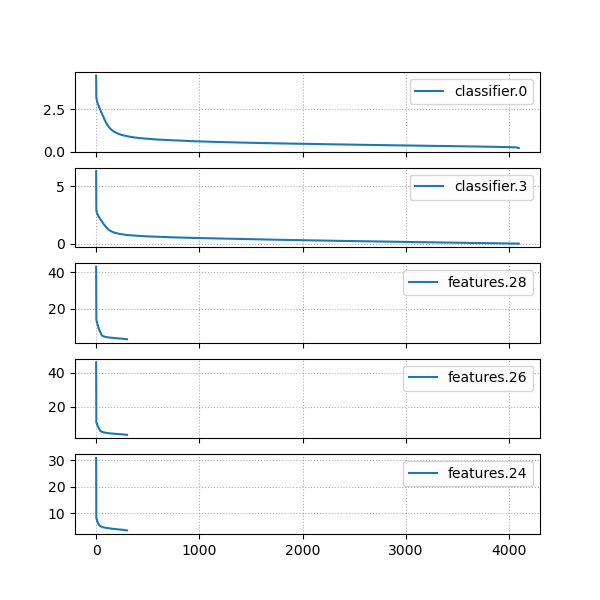

In [8]:
layer_list = target_layers #['classifier.0', 'classifier.3', 'features.28']

fig, axs = plt.subplots(len(layer_list), 1, figsize=(6,6), sharex=True)
for i, layer in enumerate(layer_list):
    axs[i].plot(model._svds[layer]['s'], label=layer)
    axs[i].legend()
    axs[i].grid(ls=':')
plt.show()

In [9]:
peep_size = 8
n_cls = 16
ph_config_name = phs_name+f'.{peep_size}.{n_cls}'

In [10]:
#--------------------------------
# Peepholes
#--------------------------------
#n_classes = 300
#parser_cv = trim_corevectors
#parser_kwargs = {'layer': 'classifier.0', 'peep_size':300}
#cls_kwargs = {}#{'batch_size':256} 

#cls = tGMM(
#        nl_classifier = 300,
#        nl_model = n_classes,
#        parser = parser_cv,
#        parser_kwargs = parser_kwargs,
#        cls_kwargs = cls_kwargs,
#        device = device
#        )

#layer = 'classifier.3'

corevecs = CoreVectors(
path = cvs_path,
name = cvs_name,
device = device 
)

peepholes = Peepholes(
path = phs_path,
name = ph_config_name, # name = phs_name,
classifier = None,
layer = target_layers,
device = device
)

In [11]:
pprova = {}
with peepholes as ph:
    ph.load_only(
            loaders = ['train', 'test', 'val'],
            verbose = True
            )
    
    print(ph._phs['train'].keys())
    
    for split in ['train', 'test', 'val']:
        pprova[split] = ph._phs[split].detach().cpu().numpy()


 ---- Getting peepholes for train

File /home/liviamanovi/gitty/XAI/src/../data/peepholes/CIFAR10/vgg16/tGMM/peepholes.8.16.train exists. Loading from disk.

 ---- Getting peepholes for test

File /home/liviamanovi/gitty/XAI/src/../data/peepholes/CIFAR10/vgg16/tGMM/peepholes.8.16.test exists. Loading from disk.

 ---- Getting peepholes for val

File /home/liviamanovi/gitty/XAI/src/../data/peepholes/CIFAR10/vgg16/tGMM/peepholes.8.16.val exists. Loading from disk.
_PersistentTDKeysView(['classifier.0'],
    include_nested=False,
    leaves_only=False)
closing train
closing test
closing val


In [12]:
pprova

{'train': {'classifier.0': {'peepholes': array([[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
   'score_entropy': array([nan, nan, nan, ..., nan, nan, nan], dtype=float32),
   'score_max': array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)}},
 'test': {'classifier.0': {'peepholes': array([[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
   'score_entropy': array([nan, nan, nan, ..., nan, nan, nan], dtype=float32),
   'score_max': array([nan, nan, nan, ..., nan, nan, nan], dty

/srv/newpenny/conda/envs/xai-venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/srv/newpenny/conda/envs/xai-venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

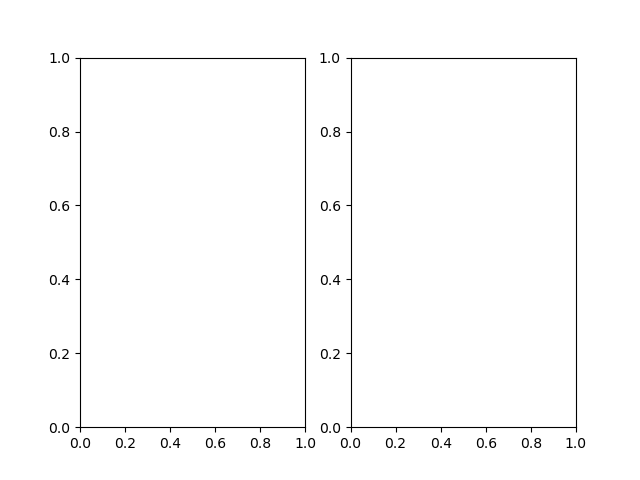

In [13]:
fig, axs = plt.subplots(1, 2)
for split in ['train', 'test', 'val']:
    #axs[0].hist(pprova[split]['classifier.3']['score_max'], density=True, alpha=0.5)
    axs[1].hist(pprova[split]['classifier.0']['score_max'], density=True, alpha=0.5)

In [14]:
corevecs._is_normalized

In [15]:
corevecs = CoreVectors(
        path = cvs_path,
        name = cvs_name,
        device = device 
        )

with corevecs as cv:
    cv.load_only(
            loaders = ['train', 'test', 'val'],
            verbose = True
            ) 

    cv_dl = cv.get_dataloaders(
                batch_size=512,
                verbose=True,
                )
    
    c = cv_dl['val'].dataset['result'].detach().cpu().numpy()
    pred = cv_dl['val'].dataset['pred'].detach().cpu().numpy()
    true = cv_dl['val'].dataset['label'].detach().cpu().numpy()

    print(cv_dl['val'].dataset['coreVectors'].keys())

    cprova = cv_dl['val'].dataset['coreVectors'].detach().cpu().numpy()


 ---- Getting data from train

File /home/liviamanovi/gitty/XAI/src/../data/corevectors/CIFAR10/vgg16/corevectors.train exists. Loading from disk.
loaded n_samples:  40000

 ---- Getting data from test

File /home/liviamanovi/gitty/XAI/src/../data/corevectors/CIFAR10/vgg16/corevectors.test exists. Loading from disk.
loaded n_samples:  10000

 ---- Getting data from val

File /home/liviamanovi/gitty/XAI/src/../data/corevectors/CIFAR10/vgg16/corevectors.val exists. Loading from disk.
loaded n_samples:  10000
Loading normalization info.
creating dataloader for:  train
creating dataloader for:  test
creating dataloader for:  val
_PersistentTDKeysView(['classifier.0', 'classifier.3', 'features.24', 'features.26', 'features.28'],
    include_nested=False,
    leaves_only=False)


/home/liviamanovi/gitty/XAI/src/coreVectors/coreVectors.py:160: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  means, stds, is_normed, wrt = torch.load(norm_file_path)


closing train
closing test
closing val


In [16]:
# tensor([[-0.1232, -0.0459, -0.0476,  ..., -0.0181,  0.0227,  0.0467]

In [17]:
cprova

{'classifier.0': array([[ 1.1649221e+01, -2.0103483e+00,  1.5294764e+00, ...,
         -3.1152919e-01, -6.5991801e-01,  4.9669370e-03],
        [ 7.6584358e+00,  3.6104045e+00, -3.2668343e+00, ...,
         -1.9946724e-02, -5.4016054e-01,  3.4236860e-02],
        [ 1.4778488e+01,  3.8432539e-02,  2.8579867e+00, ...,
         -2.4689960e-01, -1.5314451e-01,  9.1576904e-01],
        ...,
        [ 8.2077532e+00,  9.1555780e-01, -1.0701287e+00, ...,
         -1.7606378e-01, -1.0022126e-01,  9.9150252e-01],
        [ 1.1056294e+01,  1.5315477e+00, -4.5385904e+00, ...,
         -7.5425744e-02, -5.2340215e-01, -1.8409370e-01],
        [ 5.3957863e+00,  6.2895900e-01, -2.3692822e+00, ...,
         -1.0973364e-02,  2.6010638e-01, -1.0464468e-01]], dtype=float32),
 'classifier.3': array([[ 0.1859858 ,  0.09306084, -4.1059284 , ..., -0.33096159,
         -0.31394458, -0.23761536],
        [-0.1043174 , -1.9701316 , -1.1171391 , ..., -0.2976386 ,
         -0.05043952,  0.03069859],
        [-4.95

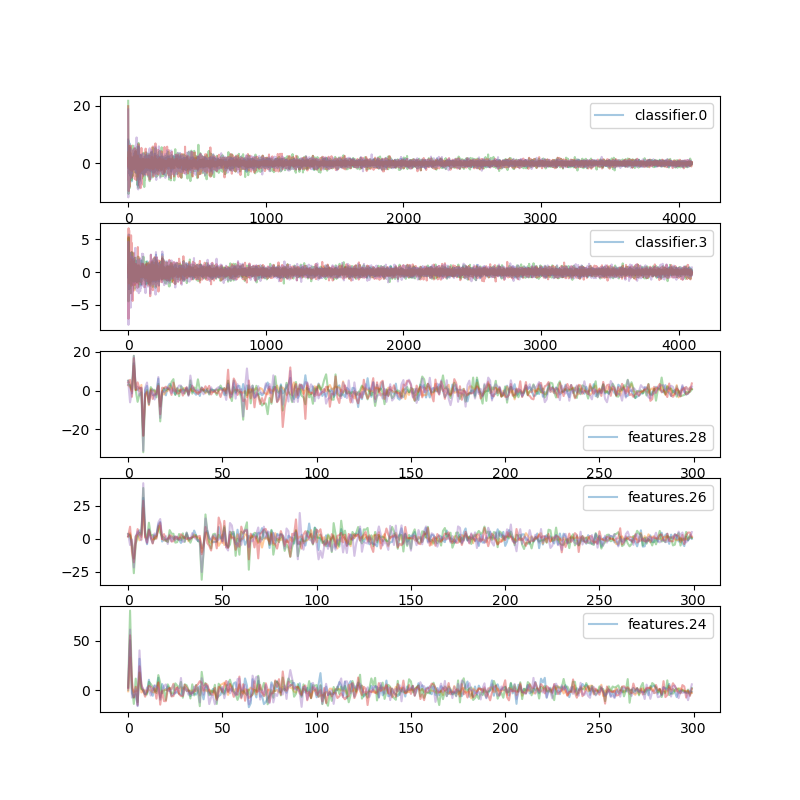

In [18]:
fig, axs = plt.subplots(len(target_layers), 1, figsize=(8, 8))
for i, layer in enumerate(target_layers):
    for j in range(5):
        axs[i].plot(cprova[layer][10+j], alpha=0.4, label=layer)
        if j==0:
            axs[i].legend()
plt.show()

In [19]:
import random
from itertools import product
from time import time

In [20]:
verbose = False

In [ ]:
#--------------------------------
# Peepholes
#--------------------------------
ps = [2**i for i in range(3, 9)]
ncls = [2**i for i in range(3, 9)]
all_combinations = list(product(ps, ncls))

for peep_size, n_cls in all_combinations[:1]:
    ph_config_name = phs_name+f'.{peep_size}.{n_cls}'
    print(ph_config_name)
    
    for layer in target_layers:
            n_classes = 10
            parser_cv = trim_corevectors
            parser_kwargs = {'layer': layer, 'peep_size':peep_size}
            cls_kwargs = {}#{'batch_size':256} 
            if cls_type=='tGMM':
                    cls = tGMM(
                            nl_classifier = n_cls,
                            nl_model = n_classes,
                            parser = parser_cv,
                            parser_kwargs = parser_kwargs,
                            cls_kwargs = cls_kwargs,
                            device = device
                            )
            elif cls_type=='tKMeans':
                    cls = tKMeans(
                            nl_classifier = n_cls,
                            nl_model = n_classes,
                            parser = parser_cv,
                            parser_kwargs = parser_kwargs,
                            cls_kwargs = cls_kwargs,
                            device = device
                            )
    
            corevecs = CoreVectors(
                    path = cvs_path,
                    name = cvs_name,
                    device = device 
                    )
            
            peepholes = Peepholes(
                    path = phs_path,
                    # name = phs_name,
                    name = ph_config_name,
                    classifier = cls,
                    # classifier = None,
                    layer = layer,
                    device = device
                    )
    
            with corevecs as cv, peepholes as ph:
                    cv.load_only(
                            loaders = ['train', 'test', 'val'],
                            verbose = verbose
                            ) 
                    
                    cv_dl = cv.get_dataloaders(
                            batch_size = bs,
                            verbose = verbose,
                            )
                    
                    t0 = time()
                    cls.fit(dataloader = cv_dl['train'], verbose=verbose)
                    print('Fitting time = ', time()-t0)
                    
                    cls.compute_empirical_posteriors(verbose=verbose)
                    plt.figure()
                    plt.imshow(cls._empp)
                    plt.savefig(f'empp_{ph_config_name}.png')
            
                    ph.get_peepholes(
                            loaders = cv_dl,
                            verbose = verbose
                            )
            
                    ph.get_scores(
                            batch_size = 256,
                            verbose=verbose
                            )
                    # input('Wait sc')
            
                    i = 0
                    print('\nPrinting some peeps')
                    ph_dl = ph.get_dataloaders(verbose=verbose)
                    for data in ph_dl['val']:
                            print('phs\n', data[layer]['peepholes'])
                            print('max\n', data[layer]['score_max'])
                            print('ent\n', data[layer]['score_entropy'])
                            i += 1
                            if i == 3: break
            
                    ph.evaluate(
                            layer = layer,
                            # score_type = 'max',
                            score_type = 'max',
                            coreVectors = cv_dl
                            )

                    ph.evaluate(
                            layer = layer,
                            score_type = 'entropy',
                            coreVectors = cv_dl
                            )

peepholes.8.8


Training: |          | 0/? [00:00<?, ?it/s]

/srv/newpenny/conda/envs/xai-venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered `nan` values in tensor. Will be removed.
  warnings.warn(*args, **kwargs)  # noqa: B028


Fitting time =  2.040346384048462
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
        image: Tensor(shape=torch.Size([64, 3, 224, 224]), device=cuda:4, dtype=torch.float32, is_shared=True),
        label: Tensor(shape=torch.Size([64]), device=cuda:4, dtype=torch.fl

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
_SubTensorDict(
    fields={
        coreVectors: _SubTensorDict(
            fields={
                classifier.0: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                classifier.3: Tensor(shape=torch.Size([64, 4096]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.24: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.26: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True),
                features.28: Tensor(shape=torch.Size([64, 300]), device=cuda:4, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([64]),
            device=cuda:4,
            is_shared=True),
    

Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [21]:
ps = [2**i for i in range(3, 9)]
ps

[8, 16, 32, 64, 128, 256]

In [30]:
ncls = [2**i for i in range(6, 9)]
ncls

[64, 128, 256]

In [32]:
all_combinations = list(product(ps, ncls))

In [34]:
all_combinations

[(8, 64),
 (8, 128),
 (8, 256),
 (16, 64),
 (16, 128),
 (16, 256),
 (32, 64),
 (32, 128),
 (32, 256),
 (64, 64),
 (64, 128),
 (64, 256),
 (128, 64),
 (128, 128),
 (128, 256),
 (256, 64),
 (256, 128),
 (256, 256)]

In [27]:
random.choices(ps, k=1)

[128]

In [9]:
target_layers = [
        'classifier.0',
        'classifier.3',
        # 'features.28'
        ]

In [10]:
peepholes = Peepholes(
        path = phs_path,
        name = phs_name,
        classifier = None,
        layer = target_layers,
        device = device
        )

In [25]:
peepholes._phs

{}

In [6]:
from collections import Counter
from tqdm import tqdm

In [7]:
def plot_quantile_metrics_(ph, c, true, pred, layer, score_type, name=None, save_path=None, verbose=False):
    """
    Generate plots for retention fraction and accuracy over quantiles.
    
    Args:
        ph: Peepholes object containing score data.
        cv_dl: Core vectors DataLoader with dataset information.
        layer: Layer name in the Peepholes object.
        score_type: Type of score (e.g., 'max', 'entropy').
        save_path: Optional path to save the plot (default: None).
        verbose: Whether to print additional information during execution.
        
    Returns:
        None (saves the plot to the specified path if provided).
    """
    # xp_name = None
    # for name in names:
    #     if name.endswith(score_type):
    #         xp_name = name
    #         break
    xp_name = name
    # if xp_name is None:
    #     raise ValueError(f"Score type '{score_type}' not found in the Peepholes data.")

    quantiles = torch.arange(0, 1, 0.001)
    # conf_t = ph._phs['train'][layer]['score_' + score_type]
    conf_t = ph._phs['val'][layer]['score_' + score_type].detach().cpu()
    conf_v = ph._phs['val'][layer]['score_' + score_type].detach().cpu()
    th = []
    lt = []
    lf = []
    a = []

    # c = cv_dl['val'].dataset['result'].detach().numpy()
    # pred = cv_dl['val'].dataset['pred'].detach().numpy()
    # true = cv_dl['val'].dataset['label'].detach().numpy()

    cntt = Counter(c)

    for q in tqdm(quantiles, desc="Processing Quantiles"):
        perc = torch.quantile(conf_t, q)
        th.append(perc)
        idx = torch.argwhere(conf_v > perc)[:, 0]
        
        # Compute retention fractions
        cnt = Counter(c[idx])
        lt.append(cnt[True] / cntt[True])
        lf.append(cnt[False] / cntt[False])

        # Compute accuracy
        p = pred[idx]
        t = true[idx] 
        cp = (p == t).sum().item()
        a.append(cp / len(idx) if len(idx) > 0 else 0)


    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'{layer} - {score_type}')
    x = quantiles.numpy()
    d = 1 - x
    y1 = np.array(lt)
    y2 = np.array(lf)
    
    axs[0].set_title('Retention Fraction')
    axs[0].plot(x, y1, label='OK', c='b')
    axs[0].plot(x, y2, label='KO', c='r')
    axs[0].plot(x, d, c='k')
    axs[0].legend()
    axs[0].grid(ls=':')
    axs[0].set_xlabel('Quantiles')
    axs[0].set_ylabel('Retention Fraction')

    axs[1].set_title('Accuracy')
    axs[1].plot(x[:200], a[:200], label='Accuracy', c='g')
    axs[1].legend()
    axs[1].grid(ls=':')
    axs[1].set_xlabel('Quantiles')
    axs[1].set_ylabel('Accuracy')

    plt.tight_layout()

    if save_path:
        save_file = os.path.join(save_path, f'{layer}_xp={xp_name}.png')
        plt.savefig(save_file)
        if verbose:
            print(f"Plot saved to {save_file}")
    else:
        plt.show()
    plt.close()


In [15]:
sm = {}
se = {}
for layer in target_layers:
    with peepholes as ph:
        ph.load_only(
                loaders = ['train', 'test', 'val'],
                verbose = True
                )
        score_type = 'max'
        #plot_quantile_metrics_(ph, c, true, pred, layer, score_type, name=None, save_path=None, verbose=False)

        
        score_type = 'entropy'
        #plot_quantile_metrics_(ph, c, true, pred, layer, score_type, name=None, save_path=None, verbose=False)
        

        print(ph._phs['val'][layer]['peepholes'].shape)
        sm[layer] = {'train': ph._phs['train'][layer]['score_max'].detach().cpu().numpy(),
                    'test': ph._phs['test'][layer]['score_max'].detach().cpu().numpy(),
                    'val': ph._phs['val'][layer]['score_max'].detach().cpu().numpy()}
    
        se[layer] = {'train': ph._phs['train'][layer]['score_entropy'].detach().cpu().numpy(),
                    'test': ph._phs['test'][layer]['score_entropy'].detach().cpu().numpy(),
                    'val': ph._phs['val'][layer]['score_entropy'].detach().cpu().numpy()}


 ---- Getting peepholes for train

File /home/liviamanovi/gitty/XAI/src/../data/peepholes/CIFAR100/vgg16/tKMeans/peepholes.train exists. Loading from disk.

 ---- Getting peepholes for test

File /home/liviamanovi/gitty/XAI/src/../data/peepholes/CIFAR100/vgg16/tKMeans/peepholes.test exists. Loading from disk.

 ---- Getting peepholes for val

File /home/liviamanovi/gitty/XAI/src/../data/peepholes/CIFAR100/vgg16/tKMeans/peepholes.val exists. Loading from disk.
torch.Size([10000, 100])
closing train
closing test
closing val

 ---- Getting peepholes for train

File /home/liviamanovi/gitty/XAI/src/../data/peepholes/CIFAR100/vgg16/tKMeans/peepholes.train exists. Loading from disk.

 ---- Getting peepholes for test

File /home/liviamanovi/gitty/XAI/src/../data/peepholes/CIFAR100/vgg16/tKMeans/peepholes.test exists. Loading from disk.

 ---- Getting peepholes for val

File /home/liviamanovi/gitty/XAI/src/../data/peepholes/CIFAR100/vgg16/tKMeans/peepholes.val exists. Loading from disk.
torch.

In [ ]:
# modifica da proporre

# def load_only(self, **kwargs):
#     self.check_uncontexted()

#     verbose = kwargs.get('verbose', False)  # Use `get` for concise default handling
#     loaders = kwargs['loaders']

#     data = {}  # New dictionary to hold loaded data
    
#     for ds_key in loaders:
#         if verbose: print(f'\n ---- Getting peepholes for {ds_key}\n')
#         file_path = self.path / (self.name.name + '.' + ds_key)
        
#         if verbose: print(f'File {file_path} exists. Loading from disk.')
        
#         # Load data from PersistentTensorDict into a standard Python dict
#         with PersistentTensorDict.from_h5(file_path, mode='r') as pt_dict:
#             data[ds_key] = {key: value.to(self.device) for key, value in pt_dict.items()}
        
#     self._phs = data  # Store data in a regular dictionary, not a PersistentTensorDict

#     return


In [23]:
sm

{'classifier.0': {'train': array([0.40186915, 0.98611087, 0.38067976, ..., 0.2517697 , 0.67469877,
         0.8055556 ], dtype=float32),
  'test': array([0.36877745, 0.3522012 , 0.27523258, ..., 0.5048544 , 0.25484484,
         0.45936602], dtype=float32),
  'val': array([0.25792608, 0.17676418, 0.41379303, ..., 0.3674459 , 0.22538404,
         0.2621077 ], dtype=float32)},
 'features.28': {'train': array([0.03715068, 0.05923268, 0.26890743, ..., 0.39285704, 0.39285704,
         0.39285704], dtype=float32),
  'test': array([0.04562191, 0.04021243, 0.06676143, ..., 0.02824719, 0.04114483,
         0.07167753], dtype=float32),
  'val': array([0.03414708, 0.02834839, 0.2609873 , ..., 0.03320593, 0.0233579 ,
         0.05302924], dtype=float32)}}

In [24]:
x = sm[layer]['val']

In [112]:
np.min(x), np.max(x)

(0.026496353, 1.0)

In [113]:
f, v = np.histogram(x, bins=100)

In [114]:
v

array([0.02649635, 0.03623139, 0.04596642, 0.05570146, 0.0654365 ,
       0.07517154, 0.08490657, 0.09464161, 0.10437664, 0.11411168,
       0.12384672, 0.13358176, 0.14331679, 0.15305182, 0.16278686,
       0.1725219 , 0.18225694, 0.19199197, 0.201727  , 0.21146205,
       0.22119708, 0.23093212, 0.24066715, 0.25040218, 0.26013723,
       0.26987228, 0.2796073 , 0.28934234, 0.29907736, 0.3088124 ,
       0.31854746, 0.32828248, 0.33801752, 0.34775257, 0.3574876 ,
       0.36722264, 0.37695765, 0.3866927 , 0.39642775, 0.40616277,
       0.41589782, 0.42563283, 0.43536788, 0.44510293, 0.45483795,
       0.464573  , 0.47430804, 0.48404306, 0.4937781 , 0.50351316,
       0.5132482 , 0.5229832 , 0.53271824, 0.5424533 , 0.55218834,
       0.5619234 , 0.5716584 , 0.5813934 , 0.59112847, 0.6008635 ,
       0.61059856, 0.62033355, 0.6300686 , 0.63980365, 0.6495387 ,
       0.65927374, 0.66900873, 0.6787438 , 0.6884788 , 0.6982139 ,
       0.7079489 , 0.717684  , 0.72741896, 0.737154  , 0.74688

In [115]:
f

array([ 20, 323,  95, 162, 475,  64,  59,  60,  70,  83,  87, 195, 164,
       384, 114,  37,  37,  33,  55,  48,  65, 116,  74, 102, 371,  99,
       218, 155, 118, 102,  47,  43,  35,  40, 145,  66, 275,  39,  43,
        54, 180, 176, 144, 416, 256,  57,  84,  13,  18,  16,  18,  29,
        88,  63, 129, 146, 199,  66,  78,  15,  87, 105,   3,   9,   9,
        10,  11,  17, 140,  29, 191,  88,  57,  78,   9,  10,  14,  17,
        68, 131,  60,   8,  15,  48, 100,  92,  59,  17,  17, 213, 117,
       203, 240,  69,  50, 123, 144,  54,  65, 260])

In [26]:
import numpy as np

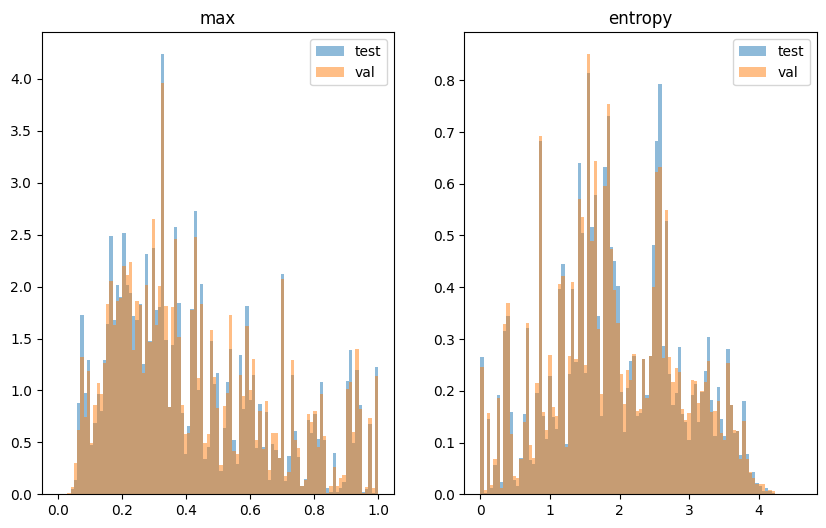

In [29]:
layer = 'classifier.0'
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
for split in ['test', 'val']:
    data = sm[layer][split]
    bins = np.linspace(0, 1, num=100)
    axs[0].hist(data, bins=bins, alpha=0.5, label=split, density=True)
    axs[0].set_title('max')
    axs[0].legend()

    data = -se[layer][split]
    bins = np.linspace(0, 4.6, num=100)
    axs[1].hist(data, bins=bins, alpha=0.5, label=split, density=True)
    axs[1].set_title('entropy')
    axs[1].legend()

plt.show()

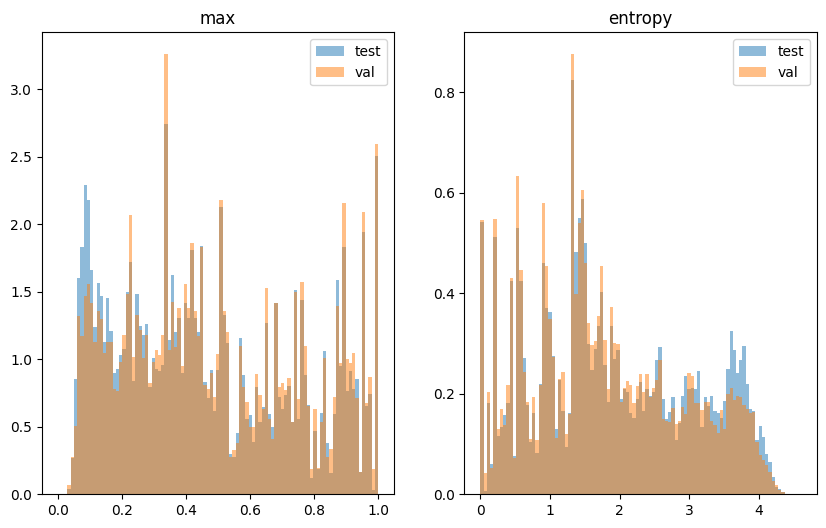

In [28]:
layer = 'classifier.3'
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
for split in ['test', 'val']:
    data = sm[layer][split]
    bins = np.linspace(0, 1, num=100)
    axs[0].hist(data, bins=bins, alpha=0.5, label=split, density=True)
    axs[0].set_title('max')
    axs[0].legend()

    data = -se[layer][split]
    bins = np.linspace(0, 4.6, num=100)
    axs[1].hist(data, bins=bins, alpha=0.5, label=split, density=True)
    axs[1].set_title('entropy')
    axs[1].legend()

plt.show()